In [1]:
import numpy as np
import yt
import ytree
import math
import sys
import matplotlib.pyplot as plt
from yt.units import kpc
from matplotlib import cm
from matplotlib.lines import Line2D
import glob

# Trying to find MM and LW Histories in Consistent Trees file

### Trying to find MM and LW in z-15 data

In [2]:
ds  = yt.load('rockstar_halos-z15/halos_RD0002.0.bin')

yt : [INFO     ] 2022-02-22 15:01:03,004 Parameters: current_time              = 8776710304200322.0 s
yt : [INFO     ] 2022-02-22 15:01:03,009 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-02-22 15:01:03,011 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-02-22 15:01:03,013 Parameters: domain_right_edge         = [28.39999962 28.39999962 28.39999962]
yt : [INFO     ] 2022-02-22 15:01:03,014 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-02-22 15:01:03,015 Parameters: current_redshift          = 15.0
yt : [INFO     ] 2022-02-22 15:01:03,016 Parameters: omega_lambda              = 0.734000027179718
yt : [INFO     ] 2022-02-22 15:01:03,017 Parameters: omega_matter              = 0.26600000262260437
yt : [INFO     ] 2022-02-22 15:01:03,018 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-02-22 15:01:03,018 Parameters: hubble_constant           = 0.7099999785423279


In [57]:
lwpos0 = ds.arr([14.36468, 15.49873, 15.03029], 'Mpccm/h')
lwmass = ds.quan(2.841e7, 'Msun/h')
mmpos0 = ds.arr([13.75719, 13.50339, 13.21519], 'Mpccm/h')
mmmass = ds.quan(3.909e7, 'Msun/h')

delta = 178.0
search = 3.0  # in units of rvir0
msearch = 0.3
p = ds.critical_density.to('Msun/Mpc**3')

halos = ds.all_data()
candpos = {}
allrvir = {}
# Professor Wise's code
for name, pos0, mass0 in zip(['LW', 'MM'], [lwpos0, mmpos0], [lwmass, mmmass]):
    candpos[name] = []
    dr = halos['particle_position'] - pos0
    r = (dr**2).sum(1)**0.5
    rvir0 = (mass0 / (4*np.pi/3 * delta*p))**(1.0/3)
    rvir = (halos['particle_mass'] / (4*np.pi/3 * delta*p))**(1.0/3)

    allrvir[name] = rvir0.to('kpc').v
    logdm = np.log10(halos['particle_mass'] / mass0)
    close = np.where((r < search*rvir0) & (np.abs(logdm) < msearch))[0]
    for c in close:
        print('[%s / %d] M=%.2g Msun (dlogM=%.2f) dr=%.2f kpc (rvir0=%.2f kpc)' % \
              (name, c, halos['particle_mass'][c].to('Msun'),
               logdm[c],
               r[c].to('kpc'), rvir0.to('kpc')))
        print('\t Halo position = %s' % (halos['particle_position'][c].to('Mpccm/h')))
        candpos[name].append([c, halos['particle_position'][c].to('Mpccm/h').v,
                              rvir[c].to('kpc').v])
    print('')

[LW / 114300] M=3.6e+07 Msun (dlogM=-0.04) dr=0.46 kpc (rvir0=0.71 kpc)
	 Halo position = [14.36803341 15.49479675 15.03044319] Mpccm/h

[MM / 129188] M=8.5e+07 Msun (dlogM=0.19) dr=1.44 kpc (rvir0=0.79 kpc)
	 Halo position = [13.7586298 13.5069313 13.2310915] Mpccm/h



### ^^ These are the best MM and LW candidates, found in the .bin outputs for the z-15 data. Let's try to find them in the out.list file

In [7]:
out_z15 = ytree.load('rockstar_halos-z15/out_0.list')

def find_halos_in_out_list(data, red, x,y,z, error):
    r,x,y,z,e = str(red), str(x),str(y),str(z), str(error)
    halo_list = list(data.select_halos('np.logical_and(abs(tree["tree","position_x"].to("Mpc/h").v-'+x+')<'+e+',np.logical_and(abs(tree["tree","position_y"].to("Mpc/h").v-'+y+')<'+e+',abs(tree["tree","position_z"].to("Mpc/h").v-'+z+')<'+e+' ))'))
    return halo_list

def print_halo_cands(halo_list):
    for h in halo_list: print (h, " ", h['position'].to('Mpc/h'), " ", h['mass'].to('Msun'), " ", h['Mvir_all'].to('Msun') , " ", h['ID'], "  ", h['DescID'] )
        
        
LW_id = 114300
LWm=3.6e+07 
LWp=[14.36803341, 15.49479675,15.03044319]
MM_id = 129188
MMm=8.5e+07 
MMp=[13.7586298, 13.5069313, 13.2310915]


MM_cands = find_halos_in_out_list(out_z15, 15,MMp[0], MMp[1], MMp[2], 0.01)
LW_cands = find_halos_in_out_list(out_z15, 15,LWp[0], LWp[1], LWp[2], 0.01)

Selecting halos (found 6): 100%|█████████████████████████████████████████████| 162490/162490 [00:50<00:00, 3196.26it/s]


In [20]:
print("MM_CANDIDATES:")
print_halo_cands(MM_cands[5:6])
print("\n\nLW_CANDIDATES:")
print_halo_cands(LW_cands[5:6])

#MM ID 34043 and LW ID 159092 are clear winners

MM_CANDIDATES:
TreeNode[34043]   [13.75863  13.50693  13.231091] Mpc/h   84736620.0 Msun   84840850.0 Msun   34043    -1


LW_CANDIDATES:
TreeNode[159092]   [14.36803  15.4948   15.030439] Mpc/h   29423944.0 Msun   36390140.0 Msun   159092    -1


### Is a linear advection safe, how does dx=v*dt compare to r_vir? (answer: r_vir < dx)

In [69]:
MM = MM_cands[5:6][0]
LW = LW_cands[5:6][0]
time =MM["time"].v
time2 = LW["time"].v
vel = np.array([MM["velocity_x"].v,MM["velocity_y"].v,MM["velocity_z"].v]) #km/s
vel2 = np.array([LW["velocity_x"].v,LW["velocity_y"].v,LW["velocity_z"].v]) #km/s
speed_mm = np.sqrt(np.sum(np.power(vel,2)))
speed_lw = np.sqrt(np.sum(np.power(vel2,2)))

In [70]:
print(MM["Rvir"])
print(LW["Rvir"])
#lies, actually in cmkpc/h

10.307 kpc/h
7.244 kpc/h


In [13]:
mm_rvir_temp = 10.307 #cmkpc/h

In [75]:
i=16
print(mm_time[i], mm_z[i])
t2 = mm_time[i]
t1 = time
dt = t2-t1
#dt = dt*3.154e+7*1e6 #seconds

280.05543679809546 14.926104


In [73]:
dx_mm = speed_mm*dt*3.24078e-17 #kpc
dx_lw = speed_lw*dt*3.24078e-17 #kpc
print(dx_mm, dx_lw)

0.34935221465593014 0.27573687488496595


In [ ]:
#This is in physical units, radius given in comoving. Multiply this by a factor of ~10~(1+z)*h to get dx in comoving

In [14]:
dx_mm_comoving_h = 0.34935221465593014*0.71*(16)
print(dx_mm_comoving_h/mm_rvir_temp)

0.3850432869400763


### Now that I've found MM and LW in the rockstar data for z15, advect them and find them in my rockstar data at the redshift closest to 15

In [12]:
#We have out_23 with redshift 16.746159893849 and out_24 with redshift 14.926063520522. The latter being much closer.
out_after_z15 = ytree.load('rockstar_halos/out_24.list')

def find_halos_in_out_list(data, red, x,y,z, error):
    r,x,y,z,e = str(red), str(x),str(y),str(z), str(error)
    halo_list = list(data.select_halos('np.logical_and(abs(tree["tree","position_x"].to("Mpc/h").v-'+x+')<'+e+',np.logical_and(abs(tree["tree","position_y"].to("Mpc/h").v-'+y+')<'+e+',abs(tree["tree","position_z"].to("Mpc/h").v-'+z+')<'+e+' ))'))
    return halo_list

def print_halo_cands(halo_list):
    for h in halo_list: print (h, " ", h['position'].to('Mpc/h'), " ", h['mass'].to('Msun'), " ", h['Mvir_all'].to('Msun') , " ", h['ID'], "  ", h['DescID'] )
        
MMm=8.5e+07 
MMp=[13.7586298, 13.5069313, 13.2310915]



#MM_cands = find_halos_in_out_list(out_after_z15, 15,MMp[0], MMp[1], MMp[2], 0.01)
#LW_cands = find_halos_in_out_list(out_after_z15, 15,LWp[0], LWp[1], LWp[2], 0.01)

# print("MM_CANDIDATES:")
# print_halo_cands(MM_cands)
# print("\n\nLW_CANDIDATES:")
# print_halo_cands(LW_cands)

# #the values from the z15 MM and LW best candidates
# LW_id = 114300
# LWm=3.6e+07 
# LWp=[14.36803341, 15.49479675,15.03044319]
# MM_id = 129188
# MMm=8.5e+07 
# MMp=[13.7586298, 13.5069313, 13.2310915]
# #based on this, MM_id_z14 = 16317, LW_id_z14 = 49372

### Finding MM and LW in the tree data

In [3]:
dst = ytree.load("rockstar_halos/trees/tree_0_0_0.dat")
trees = list(dst[:])
print(dst.field_list)

Loading tree roots:   0%|                                         | 18890269/8550430545 [00:00<00:45, 188869547.91it/s]

Additional features and improved performance (usually) by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("rockstar_halos/trees/tree_0_0_0.dat")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)


Loading tree roots: 100%|███████████████████████████████████████| 8550430545/8550430545 [00:38<00:00, 219515503.63it/s]


['scale', 'id', 'desc_scale', 'desc_id', 'num_prog', 'pid', 'upid', 'desc_pid', 'phantom', 'sam_Mvir', 'Mvir', 'Rvir', 'rs', 'vrms', 'mmp?', 'scale_of_last_MM', 'vmax', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'Spin', 'Breadth_first_ID', 'Depth_first_ID', 'Tree_root_ID', 'Orig_halo_ID', 'Snap_idx', 'Next_coprogenitor_depthfirst_ID', 'Last_progenitor_depthfirst_ID', 'Last_mainleaf_depthfirst_ID', 'Tidal_Force', 'Tidal_ID', 'Rs_Klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Type', 'SM', 'Gas', 'BH_Mass']


In [340]:
def find_halos_in_trees(data, red, x,y,z, error):
    r,x,y,z,e = str(red), str(x),str(y),str(z), str(error)
    halo_list = list(data.select_halos('np.logical_and(abs(tree["tree","redshift"]-'+r+')<'+e+',np.logical_and(abs(tree["tree","position_x"].to("Mpc/h").v-'+x+')<'+e+',np.logical_and(abs(tree["tree","position_y"].to("Mpc/h").v-'+y+')<'+e+',abs(tree["tree","position_z"].to("Mpc/h").v-'+z+')<'+e+' )))'))
    return halo_list

def print_halo_cands_trees(halo_list):
    for h in halo_list: print (h, " ", h['position'].to('Mpc/h'), " ",  "{:.2e}".format(h['Mvir_all'].to('Msun/h')) , " ", h['Orig_halo_ID'])
        
        
# MM_tree_cands = find_halos_in_trees(dst, 14.926063520522, MMp[0], MMp[1], MMp[2], 0.03)
# LW_tree_cands = find_halos_in_trees(dst, 14.926063520522, LWp[0], LWp[1], LWp[2], 0.03)


# print_halo_cands_trees(MM_tree_cands)
# print("\n\n\n\n")
# print_halo_cands_trees(LW_tree_cands)

#Using the values for the best MM and LW cands above...
MM_tree_ID = 573941
LW_tree_ID = 593830

MM = dst.select_halos('abs(tree["tree","id"]-'+str(MM_tree_ID)+')<'+str(0.1))
MM_halo = list(MM)[0]
# LW = dst.select_halos('abs(tree["tree","id"]-'+str(LW_tree_ID)+')<'+str(0.1))
# LW_halo = list(LW)[0]


Selecting halos (0 found):   0%|                                                         | 0/122578 [08:24<?, ?it/s]

Selecting halos (found 1):   0%|                                             | 159/122578 [01:30<5:33:23,  6.12it/s]


Selecting halos (found 1):   0%|▏                                            | 492/122578 [01:54<1:48:21, 18.78it/s]


Selecting halos (found 1):   1%|▍                                             | 1106/122578 [02:11<40:31, 49.95it/s]


Selecting halos (found 1):   2%|▊                                             | 2196/122578 [02:41<35:20, 56.77it/s]


Selecting halos (found 1):   3%|█▍                                           | 3908/122578 [02:57<15:21, 128.80it/s]


Selecting halos (found 1):   5%|██▍                                          | 6617/122578 [03:12<09:19, 207.13it/s]


Selecting halos (found 1):   9%|███▊                                        | 10498/122578 [03:27<06:00, 310.53it/s]


Selecting halos (found 1):  13%|█████▌                                      | 15405/122578 [03:41<05:01, 355.47it/s]


Selecting halos (found 1):  17%|███████▋                                    | 21285/122578 [03:56<03:42, 454.98it/s]


Selecting halos (found 1):  23%|██████████                                  | 28190/122578 [04:10<03:02, 516.08it/s]


Selecting halos (found 1):  30%|█████████████                               | 36318/122578 [04:24<02:18, 623.54it/s]


Selecting halos (found 1):  37%|████████████████▍                           | 45736/122578 [04:39<01:53, 676.40it/s]


Selecting halos (found 1):  46%|████████████████████▏                       | 56193/122578 [04:53<01:22, 807.37it/s]


Selecting halos (found 1):  56%|████████████████████████▍                   | 68231/122578 [05:07<00:59, 914.36it/s]


Selecting halos (found 1):  67%|█████████████████████████████▋              | 82572/122578 [05:37<02:47, 239.08it/s]


Selecting halos (found 1):  81%|██████████████████████████████████▊        | 99353/122578 [05:51<00:18, 1279.90it/s]


Selecting halos (found 1):  98%|█████████████████████████████████████████ | 119796/122578 [06:05<00:01, 1620.93it/s]


Selecting halos (found 1): 100%|███████████████████████████████████████████| 122578/122578 [06:07<00:00, 333.82it/s]


### Pulling MM and LW data from tree

In [450]:
mm_mass   = np.array(MM_halo["prog","Mvir_all"].to("Msun/h"))[::-1]
mm_time   = np.array(MM_halo["prog","time"])[::-1]
mm_z      = np.array(MM_halo["prog","redshift"])[::-1]
mm_rad    = np.array(MM_halo["prog","Rvir"].to("kpc/h"))[::-1]
mm_pos    = np.array(MM_halo["prog","position"].to("kpc/h"))[::-1]
mm_pos_cl = np.array(MM_halo["prog","position"])[::-1]
mm_pos_cm    = np.array(MM_halo["prog","position"].to("kpc/h"))[::-1]
mm_tforce = np.array(MM_halo["prog","Tidal_Force"])[::-1]
mm_pids   = np.array(MM_halo["prog","pid"])[::-1]
mm_oids   = np.array(MM_halo["prog","Orig_halo_ID"])[::-1]
mm_mvir = np.array(MM_halo["prog", "Mvir"].to("Msun/h"))[::-1]

# lw_mass   = np.array(LW_halo["prog","Mvir_all"].to("Msun/h"))[::-1]
# lw_time   = np.array(LW_halo["prog","time"])[::-1]
# lw_z      = np.array(LW_halo["prog","redshift"])[::-1]
# lw_rad    = np.array(LW_halo["prog","Rvir"])[::-1]
# lw_pos    = np.array(LW_halo["prog","position"])[::-1]
# lw_tforce = np.array(LW_halo["prog","Tidal_Force"])[::-1]
# lw_pids   = np.array(LW_halo["prog","pid"])[::-1]
# lw_oids   = np.array(LW_halo["prog","Orig_halo_ID"])[::-1]
# lw_mvir = np.array(LW_halo["prog", "Mvir"].to("Msun/h"))[::-1]


In [451]:
desc = MM_halo.descendent
mm_pos = list(mm_pos)
mm_pos_cl = list(mm_pos_cl)
lw_pos = list(lw_pos)
while (desc != None):
    mm_mass = np.append(mm_mass, np.array(desc["Mvir_all"].to("Msun/h")))
    mm_time = np.append(mm_time, np.array(desc["time"]))
    mm_z    = np.append(mm_z, np.array(desc["redshift"]))
    mm_rad  = np.append(mm_rad, np.array(desc["Rvir"].to("kpc/h")))
    mm_pos.append(np.array(desc["position"].to("kpc/h")))
    mm_pos_cl.append(np.array(desc["position"]))
    mm_tforce = np.append(mm_tforce,np.array(desc["Tidal_Force"]))
    mm_pids   = np.append(mm_pids, np.array(desc["pid"]))
    mm_oids   = np.append(mm_oids, np.array(desc["Orig_halo_ID"]))
    mm_mvir   = np.append(mm_mvir, np.array(desc["Mvir"].to("Msun/h")))
    desc = desc.descendent


# desc = LW_halo.descendent
# while (desc != None):
# #     lw_mass = np.append(lw_mass, np.array(desc["Mvir_all"].to("Msun/h")))
# #     lw_time = np.append(lw_time, np.array(desc["time"]))
# #     lw_z = np.append(lw_z, np.array(desc["redshift"]))
# #     lw_rad  = np.append(lw_rad, np.array(desc["Rvir"]))
# #     lw_pos.append(np.array(desc["position"]))
# #     lw_pids   = np.append(lw_pids, np.array(desc["pid"]))
# #     lw_oids   = np.append(lw_oids, np.array(desc["Orig_halo_ID"]))
#     lw_mvir   = np.append(lw_mvir, np.array(desc["Mvir"].to("Msun/h")))

#     desc = desc.descendent

### Getting parent information

In [323]:
mm_pids = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4336676, 4514815, 4694792, 4876290, 5059504, 5244051, 5430112, 5617360, 5805997, 5995970, 6187016, 6379160, 6572876, 6767498, 6962856, 7159260, 7356174, 7554011, 7752943, 7952437, 8152256, 8352620, 8553283, 8754305, 8955699, 9157673, 9362498, 9565975, 9769559, 9973857, 10177465, 10380179, 10584396, 10788526, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
lw_pids =[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1580084, 1709532, 1842461, 1979225, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3511281, 3679259, 3849720, 4022291, 4196835, 4373401, 4551912, 4732099, 4913870, 5097272, 5282252, 5468485, 5655932, 5844691, 6034727, 6225966, 6418260, 6612053, 6806755, 7001727, 7198074, 7395080, 7593006, 7791889, 7992075, 8191832, 8392175, 8592773, 8793737, 8995174, 9197216, 9400087, 9603491, 9806683, 10010129, 10213620, 10417244, 10621523, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

mm_pids_cleaned = []
lw_pids_cleaned = []
for id_ in mm_pids: 
    if(id_ != -1): mm_pids_cleaned.append(id_)
for id_ in lw_pids: 
    if(id_ != -1): lw_pids_cleaned.append(id_)
        
mm_pids_string, lw_pids_string = "", ""
for id_ in mm_pids_cleaned:
    mm_pids_string += "(abs(tree['tree', 'id'] - "+str(id_)+")<0.1) | "
mm_pids_string = mm_pids_string[:len(mm_pids_string)-3]
for id_ in lw_pids_cleaned:
    lw_pids_string += "(abs(tree['tree', 'id'] - "+str(id_)+")<0.1) | "
lw_pids_string = lw_pids_string[:len(lw_pids_string)-3]


mm_parents = list(dst.select_halos(mm_pids_string))
lw_parents = list(dst.select_halos(lw_pids_string))

Selecting halos (0 found):   0%|                                                         | 0/122578 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [433]:
mm_parents_pos,mm_parents_pos_cl, lw_parents_pos, mm_selected_ids, lw_selected_ids, mm_poids, lw_poids = [],[],[],[],[],[],[]
mm_parent_rvir, lw_parent_rvir = [],[]
mm_parent_mass, lw_parent_mass = [],[]

for h in mm_parents: 
    mm_selected_ids.append(h["id"])
    mm_parents_pos.append(h["position"].to("kpc/h"))
    mm_parents_pos_cl.append(h["position"])
    mm_poids.append(h["Orig_halo_ID"])
    mm_parent_mass.append(h["Mvir_all"].to("Msun/h"))
    mm_parent_rvir.append(h["Rvir"].to("kpc/h"))
# for h in lw_parents: 
#     lw_selected_ids.append(h["id"])
#     lw_parents_pos.append(h["position"].to("kpc"))
#     lw_poids.append(h["Orig_halo_ID"])
#     lw_parent_mass.append(h["Mvir_all"].to("Msun/h"))
#     lw_parent_rvir.append(h["Rvir"].to("kpc"))

mm_parents_pos = np.array(mm_parents_pos)[np.argsort(mm_selected_ids)]
mm_parents_pos_cl = np.array(mm_parents_pos_cl)[np.argsort(mm_selected_ids)]
mm_poids = np.array(mm_poids)[np.argsort(mm_selected_ids)]
mm_parent_rvir = np.array(mm_parent_rvir)[np.argsort(mm_selected_ids)]
mm_parent_mass = np.array(mm_parent_mass)[np.argsort(mm_selected_ids)]


# lw_parents_pos = np.array(lw_parents_pos)[np.argsort(lw_selected_ids)]
# lw_poids = np.array(lw_poids)[np.argsort(mm_selected_ids)]
# lw_parent_rvir = np.array(lw_parent_rvir)[np.argsort(mm_selected_ids)]
# lw_parent_mass = np.array(lw_parent_mass)[np.argsort(mm_selected_ids)]


mm_parent_inds = np.where(np.array(mm_pids) != -1)
mm_filtered_z = np.array(mm_z)[mm_parent_inds]
mm_filtered_pos = np.array(mm_pos)[mm_parent_inds]


# lw_parent_inds = np.where(np.array(lw_pids) != -1)
# lw_filtered_z = np.array(lw_z)[lw_parent_inds]
# lw_filtered_pos = np.array(lw_pos)[lw_parent_inds]


# mm_parent_distance = 28.4*np.sqrt(np.power(mm_filtered_pos.T[0] - mm_parents_pos.T[0],2) + np.power(mm_filtered_pos.T[1] - mm_parents_pos.T[1],2) + np.power(mm_filtered_pos.T[2] - mm_parents_pos.T[2],2))*1000
# lw_parent_distance = 28.4*np.sqrt(np.power(lw_filtered_pos.T[0] - lw_parents_pos.T[0],2) + np.power(lw_filtered_pos.T[1] - lw_parents_pos.T[1],2) + np.power(lw_filtered_pos.T[2] - lw_parents_pos.T[2],2))*1000

### Rockstars parent declaration isn't the same as the MMH/LWH superhost, pull the superhost data

In [2]:
dst = ytree.load("rockstar_halos/trees/tree_0_0_0.dat")
trees = list(dst[:])

Loading tree roots:   0%|                                                               | 0/8550430545 [00:00<?, ?it/s]

Additional features and improved performance (usually) by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("rockstar_halos/trees/tree_0_0_0.dat")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)


Loading tree roots: 100%|███████████████████████████████████████| 8550430545/8550430545 [00:39<00:00, 216341259.83it/s]


In [20]:
lw_ind = np.where(np.abs(np.array(lw_z)-8.030976) <0.01 )[0][0]
mm_ind = np.where(np.abs(np.array(mm_z)-8.030976) <0.01 )[0][0]
print(lw_ind)
print(lw_z[lw_ind])
print(lw_oids[lw_ind])
print(mm_z[mm_ind])
print(mm_oids[mm_ind])

75
8.030976
132986
8.030976
129983


In [5]:
def find_halos_in_trees(data, red, x,y,z, error):
    r,x,y,z,e = str(red), str(x),str(y),str(z), str(error)
    halo_list = list(data.select_halos('np.logical_and(abs(tree["tree","redshift"]-'+r+')<'+e+',np.logical_and(abs(tree["tree","position_x"].to("Mpc/h").v-'+x+')<'+e+',np.logical_and(abs(tree["tree","position_y"].to("Mpc/h").v-'+y+')<'+e+',abs(tree["tree","position_z"].to("Mpc/h").v-'+z+')<'+e+' )))'))
    return halo_list

def print_halo_cands_trees(halo_list):
    for h in halo_list: print (h, "   red:", h['redshift'], " ", h['position'].to('Mpc/h'), " ",  "{:.2e}".format(h['Mvir_all'].to('Msun/h')) , " ", h['Orig_halo_ID'])
        


# print_halo_cands_trees(LW_tree_cands)
mm_superhost_id = 129983
lw_superhost_id = 132986

In [6]:
MM_parent_at_z8 = dst.select_halos('np.logical_and(abs(tree["tree","redshift"]-'+str(8.030976)+')<'+str(0.01)+',abs(tree["tree","Orig_halo_ID"]-'+str(mm_superhost_id)+')<'+str(0.01)+")")
MM_parent_at_z8_halo = list(MM_parent_at_z8)

Selecting halos (found 1): 100%|██████████████████████████████████████████████| 122578/122578 [07:01<00:00, 290.55it/s]


In [7]:
LW_parent_at_z8 = dst.select_halos('np.logical_and(abs(tree["tree","redshift"]-'+str(8.030976)+')<'+str(0.01)+',abs(tree["tree","Orig_halo_ID"]-'+str(lw_superhost_id)+')<'+str(0.01)+")")
LW_parent_at_z8_halo = list(LW_parent_at_z8)

Selecting halos (found 1): 100%|██████████████████████████████████████████████| 122578/122578 [06:58<00:00, 293.18it/s]


In [8]:
print_halo_cands_trees(MM_parent_at_z8_halo)
print_halo_cands_trees(LW_parent_at_z8_halo)

TreeNode[11401237]    red: 8.030976   [14.06812 13.45965 13.76887] Mpc/h   8.27e+10 Msun/h   129983
TreeNode[11440224]    red: 8.030976   [14.25948  15.005211 15.383141] Mpc/h   8.30e+10 Msun/h   132986


In [9]:
mm_superhost = MM_parent_at_z8_halo[0]
lw_superhost = LW_parent_at_z8_halo[0]

In [53]:
MM_superhost_at_z8_oids   = np.array(mm_superhost["prog","Orig_halo_ID"])[::-1]
MM_superhost_at_z8_z   = np.array(mm_superhost["prog","redshift"])[::-1]
MM_superhost_at_z8_mass = np.array(mm_superhost["prog","Mvir_all"].to("Msun/h"))[::-1]
MM_superhost_at_z8_pos = np.array(mm_superhost["prog","position"])[::-1]
MM_superhost_at_z8_rad = np.array(mm_superhost["prog","Rvir"])[::-1]

# desc = mm_superhost.descendent
# MM_superhost_at_z8_pos = list(MM_superhost_at_z8_pos)
# while (desc != None):
#     MM_superhost_at_z8_oids = np.append(MM_superhost_at_z8_oids, np.array(desc["Orig_halo_ID"]))
#     MM_superhost_at_z8_z = np.append(MM_superhost_at_z8_z, np.array(desc["redshift"]))
#     MM_superhost_at_z8_pos.append(np.array(desc["position"]))
#     desc = desc.descendent
    
# MM_superhost_at_z8_pos = np.array(MM_superhost_at_z8_pos)    

In [54]:
LW_superhost_at_z8_oids   = np.array(lw_superhost["prog","Orig_halo_ID"])[::-1]
LW_superhost_at_z8_z   = np.array(lw_superhost["prog","redshift"])[::-1]
LW_superhost_at_z8_mass = np.array(lw_superhost["prog","Mvir_all"].to("Msun/h"))[::-1]
LW_superhost_at_z8_pos = np.array(lw_superhost["prog","position"])[::-1]
LW_superhost_at_z8_rad = np.array(lw_superhost["prog","Rvir"])[::-1]
# desc = lw_superhost.descendent
# LW_superhost_at_z8_pos = list(LW_superhost_at_z8_pos)
# while (desc != None):
#     LW_superhost_at_z8_oids = np.append(LW_superhost_at_z8_oids, np.array(desc["Orig_halo_ID"]))
#     LW_superhost_at_z8_z = np.append(LW_superhost_at_z8_z, np.array(desc["redshift"]))
#     LW_superhost_at_z8_pos.append(np.array(desc["position"]))
#     desc = desc.descendent
    
# LW_superhost_at_z8_pos = np.array(LW_superhost_at_z8_pos)  

In [48]:
z1 =  np.array(MM_superhost_at_z8_z)
z2 =  np.array(mm_z)
mm_super_filt = np.where((z1 < 13) & (z1>8))
mm_filt = np.where((z2 < 13) & (z2>8))
p1, p2 = np.array(mm_pos_cl)[mm_filt], np.array(MM_superhost_at_z8_pos)[mm_super_filt]
sep_mm_cmkpc = np.sqrt(np.sum(np.power(p1-p2,2), axis=1))*(28.4*1000)
sep_mm = sep_mm_cmkpc/(0.71*(1+np.array(mm_z)[mm_filt]))

In [49]:
z1 =  np.array(LW_superhost_at_z8_z)
z2 =  np.array(lw_z)
lw_super_filt = np.where((z1 < 13) & (z1>8))
lw_filt = np.where((z2 < 13) & (z2>8))
p1, p2 = np.array(lw_pos)[lw_filt], np.array(LW_superhost_at_z8_pos)[lw_super_filt]
sep_lw_cmkpc = np.sqrt(np.sum(np.power(p1-p2,2), axis=1))*(28.4*1000)
sep_lw = sep_lw_cmkpc/(0.71*(1+np.array(lw_z)[lw_filt]))

In [59]:
# print(list(MM_superhost_at_z8_oids))
# print(list(MM_superhost_at_z8_z))
# print(list(MM_superhost_at_z8_mass))
# print(list(MM_superhost_at_z8_rad))
# print(MM_superhost_at_z8_pos.tolist())
# print()
# print(sep_mm_cmkpc.tolist())
# print()

# print(sep_mm.tolist())
# print()

# print(list(z))
# print(list(LW_superhost_at_z8_oids))
# print(list(LW_superhost_at_z8_z))
# print(list(LW_superhost_at_z8_mass))
# print(list(LW_superhost_at_z8_rad))
# print(LW_superhost_at_z8_pos.tolist())
# print(sep_lw_cmkpc.tolist())
# print(sep_lw.tolist())
# print(list(z))

# Functions

### Stellar Mass + Stripping (using Behroozi 2013 and instantaneous Halo Mass)

In [2]:
# the following are calibrated for z= 0-8 but we're going to extrapolate to larger z
# from Behroozi and Wechsler, eq 3 w/ parameters on page 10, sec 5
# https://arxiv.org/pdf/1207.6105.pdf
#seems valid for 10^10-10^15 M_sol

def a(z):
    return 1/(1+z)

def nu(z):
    return np.exp(-4*(a(z))**2)

def alpha(z):
    return -1.412 + .731*(a(z)-1)*nu(z)

def delta(z):
    return 3.508 + (2.608*(a(z)-1) - .043*z)*nu(z)

def gamma(z):
    return .316 + (1.319*(a(z)-1) + .279*z)*nu(z)

def log10_m_1(z):
    return  11.514 - (1.793*(a(z)-1) + .251*z)*nu(z) 

def log10_epsilon(z):
    return  -1.777 - .119*(a(z)-1) - .006*(a(z)-1)*nu(z) 

def f(x,z):
    a = -np.log10(np.power(10,(alpha(z)*x)) + 1)
    b = delta(z)*np.power((np.log10(1+np.exp(x))),gamma(z))
    b = b/(1+np.exp(np.power(10, -x)))
    return a+b

#accounting for dm stripping using https://iopscience.iop.org/article/10.3847/1538-4357/833/1/109/pdf
#where Behroozi 2013 would overestimate mass loss during stripping
def stellar_stripping(m_h,stellar_mass,z, a=14.20):
    max_m = 0
    max_ind = 0
    for x in range(len(m_h)-1):  
        if(m_h[x+1] > max_m): 
            max_m = m_h[x+1]
            max_ind = x+1
               
        if(m_h[x+1] < max_m):
            sm_strip_frac = stellar_stripping_fraction(m_h[x+1]/max_m, a)
            sm_strip = sm_strip_frac*stellar_mass[max_ind]
            stellar_mass[x+1] = sm_strip
    return stellar_mass   


def stellar_stripping_fraction(f_dm, a):
    return 1 - np.exp(-a*f_dm)

#behroozi 2013
def calc_mass_beh_2013(m_h,z):
    m_h = np.array(m_h)
    z   = np.array(z)
    a = log10_epsilon(z) + log10_m_1(z)
    b = f(np.log10(m_h) - log10_m_1(z),z)
    c = -f(0,z)
    log10_m_s = a+b+c
    non_stripped_mass = np.power(10, log10_m_s)
    return stellar_stripping(m_h, non_stripped_mass, z)

### Stellar Mass using Behroozi 2019, meant for M_peak

In [10]:

#J1 from https://arxiv.org/pdf/1806.07893.pdf. I'm not sure if it's safe to say M_peak = M_halo
#valid for M_halo 10^10 - 10^15 M_sol and z 0-10
#1/30/2022, updating the values for the row: TRUE, SF, ALL, EXCL

E0 = -1.494
Ea = 1.569
Elna = 1.293
Ez = -0.215
M0 = 12.059
Ma = 4.645
Mlna = 4.544
Mz = -0.757
A0 = 1.905
Aa = -2.555
Alna = -1.875
Az = 0.197
B0 = 0.509
Ba = -0.889
Bz = -0.538
D0 = 0.460
Y0 = -0.807
Ya = -1.859
Yz = -0.637

Msol = 1.989e30


def a(z):
    return 1/(1+z)

def log10_m_2(z):
    return M0 + Ma*(a(z)-1) - Mlna*np.log(a(z)) + Mz*z #+math.log10(Msol)

def epsilon2(z):
    return E0 + Ea*(a(z)-1) - Elna*np.log(a(z)) + Ez*z

def alpha2(z):
    return A0 + Aa*(a(z)-1) - Alna*np.log(a(z)) + Az*z

def beta2(z):
    return B0 + Ba*(a(z)-1) + Bz*z

def delta2(z):
    return D0

def gamma2(z):
    return 10**(Y0 + Ya*(a(z)-1) + Yz*z) 


def get_peak(mass):
    peak = 0
    for x in range(len(mass)):
        if(mass[x] < peak): mass[x] = peak
        else: peak = mass[x]
    return mass


#Behroozi 2019, the version we're going with
def calc_mass_beh_2019(m_h, z):
    m_h = get_peak(np.array(m_h))
    z   = np.array(z)
    x = np.log10(m_h) - log10_m_2(z)
    a = -np.log10(np.power(10, -alpha2(z)*x) + np.power(10,-beta2(z)*x))
    b = gamma2(z)*np.exp(-0.5*np.power(x,2)/(delta2(z)**2))
    log10_m_s = epsilon2(z) + log10_m_2(z) + a + b
    return np.power(10, log10_m_s)

### Plots of the two stellar mass functions 

<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-2-0d4cd87ff2ad>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))


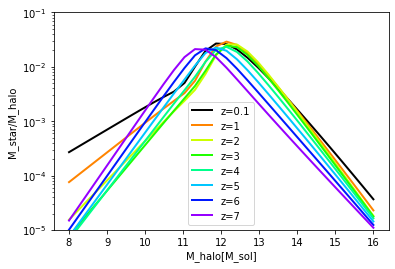

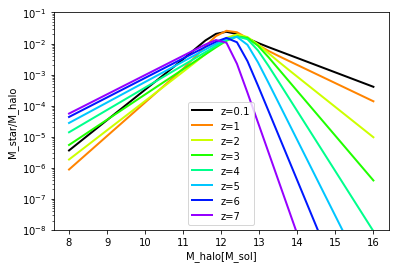

In [17]:
import matplotlib.cm as cm
cmap = cm.gist_rainbow

plt.figure()
plt.yscale("log")
plt.ylim(0.00001,0.1)
plt.ylabel("M_star/M_halo")
plt.xlabel("M_halo[M_sol]")

x_vals = np.linspace(8,16,30)
plt.plot(x_vals, calc_mass_beh_2013([np.power(10,x_vals)],0.1)[0]/10**x_vals, c="black", label="z=0.1", lw= 2)
for z in range(1,8):
    plt.plot(x_vals, calc_mass_beh_2013([np.power(10,x_vals)],z)[0]/10**x_vals, c=cmap(z/8), label="z="+str(z), lw = 2)
plt.legend()
#plt.savefig("old_star_mass_function.pdf")

plt.figure()
plt.yscale("log")
plt.ylim(0.00000001,0.1)
#plt.xlim(0,16)
plt.ylabel("M_star/M_halo")
plt.xlabel("M_halo[M_sol]")

x_vals = np.linspace(8,16,30)
plt.plot(x_vals, calc_mass_beh_2019(np.power(10,x_vals),0.1)/10**x_vals, c="black", label="z=0.1", lw= 2)
for z in range(1,8):
    plt.plot(x_vals, calc_mass_beh_2019(np.power(10,x_vals),z)/10**x_vals, c=cmap(z/8), label="z="+str(z), lw = 2)
plt.legend()

# x_vals = np.linspace(6,16,40)
# plt.plot(x_vals, calc_mass_beh_2019(np.power(10,x_vals),0.1)/10**x_vals, c="black", label="z=0.1", lw= 0.2)
# for z in range(1,12):
#     plt.plot(x_vals, calc_mass_beh_2019(np.power(10,x_vals),np.linspace(z,z, len(x_vals)))/10**x_vals, c=cmap(z/11), label="z="+str(z), lw= 0.2)
# plt.legend()
# filt = np.where(np.array(mm_z) < 13)
# mm_mass1 = get_peak(np.array(mm_mass))

# # x,y,z =np.log10(mm_mass1)[filt],calc_mass_beh_2019(np.array(mm_mass1)[filt],np.array(mm_z)[filt])/np.array(mm_mass1)[filt], np.array(mm_z)[filt]
# # plt.scatter(x,y, c=z, cmap=cmap, label="MMH",s=100)
# # plt.colorbar()
# plt.scatter(np.log10(lw_mass),calc_mass_beh_2019(lw_mass,lw_z)/np.array(lw_mass), c="tab:blue", label="LWH")

# plt.show()
#plt.savefig("new_star_mass_function.pdf") 

### Comparing the raw data to our fits in the extrapolated regions

In [115]:
path = "umachine-dr1/data/smhm/averages"
averages = glob.glob(path+"/sm*")
m,ratio,z_vals = [],[],[]
for f in averages:
    z_val = 1/float((f.split("s_a")[1]).split(".d")[0]) -1
    file = open(f, "r")
    for line in file:
        if("#" in line): continue
        mass = float(line.split()[0])
        sm_hm = float(line.split()[10])
        if(sm_hm != 0):
            m.append(mass)
            ratio.append(sm_hm)
            z_vals.append(z_val)

(-8.0, -2.0)

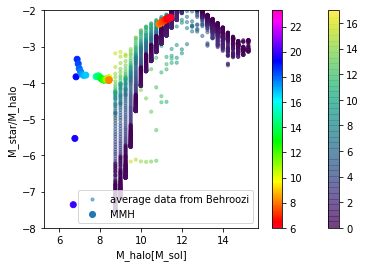

In [119]:
plt.scatter(m,ratio, c=z_vals, alpha=0.5, s=10, label="average data from Behroozi")
plt.colorbar()
plt.scatter(np.log10(mm_mass1),np.log10(calc_mass_beh_2019(mm_mass1,mm_z)/np.array(mm_mass1)), c=mm_z,cmap=cmap, label="MMH")
plt.colorbar()
#plt.scatter(np.log10(lw_mass),np.log10(calc_mass_beh_2019(lw_mass,lw_z)/np.array(lw_mass)), c="tab:blue", label="LWH")
plt.ylabel("M_star/M_halo")
plt.xlabel("M_halo[M_sol]")
plt.legend()
plt.ylim(-8,-2)


### BH growth

In [65]:
omega_m = .266
omega_b = .049

def evolve_BH(halo_mass, time, folding_time, fraction_cap, seed):
    #This assumes black holes start right away, fix later
    
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    scale_factor = np.exp(dt/folding_time)
    cap =fraction_cap*np.array(halo_mass*omega_b/omega_m)
    
    if(seed <= cap[0]): bh_mass = [seed]
    else: bh_mass = [cap[0]]

    for i,sf in enumerate(scale_factor):
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass, cap

### BH Growth w/ Super-eddington condition

In [125]:
def evolve_BH2(halo_mass, time, folding_time, fraction_cap, seed):    
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    dm = (np.array(halo_mass[1:len(halo_mass)])-np.array(halo_mass[0:len(halo_mass)-1]))   
    p=0.6
    m_dot_list = (omega_b/omega_m)*(dm/dt)

    scale_factor = np.exp(dt/folding_time)

    cap =fraction_cap*np.array(halo_mass*omega_b/omega_m)
    
    if(seed <= cap[0]): bh_mass = [seed]
    else: bh_mass = [cap[0]]
    
    for i,sf in enumerate(scale_factor):
        
        m_edd = (1/folding_time)*bh_mass[i]*np.exp((time[i+1]-time[i])/folding_time)
#         F = (bh_mass[i]/2e9)*0.1
#         if(F < 1e-3): F = 1e-3
#         if(F > 0.1): F = 0.1
        F=0.1
        m_dot = F*m_dot_list[i]
        if(m_dot > 0): a= 3*m_edd/(5*m_dot)
        else:
            a=0
            m_dot = 0   
        if(a>1): a=1
        m_bh_dot = np.power(a, p)*m_dot
        
        if(m_bh_dot/m_edd > 1):
            sf = np.exp(dt[i]*(m_bh_dot/m_edd)/folding_time)

        
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass, cap

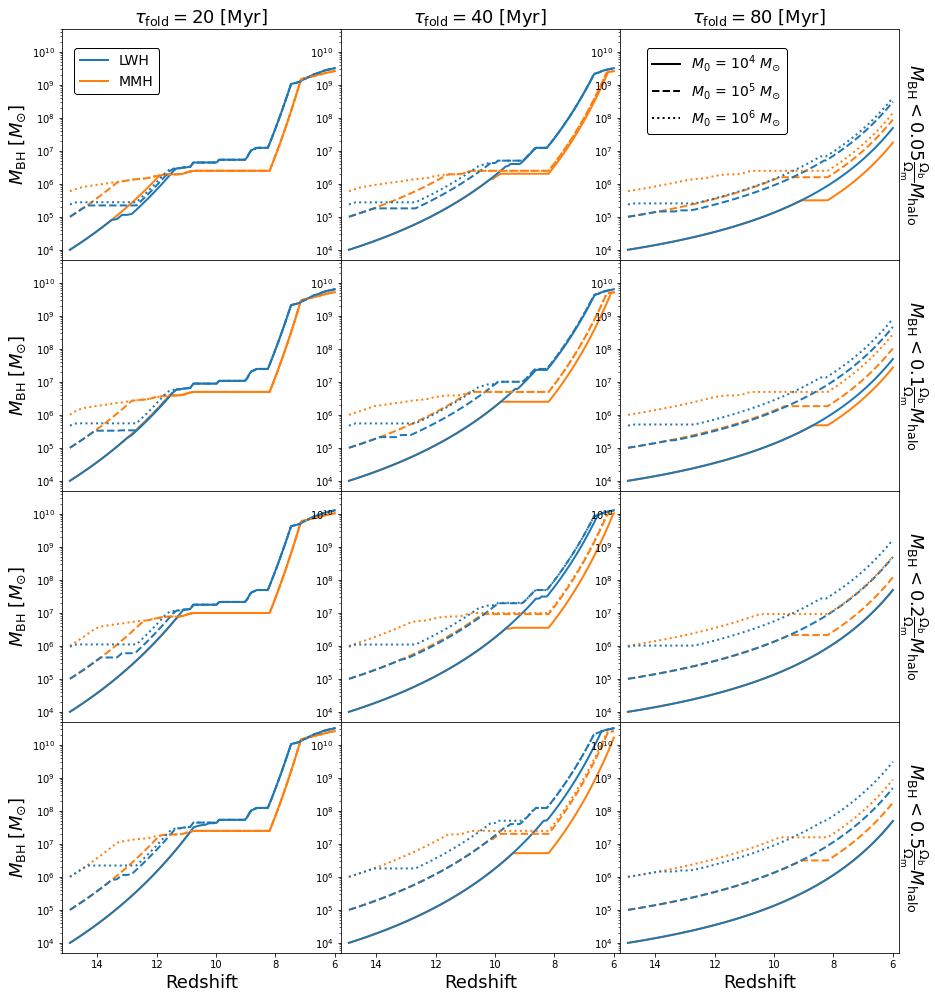

In [106]:
cap_list = [0.05,0.1,0.2,0.5]
seed_list = [1e4,1e5,1e6]
folding_list = [20,40,80]
mm_bh_indices = np.where(np.array(mm_z) < mm_seed_z)
lw_bh_indices = np.where(np.array(lw_z) < lw_seed_z)
x_num = len(folding_list)
y_num = len(cap_list)

fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=False, figsize=(15,17))
for axis in axs.ravel(): 
    axis.set_yscale('log')
    axis.set_ylim(5e3,5e10)
#axs.yscale("log")
plt.xlim(15+0.2,5.8)

for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap = evolve_BH(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass, lw_cap = evolve_BH(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            axs[row,col].plot(np.array(mm_z)[mm_bh_indices], mm_bh_mass, c="tab:orange", linestyle = ls, lw=2)
            axs[row,col].plot(np.array(lw_z)[lw_bh_indices], lw_bh_mass, c="tab:blue", linestyle = ls, lw=2)
            
        if(row==0): axs[row,col].set_title(r"$\tau_{\rm fold} = $" +str(folding_list[col]) +" [Myr]", fontsize = 18 )
        if(col == x_num-1):
            axs[row, col].yaxis.set_label_position("right")
            axs[row, col].set_ylabel(r"$M_{\rm BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_{\rm b}}{\Omega_{\rm m}} M_{\rm halo}$", fontsize = 18, rotation=270, labelpad=30)
        if(col == 0): axs[row, col].set_ylabel(r"$M_{\rm BH} \ [M_{\odot}]$", fontsize = 18 )
        axs[row,col].set_xlabel("Redshift", fontsize = 18 )

            
lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
fig.legend((lines1), ('LWH', 'MMH'), loc='upper left', fontsize = 14, bbox_to_anchor=(0.13, 0.87),edgecolor="black", framealpha=1) 
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper left', fontsize = 14 , bbox_to_anchor=(0.66, 0.87),edgecolor="black", framealpha=1)       


plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z.pdf",bbox_inches='tight')

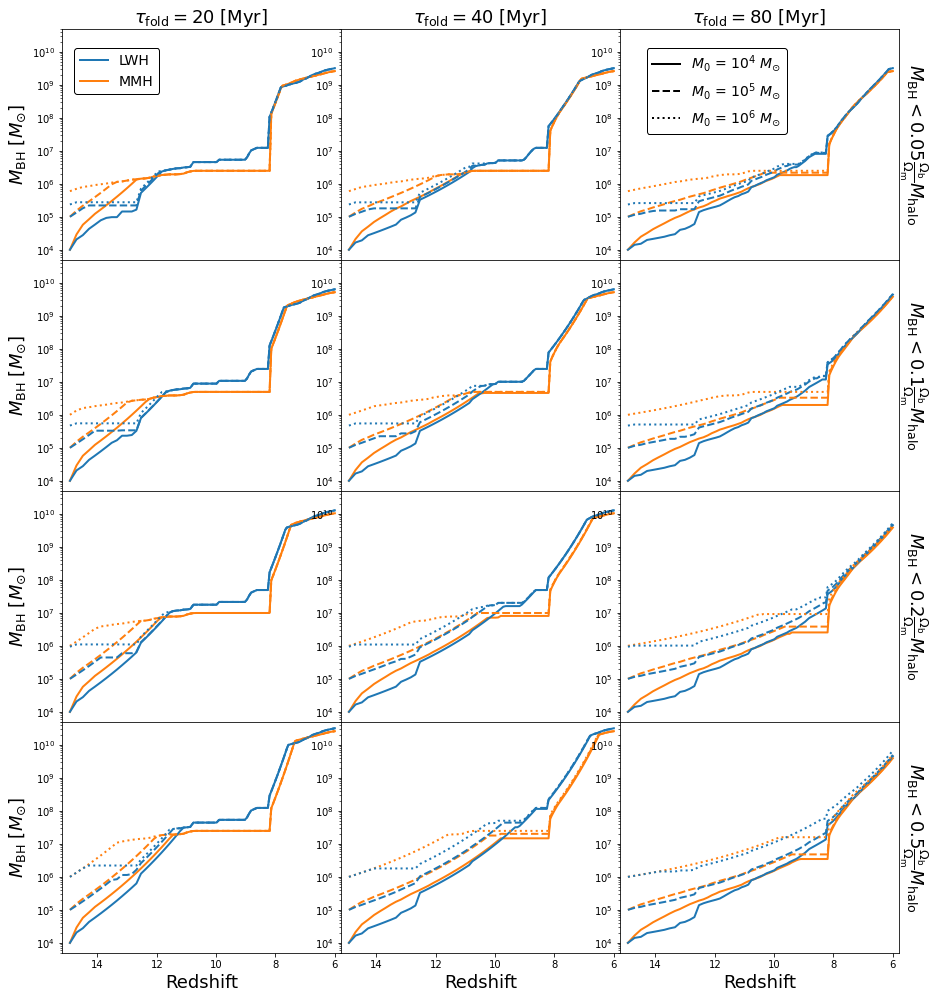

In [128]:
cap_list = [0.05,0.1,0.2,0.5]
seed_list = [1e4,1e5,1e6]
folding_list = [20,40,80]
mm_bh_indices = np.where(np.array(mm_z) < mm_seed_z)
lw_bh_indices = np.where(np.array(lw_z) < lw_seed_z)
x_num = len(folding_list)
y_num = len(cap_list)

fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=False, figsize=(15,17))
for axis in axs.ravel(): 
    axis.set_yscale('log')
    axis.set_ylim(5e3,5e10)
#axs.yscale("log")
plt.xlim(15+0.2,5.8)

for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap = evolve_BH2(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass, lw_cap = evolve_BH2(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            axs[row,col].plot(np.array(mm_z)[mm_bh_indices], mm_bh_mass, c="tab:orange", linestyle = ls, lw=2)
            axs[row,col].plot(np.array(lw_z)[lw_bh_indices], lw_bh_mass, c="tab:blue", linestyle = ls, lw=2)
            
        if(row==0): axs[row,col].set_title(r"$\tau_{\rm fold} = $" +str(folding_list[col]) +" [Myr]", fontsize = 18 )
        if(col == x_num-1):
            axs[row, col].yaxis.set_label_position("right")
            axs[row, col].set_ylabel(r"$M_{\rm BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_{\rm b}}{\Omega_{\rm m}} M_{\rm halo}$", fontsize = 18, rotation=270, labelpad=30)
        if(col == 0): axs[row, col].set_ylabel(r"$M_{\rm BH} \ [M_{\odot}]$", fontsize = 18 )
        axs[row,col].set_xlabel("Redshift", fontsize = 18 )

            
lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
fig.legend((lines1), ('LWH', 'MMH'), loc='upper left', fontsize = 14, bbox_to_anchor=(0.13, 0.87),edgecolor="black", framealpha=1) 
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper left', fontsize = 14 , bbox_to_anchor=(0.66, 0.87),edgecolor="black", framealpha=1)       


plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z_super.pdf",bbox_inches='tight')

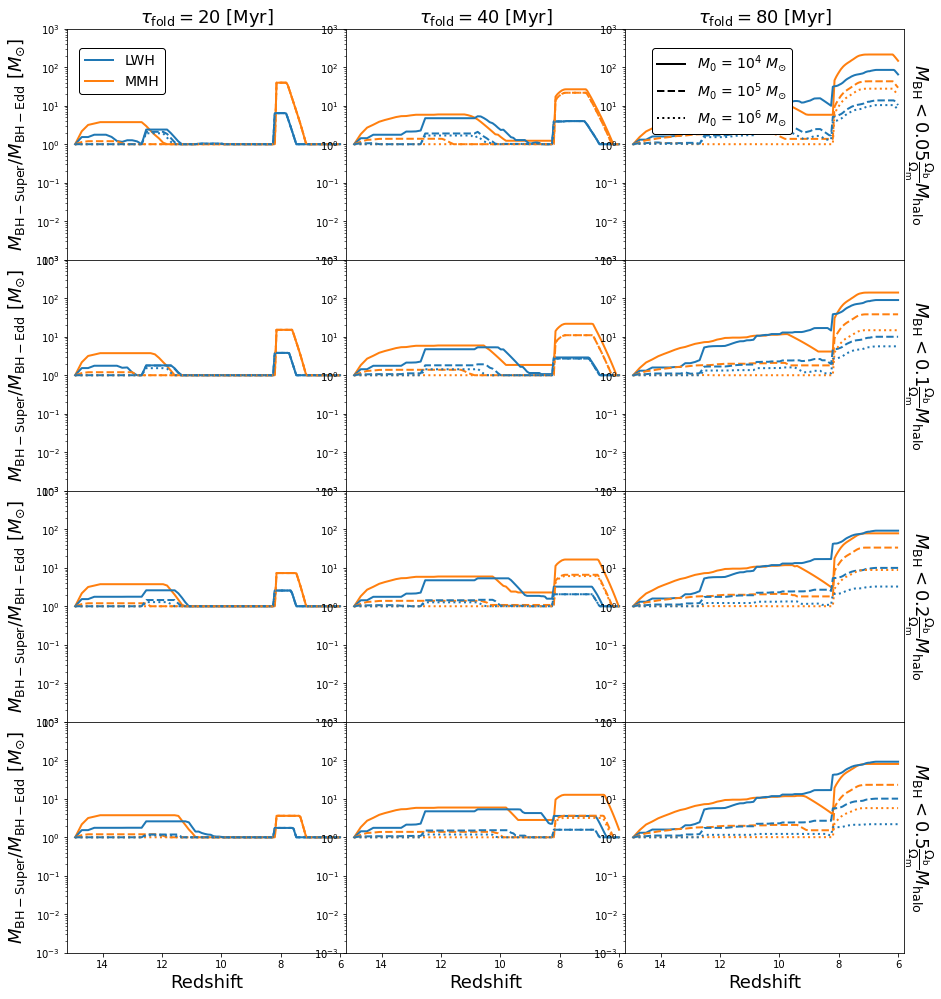

In [129]:
cap_list = [0.05,0.1,0.2,0.5]
seed_list = [1e4,1e5,1e6]
folding_list = [20,40,80]
mm_bh_indices = np.where(np.array(mm_z) < mm_seed_z)
lw_bh_indices = np.where(np.array(lw_z) < lw_seed_z)
x_num = len(folding_list)
y_num = len(cap_list)

fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=False, figsize=(15,17))
for axis in axs.ravel(): 
    axis.set_yscale('log')
    axis.set_ylim(1e-3,1e3)
#axs.yscale("log")
plt.xlim(15+0.2,5.8)

for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap = evolve_BH(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            mm_bh_mass2, mm_cap2 = evolve_BH2(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass, lw_cap = evolve_BH(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass2, lw_cap2 = evolve_BH2(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            axs[row,col].plot(np.array(mm_z)[mm_bh_indices], np.array(mm_bh_mass2)/np.array(mm_bh_mass), c="tab:orange", linestyle = ls, lw=2)
            axs[row,col].plot(np.array(lw_z)[lw_bh_indices], np.array(lw_bh_mass2)/np.array(lw_bh_mass), c="tab:blue", linestyle = ls, lw=2)
            
        if(row==0): axs[row,col].set_title(r"$\tau_{\rm fold} = $" +str(folding_list[col]) +" [Myr]", fontsize = 18 )
        if(col == x_num-1):
            axs[row, col].yaxis.set_label_position("right")
            axs[row, col].set_ylabel(r"$M_{\rm BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_{\rm b}}{\Omega_{\rm m}} M_{\rm halo}$", fontsize = 18, rotation=270, labelpad=30)
        if(col == 0): axs[row, col].set_ylabel(r"$M_{\rm BH-Super}/M_{\rm BH-Edd} \ [M_{\odot}]$", fontsize = 18 )
        axs[row,col].set_xlabel("Redshift", fontsize = 18 )

            
lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
fig.legend((lines1), ('LWH', 'MMH'), loc='upper left', fontsize = 14, bbox_to_anchor=(0.13, 0.87),edgecolor="black", framealpha=1) 
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper left', fontsize = 14 , bbox_to_anchor=(0.66, 0.87),edgecolor="black", framealpha=1)       


plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z_ratio.pdf",bbox_inches='tight')

# Data

### MM and LW data

In [7]:
mm_mass = [541340.0, 861230.0, 1230300.0, 1722500.0, 2780500.0, 3863200.0, 4945900.0, 5930200.0, 6766800.0, 7628000.0, 8636900.0, 9645800.0, 11221000.0, 13115000.0, 15871000.0, 20350000.0, 64814000.0, 76280000.0, 86935000.0, 91979000.0, 99287000.0, 104630000.0, 110340000.0, 117500000.0, 123840000.0, 127900000.0, 135780000.0, 144150000.0, 149210000.0, 155050000.0, 157730000.0, 165530000.0, 180100000.0, 188410000.0, 200100000.0, 204190000.0, 209480000.0, 203320000.0, 207190000.0, 213760000.0, 220500000.0, 241090000.0, 256550000.0, 266390000.0, 268240000.0, 267990000.0, 214000000.0, 249190000.0, 235160000.0, 193785000.0, 152410000.0, 174383300.0, 196356700.0, 218330000.0, 112430000.0, 105220000.0, 85803000.0, 49976000.0, 95695000.0, 48376000.0, 37254000.0, 36516000.0, 37673000.0, 34203000.0, 29060000.0, 25000000.0, 32013000.0, 25172000.0, 26280000.0, 25222000.0, 24090000.0, 23893000.0, 22638000.0, 22687000.0, 22761000.0, 23499000.0, 24434000.0, 75017000000.0, 78981000000.0, 82722000000.0, 86786000000.0, 91149000000.0, 94826000000.0, 95746000000.0, 98578000000.0, 101790000000.0, 104830000000.0, 107940000000.0, 111260000000.0, 115500000000.0, 119740000000.0, 124860000000.0, 130700000000.0, 136770000000.0, 142220000000.0, 146830000000.0, 150580000000.0, 154870000000.0, 158590000000.0, 158850000000.0, 159660000000.0, 162670000000.0, 166150000000.0, 169670000000.0, 173770000000.0, 177870000000.0, 181760000000.0, 185090000000.0, 187990000000.0, 190840000000.0, 194270000000.0, 198680000000.0, 202340000000.0, 205390000000.0, 210680000000.0, 214630000000.0, 218230000000.0, 221750000000.0, 225400000000.0, 229160000000.0, 233470000000.0, 238100000000.0, 242730000000.0, 247050000000.0, 251060000000.0, 255260000000.0, 259650000000.0, 263360000000.0, 266940000000.0, 270080000000.0, 273260000000.0, 276010000000.0, 278710000000.0, 281150000000.0, 281300000000.0]
mm_time = [148.80977113935595, 154.7551727054681, 160.72201956215898, 166.65109675362595, 172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
mm_z = [23.277739, 22.651846, 22.06273, 21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_pos = [[13623.54, 13553.191, 12954.65], [13629.83, 13551.641, 12967.99], [13636.011, 13549.74, 12981.77], [13642.01, 13547.761, 12995.5], [13648.311, 13545.971, 13009.44], [13654.51, 13543.931, 13023.361], [13660.93, 13541.801, 13037.33], [13667.0, 13539.61, 13050.42], [13673.15, 13537.61, 13063.84], [13678.841, 13535.691, 13076.75], [13684.681, 13533.721, 13089.771], [13690.621, 13531.531, 13102.711], [13696.391, 13529.24, 13115.181], [13701.841, 13526.931, 13127.73], [13707.49, 13524.71, 13140.13], [13713.36, 13522.421, 13152.55], [13755.319, 13509.17, 13236.05], [13761.08, 13506.501, 13247.74], [13766.971, 13502.78, 13257.761], [13772.471, 13500.331, 13269.911], [13780.2295, 13498.311, 13280.421], [13784.54, 13494.991, 13290.511], [13790.74, 13493.07, 13300.541], [13796.051, 13491.951, 13310.32], [13801.091, 13489.75, 13320.221], [13806.95, 13487.26, 13330.19], [13814.241, 13485.989, 13341.35], [13823.82, 13485.211, 13351.961], [13826.5205, 13483.1, 13361.91], [13832.671, 13481.23, 13372.171], [13838.931, 13478.541, 13382.631], [13846.051, 13475.251, 13392.411], [13852.98, 13474.09, 13402.551], [13858.491, 13470.9795, 13412.28], [13865.7, 13469.341, 13422.011], [13872.461, 13466.791, 13431.561], [13879.49, 13464.521, 13440.9], [13885.67, 13460.931, 13450.32], [13892.19, 13458.48, 13459.66], [13900.111, 13455.61, 13469.25], [13906.82, 13452.51, 13478.66], [13913.761, 13449.661, 13488.101], [13920.931, 13446.34, 13497.812], [13928.561, 13442.951, 13507.24], [13936.41, 13439.4795, 13516.511], [13945.15, 13435.641, 13526.001], [13954.681, 13431.301, 13535.661], [13965.61, 13425.561, 13545.21], [13976.58, 13420.11, 13554.31], [13987.461, 13413.63, 13559.34], [13989.951, 13412.341, 13569.641], [14010.7705, 13399.971, 13575.631], [14017.951, 13395.591, 13581.94], [14024.551, 13391.791, 13588.26], [14030.49, 13388.251, 13594.931], [14035.04, 13386.091, 13601.961], [14039.61, 13383.891, 13609.041], [14043.721, 13382.301, 13615.891], [14047.261, 13381.11, 13622.63], [14050.471, 13380.32, 13629.811], [14053.251, 13379.811, 13636.72], [14055.61, 13379.69, 13643.851], [14057.58, 13380.09, 13650.57], [14059.201, 13380.391, 13657.481], [14060.551, 13381.67, 13664.5205], [14061.851, 13383.24, 13671.37], [14062.69, 13385.311, 13678.03], [14063.091, 13388.02, 13684.891], [14063.48, 13390.971, 13691.75], [14063.51, 13394.431, 13698.54], [14063.341, 13398.57, 13705.301], [14062.801, 13403.091, 13711.931], [14062.15, 13408.52, 13718.95], [14060.71, 13414.791, 13725.501], [14059.141, 13422.069, 13732.181], [14056.74, 13430.79, 13738.561], [14054.401, 13440.61, 13745.941], [14060.48, 13454.53, 13755.101], [14065.051, 13457.88, 13762.201], [14068.12, 13459.65, 13768.87], [14071.37, 13461.111, 13776.77], [14074.011, 13462.65, 13784.69], [14074.63, 13462.341, 13793.841], [14076.491, 13463.19, 13793.95], [14076.78, 13463.51, 13801.501], [14078.891, 13463.92, 13809.97], [14080.061, 13465.001, 13818.851], [14081.649, 13465.19, 13827.35], [14081.311, 13465.0205, 13837.9], [14083.83, 13465.221, 13844.591], [14083.7705, 13465.689, 13854.701], [14083.761, 13465.99, 13864.15], [14083.26, 13466.2, 13874.171], [14084.341, 13465.63, 13883.23], [14084.5, 13464.9, 13892.239], [14095.529, 13471.301, 13893.671], [14086.5205, 13462.2295, 13909.69], [14088.23, 13461.301, 13918.081], [14090.03, 13460.871, 13925.211], [14089.62, 13460.101, 13927.05], [14090.2705, 13460.37, 13927.46], [14091.12, 13459.201, 13933.91], [14092.79, 13459.2705, 13941.631], [14096.82, 13469.4, 13951.101], [14096.061, 13460.671, 13955.5205], [14097.98, 13460.95, 13962.551], [14099.57, 13462.86, 13969.17], [14100.701, 13465.3, 13977.101], [14100.971, 13467.359, 13986.69], [14106.56, 13470.58, 13990.44], [14100.811, 13473.12, 14004.44], [14101.76, 13476.941, 14013.331], [14099.701, 13475.82, 14022.55], [14093.11, 13466.39, 14031.551], [14098.32, 13475.881, 14040.471], [14097.561, 13474.46, 14049.63], [14097.2705, 13473.07, 14058.57], [14097.32, 13473.2, 14068.0205], [14098.49, 13473.69, 14076.601], [14099.961, 13473.541, 14085.07], [14101.261, 13474.58, 14094.291], [14103.051, 13475.791, 14102.67], [14104.761, 13477.45, 14111.6], [14106.37, 13478.871, 14120.58], [14108.17, 13480.78, 14129.58], [14109.53, 13482.2705, 14138.312], [14110.84, 13483.36, 14147.32], [14112.44, 13485.551, 14156.221], [14113.81, 13487.03, 14165.45], [14115.501, 13488.15, 14174.031], [14116.291, 13491.79, 14183.391], [14118.82, 13493.91, 14191.7], [14121.15, 13496.62, 14201.341], [14123.01, 13498.761, 14210.331], [14123.091, 13498.95, 14210.92]]
mm_rad = [2.144, 2.503, 2.819, 3.153, 3.699, 4.127, 4.482, 4.761, 4.975, 5.178, 5.397, 5.599, 5.889, 6.203, 6.61, 7.181, 10.502, 10.89, 11.65, 11.847, 12.179, 12.394, 12.615, 12.882, 13.11, 13.25, 13.518, 13.787, 13.84, 14.065, 14.119, 14.429, 14.831, 14.867, 15.156, 15.271, 15.416, 15.239, 15.26, 15.09, 15.133, 15.755, 15.747, 15.782, 15.365, 15.185, 14.208, 14.417, 13.588, 13.218, 12.826, 12.762, 12.697, 12.631, 10.983, 10.736, 9.918, 8.953, 9.865, 8.872, 8.5, 8.306, 8.364, 8.236, 7.937, 7.578, 7.954, 7.575, 7.652, 7.536, 7.275, 7.275, 7.105, 7.057, 6.857, 6.704, 6.121, 110.873, 112.791, 114.544, 116.388, 118.305, 119.873, 120.26, 121.433, 122.736, 123.945, 125.158, 126.426, 128.009, 129.556, 131.374, 133.389, 135.423, 137.193, 138.66, 139.829, 141.142, 142.261, 142.338, 142.58, 143.469, 144.482, 145.494, 146.655, 147.796, 148.864, 149.764, 150.541, 151.296, 152.195, 153.334, 154.268, 155.038, 156.354, 157.323, 158.194, 159.039, 159.905, 160.785, 161.786, 162.846, 163.89, 164.854, 165.74, 166.656, 167.603, 168.395, 169.152, 169.809, 170.469, 171.037, 171.589, 172.086, 172.115]
mm_tforce = [0.05651, 0.06533, 0.06987, 0.11627, 0.1239, 0.11384, 0.13591, 0.14901, 0.15361, 0.16428, 0.17434, 0.18775, 0.19413, 0.21015, 0.22637, 0.2535, 0.23572, 0.25516, 0.25351, 0.28555, 0.32018, 0.32184, 0.28095, 0.29294, 0.30664, 0.33046, 0.33252, 0.35734, 0.37146, 0.40654, 0.46308, 0.49332, 0.47857, 0.5659, 0.50524, 0.5936, 0.67406, 0.81269, 0.72398, 0.80167, 0.8169, 1.07786, 1.32233, 1.59768, 1.77301, 2.0298, 2.35823, 3.27054, 4.86138, 5.68795, 4.93198, 2.73607, 2.21637, 2.31732, 2.07117, 1.96389, 1.88409, 1.78291, 1.76178, 1.7404, 1.72068, 1.71519, 1.70252, 1.70123, 1.72108, 1.76792, 1.84077, 1.87632, 1.95924, 2.05447, 2.18583, 2.35829, 2.5975, 3.03877, 3.57521, 4.58045, 6.37613, 0.11763, 0.11821, 0.11889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17544, 0.17859, 0.18196, 0.18624, 0.18888, 0.18969, 0.18906, 0.18847, 0.18652, 0.18438, 0.18474, 0.18543, 0.18815, 0.19005, 0.19742, 0.19421, 0.19554, 0.20027, 0.1979, 0.1991, 0.19989, 0.19796, 0.20195, 0.20285, 0.20405, 0.20592, 0.2069, 0.20621]
mm_pos_cm = [[5.9208242e+25, 5.89025e+25, 5.630123e+25], [5.923558e+25, 5.8895764e+25, 5.6359207e+25], [5.926244e+25, 5.8887504e+25, 5.641909e+25], [5.9288513e+25, 5.8878903e+25, 5.647876e+25], [5.9315893e+25, 5.8871124e+25, 5.653935e+25], [5.934284e+25, 5.8862255e+25, 5.659985e+25], [5.937074e+25, 5.8853e+25, 5.666056e+25], [5.939712e+25, 5.884348e+25, 5.6717448e+25], [5.942385e+25, 5.883479e+25, 5.677577e+25], [5.9448576e+25, 5.8826445e+25, 5.6831877e+25], [5.947396e+25, 5.8817886e+25, 5.6888467e+25], [5.949978e+25, 5.8808368e+25, 5.6944702e+25], [5.952485e+25, 5.879841e+25, 5.69989e+25], [5.954854e+25, 5.878837e+25, 5.705344e+25], [5.957309e+25, 5.8778724e+25, 5.710733e+25], [5.9598603e+25, 5.876877e+25, 5.716131e+25], [5.978096e+25, 5.8711186e+25, 5.75242e+25], [5.9805995e+25, 5.8699587e+25, 5.7575005e+25], [5.983159e+25, 5.8683414e+25, 5.7618557e+25], [5.9855497e+25, 5.867277e+25, 5.767136e+25], [5.988922e+25, 5.866399e+25, 5.771704e+25], [5.990795e+25, 5.8649564e+25, 5.776089e+25], [5.9934897e+25, 5.8641217e+25, 5.7804477e+25], [5.9957973e+25, 5.863635e+25, 5.7846983e+25], [5.997988e+25, 5.8626787e+25, 5.7890006e+25], [6.0005345e+25, 5.8615964e+25, 5.7933337e+25], [6.003703e+25, 5.8610443e+25, 5.7981834e+25], [6.0078666e+25, 5.860706e+25, 5.802795e+25], [6.00904e+25, 5.8597886e+25, 5.807119e+25], [6.0117127e+25, 5.858976e+25, 5.8115785e+25], [6.0144336e+25, 5.857807e+25, 5.816124e+25], [6.0175276e+25, 5.8563773e+25, 5.820375e+25], [6.0205395e+25, 5.855873e+25, 5.8247813e+25], [6.0229343e+25, 5.854521e+25, 5.82901e+25], [6.0260675e+25, 5.8538086e+25, 5.8332386e+25], [6.0290056e+25, 5.8527004e+25, 5.837389e+25], [6.032061e+25, 5.851714e+25, 5.8414484e+25], [6.0347463e+25, 5.850154e+25, 5.8455426e+25], [6.03758e+25, 5.8490885e+25, 5.8496014e+25], [6.0410228e+25, 5.8478415e+25, 5.8537694e+25], [6.0439383e+25, 5.846494e+25, 5.857859e+25], [6.046955e+25, 5.8452558e+25, 5.8619616e+25], [6.050071e+25, 5.8438123e+25, 5.866182e+25], [6.0533867e+25, 5.84234e+25, 5.87028e+25], [6.056798e+25, 5.8408313e+25, 5.874309e+25], [6.060597e+25, 5.8391623e+25, 5.878433e+25], [6.064739e+25, 5.837276e+25, 5.8826316e+25], [6.069489e+25, 5.8347817e+25, 5.8867817e+25], [6.0742564e+25, 5.832413e+25, 5.8907367e+25], [6.078985e+25, 5.8295963e+25, 5.8929226e+25], [6.080067e+25, 5.8290365e+25, 5.897399e+25], [6.0891153e+25, 5.82366e+25, 5.9000025e+25], [6.092236e+25, 5.8217565e+25, 5.9027446e+25], [6.0951045e+25, 5.8201055e+25, 5.9054913e+25], [6.0976856e+25, 5.8185666e+25, 5.90839e+25], [6.099663e+25, 5.817628e+25, 5.9114455e+25], [6.1016494e+25, 5.816672e+25, 5.914523e+25], [6.1034355e+25, 5.815981e+25, 5.9174997e+25], [6.104974e+25, 5.815464e+25, 5.9204286e+25], [6.106369e+25, 5.8151202e+25, 5.9235493e+25], [6.1075777e+25, 5.8148984e+25, 5.926552e+25], [6.108603e+25, 5.8148463e+25, 5.929651e+25], [6.1094593e+25, 5.81502e+25, 5.9325716e+25], [6.1101635e+25, 5.8151507e+25, 5.9355747e+25], [6.1107496e+25, 5.815707e+25, 5.938634e+25], [6.111315e+25, 5.816389e+25, 5.9416114e+25], [6.11168e+25, 5.8172887e+25, 5.9445057e+25], [6.111854e+25, 5.8184665e+25, 5.947487e+25], [6.1120234e+25, 5.819749e+25, 5.9504686e+25], [6.1120363e+25, 5.821253e+25, 5.953419e+25], [6.1119625e+25, 5.823052e+25, 5.9563577e+25], [6.1117277e+25, 5.825016e+25, 5.9592387e+25], [6.1114455e+25, 5.827376e+25, 5.9622898e+25], [6.1108192e+25, 5.8301013e+25, 5.9651365e+25], [6.110137e+25, 5.8332645e+25, 5.9680396e+25], [6.109094e+25, 5.8370543e+25, 5.970812e+25], [6.1080776e+25, 5.8413225e+25, 5.97402e+25], [6.1107196e+25, 5.847372e+25, 5.978001e+25], [6.1127054e+25, 5.848828e+25, 5.9810865e+25], [6.1140396e+25, 5.849597e+25, 5.983985e+25], [6.115452e+25, 5.8502322e+25, 5.987418e+25], [6.1165995e+25, 5.850901e+25, 5.9908605e+25], [6.116869e+25, 5.8507663e+25, 5.994837e+25], [6.1176777e+25, 5.8511357e+25, 5.994885e+25], [6.1178036e+25, 5.8512745e+25, 5.9981664e+25], [6.1187204e+25, 5.851453e+25, 6.001847e+25], [6.119229e+25, 5.8519224e+25, 6.0057065e+25], [6.11992e+25, 5.852005e+25, 6.0094004e+25], [6.1197724e+25, 5.851931e+25, 6.013986e+25], [6.120867e+25, 5.8520183e+25, 6.016893e+25], [6.1208414e+25, 5.852222e+25, 6.021287e+25], [6.120837e+25, 5.8523527e+25, 6.025394e+25], [6.1206195e+25, 5.852444e+25, 6.029749e+25], [6.121089e+25, 5.852196e+25, 6.0336865e+25], [6.1211586e+25, 5.851879e+25, 6.037602e+25], [6.125952e+25, 5.8546604e+25, 6.0382235e+25], [6.1220367e+25, 5.8507183e+25, 6.0451857e+25], [6.1227797e+25, 5.8503143e+25, 6.048832e+25], [6.123562e+25, 5.8501276e+25, 6.051931e+25], [6.123384e+25, 5.8497927e+25, 6.05273e+25], [6.123666e+25, 5.8499103e+25, 6.0529085e+25], [6.1240354e+25, 5.8494017e+25, 6.055712e+25], [6.1247613e+25, 5.849432e+25, 6.059067e+25], [6.126513e+25, 5.8538344e+25, 6.063183e+25], [6.1261826e+25, 5.850041e+25, 6.0651036e+25], [6.127017e+25, 5.850162e+25, 6.068159e+25], [6.127708e+25, 5.8509922e+25, 6.0710356e+25], [6.1281993e+25, 5.8520525e+25, 6.0744824e+25], [6.128317e+25, 5.8529476e+25, 6.07865e+25], [6.130746e+25, 5.8543472e+25, 6.08028e+25], [6.128247e+25, 5.8554513e+25, 6.0863644e+25], [6.1286596e+25, 5.857112e+25, 6.0902285e+25], [6.127765e+25, 5.856625e+25, 6.0942347e+25], [6.1249006e+25, 5.852526e+25, 6.0981463e+25], [6.127165e+25, 5.856651e+25, 6.1020234e+25], [6.1268342e+25, 5.8560337e+25, 6.1060037e+25], [6.126709e+25, 5.8554296e+25, 6.1098895e+25], [6.12673e+25, 5.855486e+25, 6.1139962e+25], [6.1272387e+25, 5.8556994e+25, 6.1177252e+25], [6.1278774e+25, 5.855634e+25, 6.1214063e+25], [6.128443e+25, 5.856086e+25, 6.1254134e+25], [6.129221e+25, 5.856612e+25, 6.1290552e+25], [6.1299637e+25, 5.8573333e+25, 6.132936e+25], [6.1306633e+25, 5.8579504e+25, 6.136839e+25], [6.1314455e+25, 5.8587805e+25, 6.14075e+25], [6.1320367e+25, 5.859428e+25, 6.144545e+25], [6.132606e+25, 5.859902e+25, 6.1484603e+25], [6.133301e+25, 5.8608534e+25, 6.1523286e+25], [6.1338966e+25, 5.8614967e+25, 6.15634e+25], [6.1346317e+25, 5.8619833e+25, 6.160069e+25], [6.134975e+25, 5.863565e+25, 6.1641363e+25], [6.136074e+25, 5.8644865e+25, 6.1677477e+25], [6.137087e+25, 5.8656643e+25, 6.1719375e+25], [6.137895e+25, 5.8665945e+25, 6.175845e+25], [6.13793e+25, 5.866677e+25, 6.176101e+25]]
mm_oids = [16320, 9132, 8391, 29644, 25872, 23374, 20473, 4240, 3650, 12300, 10584, 8542, 7275, 991, 677, 692, 484, 17664, 18771, 20018, 21101, 22002, 23168, 24365, 25147, 26482, 27433, 28581, 29537, 29834, 30849, 31670, 31926, 33119, 33886, 95435, 103072, 36812, 103016, 37685, 38316, 112512, 39757, 117540, 40994, 41669, 41922, 43204, 43647, 155133, 44961, 157325, 157845, 45811, 46187, 47518, 46868, 47207, 40362, 40633, 41165, 41362, 41606, 41710, 41715, 42113, 42058, 42541, 42551, 42655, 42906, 42852, 43222, 43371, 43422, 43561, 51190, 127709, 132236, 129983, 144965, 163496, 109009, 125490, 119600, 116652, 131983, 165648, 165826, 130082, 162710, 162968, 159966, 51316, 57954, 60498, 44047, 43669, 59183, 46113, 54598, 62546, 66413, 60424, 73997, 51759, 160537, 159916, 55718, 151243, 43078, 43027, 43319, 157556, 159993, 159474, 159304, 158902, 158107, 156935, 157795, 155677, 157677, 156657, 155041, 155838, 155886, 155494, 155293, 154588, 153914, 153530, 153060, 152755, 153149]
mm_pids = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4336676, 4514815, 4694792, 4876290, 5059504, 5244051, 5430112, 5617360, 5805997, 5995970, 6187016, 6379160, 6572876, 6767498, 6962856, 7159260, 7356174, 7554011, 7752943, 7952437, 8152256, 8352620, 8553283, 8754305, 8955699, 9157673, 9362498, 9565975, 9769559, 9973857, 10177465, 10380179, 10584396, 10788526, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
mm_mvir = [63660000.0, 20350000.0, 15870000.0, 13120000.0, 11220000.0, 9646000.0, 8637000.0, 7628000.0, 6767000.0, 5930000.0, 4946000.0, 3863000.0, 2780000.0, 1722000.0, 1230000.0, 861200.0, 541300.0, 70960000.0, 86890000.0, 91390000.0, 99290000.0, 104600000.0, 110300000.0, 117500000.0, 123800000.0, 127900000.0, 135800000.0, 144000000.0, 145700000.0, 152900000.0, 154700000.0, 165100000.0, 179300000.0, 180600000.0, 191400000.0, 195800000.0, 201400000.0, 194500000.0, 195400000.0, 188900000.0, 190600000.0, 215000000.0, 214700000.0, 216100000.0, 199500000.0, 192500000.0, 157700000.0, 164800000.0, 138000000.0, 127000000.0, 116000000.0, 114300000.0, 112500000.0, 110800000.0, 72860000.0, 68060000.0, 53670000.0, 39470000.0, 52810000.0, 38410000.0, 33780000.0, 31520000.0, 32180000.0, 30730000.0, 27510000.0, 23940000.0, 27680000.0, 23920000.0, 24660000.0, 23550000.0, 21190000.0, 21190000.0, 19730000.0, 19340000.0, 17740000.0, 16580000.0, 12620000.0, 75020000000.0, 78980000000.0, 82720000000.0, 86790000000.0, 91150000000.0, 94830000000.0, 95750000000.0, 98580000000.0, 101800000000.0, 104800000000.0, 107900000000.0, 111300000000.0, 115500000000.0, 119700000000.0, 124900000000.0, 130700000000.0, 136800000000.0, 142200000000.0, 146800000000.0, 150600000000.0, 154900000000.0, 158600000000.0, 158900000000.0, 159700000000.0, 162700000000.0, 166100000000.0, 169700000000.0, 173800000000.0, 177900000000.0, 181800000000.0, 185100000000.0, 188000000000.0, 190800000000.0, 194300000000.0, 198700000000.0, 202300000000.0, 205400000000.0, 210700000000.0, 214600000000.0, 218200000000.0, 221800000000.0, 225400000000.0, 229200000000.0, 233500000000.0, 238100000000.0, 242700000000.0, 247000000000.0, 251100000000.0, 255300000000.0, 259600000000.0, 263400000000.0, 266900000000.0, 270100000000.0, 273300000000.0, 276000000000.0, 278700000000.0, 281100000000.0, 281300000000.0]
mm_pos_cl =[[0.47970212, 0.47722504, 0.45614967], [0.4799236, 0.47717044, 0.45661938], [0.48014122, 0.47710353, 0.45710456], [0.48035246, 0.47703382, 0.45758802], [0.4805743, 0.4769708, 0.4580789], [0.4807926, 0.47689897, 0.45856905], [0.48101866, 0.47682396, 0.4590609], [0.4812324, 0.47674686, 0.45952183], [0.48144895, 0.47667643, 0.45999438], [0.4816493, 0.47660884, 0.46044895], [0.48185495, 0.47653946, 0.46090743], [0.48206413, 0.47646236, 0.46136305], [0.48226726, 0.4763817, 0.46180212], [0.4824592, 0.47630036, 0.46224403], [0.48265812, 0.4762222, 0.46268064], [0.4828648, 0.47614157, 0.46311796], [0.48434225, 0.475675, 0.4660581], [0.48454508, 0.47558102, 0.46646973], [0.48475248, 0.47545, 0.46682256], [0.48494616, 0.47536376, 0.46725038], [0.48521936, 0.47529262, 0.46762046], [0.48537114, 0.47517574, 0.46797574], [0.48558944, 0.47510812, 0.4683289], [0.48577642, 0.4750687, 0.46867326], [0.4859539, 0.4749912, 0.46902186], [0.48616022, 0.47490352, 0.4693729], [0.48641694, 0.4748588, 0.46976584], [0.48675424, 0.47483137, 0.47013947], [0.4868493, 0.47475705, 0.4704898], [0.48706588, 0.4746912, 0.4708511], [0.4872863, 0.4745965, 0.4712194], [0.487537, 0.47448066, 0.47156376], [0.487781, 0.4744398, 0.4719208], [0.48797503, 0.47433028, 0.4722634], [0.4882289, 0.47427255, 0.472606], [0.48846692, 0.47418278, 0.47294226], [0.48871446, 0.47410285, 0.47327113], [0.48893204, 0.47397643, 0.47360283], [0.48916164, 0.47389016, 0.4739317], [0.48944053, 0.4737891, 0.47426936], [0.48967677, 0.47367993, 0.4746007], [0.48992115, 0.47357962, 0.47493312], [0.4901736, 0.47346267, 0.47527504], [0.49044228, 0.47334334, 0.47560707], [0.49071866, 0.47322112, 0.47593346], [0.49102643, 0.47308594, 0.47626764], [0.491362, 0.4729331, 0.47660777], [0.49174684, 0.472731, 0.47694403], [0.4921331, 0.4725391, 0.47726443], [0.49251622, 0.4723109, 0.47744155], [0.4926039, 0.4722655, 0.47780424], [0.49333698, 0.47182995, 0.47801515], [0.49358982, 0.47167572, 0.47823733], [0.49382222, 0.47154194, 0.47845986], [0.49403134, 0.47141728, 0.47869474], [0.49419156, 0.47134122, 0.47894228], [0.4943525, 0.47126377, 0.47919157], [0.4944972, 0.47120777, 0.47943276], [0.49462184, 0.47116587, 0.47967008], [0.49473488, 0.47113803, 0.47992292], [0.49483278, 0.4711201, 0.4801662], [0.49491584, 0.47111586, 0.48041728], [0.49498522, 0.47112992, 0.48065388], [0.4950423, 0.4711405, 0.48089722], [0.4950898, 0.47118556, 0.48114508], [0.49513558, 0.47124085, 0.48138627], [0.49516514, 0.47131374, 0.4816208], [0.49517927, 0.47140914, 0.48186234], [0.49519297, 0.47151306, 0.48210388], [0.49519402, 0.4716349, 0.48234296], [0.49518806, 0.47178066, 0.48258102], [0.49516904, 0.4719398, 0.48281446], [0.49514616, 0.47213098, 0.48306164], [0.49509543, 0.4723518, 0.48329228], [0.49504018, 0.4726081, 0.48352748], [0.49495563, 0.47291514, 0.48375213], [0.4948733, 0.47326094, 0.484012], [0.49508736, 0.47375107, 0.48433453], [0.49524826, 0.47386903, 0.48458454], [0.49535635, 0.47393134, 0.48481938], [0.4954708, 0.47398278, 0.48509753], [0.49556375, 0.474037, 0.48537642], [0.49558556, 0.47402608, 0.4856986], [0.4956511, 0.474056, 0.48570248], [0.4956613, 0.47406724, 0.48596835], [0.4957356, 0.4740817, 0.48626655], [0.49577677, 0.47411975, 0.48657924], [0.49583274, 0.47412643, 0.4868785], [0.4958208, 0.47412044, 0.48725003], [0.4959095, 0.4741275, 0.4874856], [0.4959074, 0.474144, 0.48784158], [0.49590707, 0.4741546, 0.48817432], [0.49588943, 0.47416198, 0.48852715], [0.49592748, 0.4741419, 0.48884615], [0.49593312, 0.4741162, 0.48916337], [0.49632147, 0.47434157, 0.48921376], [0.49600425, 0.47402218, 0.48977783], [0.49606445, 0.47398946, 0.49007326], [0.4961278, 0.47397432, 0.49032432], [0.4961134, 0.4739472, 0.49038908], [0.49613628, 0.4739567, 0.49040353], [0.4961662, 0.47391552, 0.49063066], [0.496225, 0.47391796, 0.49090248], [0.49636692, 0.47427467, 0.49123594], [0.49634016, 0.47396728, 0.49139157], [0.49640775, 0.47397712, 0.4916391], [0.49646375, 0.47404438, 0.4918722], [0.49650356, 0.47413027, 0.49215144], [0.49651307, 0.4742028, 0.4924891], [0.49670985, 0.4743162, 0.49262115], [0.4965074, 0.47440565, 0.4931141], [0.49654084, 0.47454017, 0.49342716], [0.49646834, 0.47450072, 0.49375176], [0.4962363, 0.47416866, 0.49406868], [0.49641973, 0.47450283, 0.49438277], [0.49639297, 0.47445282, 0.4947053], [0.49638277, 0.4744039, 0.4950201], [0.4963845, 0.47440845, 0.49535283], [0.49642572, 0.47442573, 0.49565494], [0.49647748, 0.47442046, 0.49595317], [0.49652326, 0.47445706, 0.49627784], [0.4965863, 0.47449967, 0.49657288], [0.4966465, 0.47455812, 0.49688733], [0.49670318, 0.47460812, 0.49720353], [0.49676654, 0.47467536, 0.49752042], [0.49681446, 0.47472784, 0.49782786], [0.49686056, 0.47476622, 0.49814507], [0.49691692, 0.47484332, 0.49845847], [0.49696514, 0.47489545, 0.49878347], [0.4970247, 0.47493488, 0.4990856], [0.4970525, 0.47506303, 0.49941516], [0.49714157, 0.47513768, 0.49970776], [0.49722362, 0.4752331, 0.5000472], [0.4972891, 0.47530848, 0.50036377], [0.49729192, 0.47531515, 0.5003845]]

#radius in kpc
#cl position in units of 28.400000 Mpc/h


lw_mass = [1131900.0, 2214600.0, 2755900.0, 3297300.0, 3444900.0, 4306100.0, 4798300.0, 5659500.0, 7037500.0, 9621200.0, 13509000.0, 15478000.0, 25591000.0, 29922000.0, 20522000.0, 23942000.0, 19513000.0, 16806000.0, 10039000.0, 10581000.0, 9202800.0, 18381000.0, 10975000.0, 13238000.0, 17864000.0, 251720000.0, 256970000.0, 259600000.0, 261590000.0, 262380000.0, 264990000.0, 276450000.0, 291220000.0, 306470000.0, 318580000.0, 322840000.0, 338340000.0, 343700000.0, 354700000.0, 549780000.0, 369910000.0, 390210000.0, 405490000.0, 411220000.0, 449190000.0, 458790000.0, 454730000.0, 468530000.0, 580150000.0, 470800000.0, 479850000.0, 433740000.0, 377960000.0, 431450000.0, 362530000.0, 346020000.0, 313460000.0, 377220000.0, 479313300.0, 581406700.0, 683500000.0, 894890000.0, 1110300000.0, 1184067000.0, 1257833000.0, 1331600000.0, 663540000.0, 748700000.0, 846540000.0, 647230000.0, 554630000.0, 428550000.0, 81257000000.0, 81876000000.0, 82253000000.0, 82969000000.0, 84271000000.0, 85603000000.0, 87617000000.0, 88156000000.0, 90867000000.0, 94602000000.0, 97834000000.0, 100850000000.0, 103940000000.0, 107830000000.0, 110930000000.0, 114320000000.0, 117170000000.0, 119930000000.0, 122610000000.0, 125540000000.0, 129070000000.0, 132740000000.0, 137540000000.0, 137860000000.0, 139210000000.0, 146200000000.0, 153720000000.0, 160420000000.0, 166230000000.0, 170750000000.0, 179570000000.0, 187040000000.0, 195460000000.0, 203910000000.0, 212980000000.0, 220930000000.0, 227430000000.0, 233470000000.0, 238680000000.0, 244040000000.0, 250030000000.0, 255910000000.0, 263230000000.0, 272610000000.0, 280990000000.0, 287110000000.0, 293210000000.0, 299550000000.0, 304390000000.0, 309730000000.0, 314190000000.0, 318610000000.0, 322940000000.0, 326860000000.0, 331130000000.0, 335680000000.0, 340240000000.0, 345590000000.0, 345590000000.0]
lw_time = [172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
lw_z = [20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
lw_pos = [[0.50667816, 0.5519613, 0.52378064], [0.5065729, 0.55160564, 0.524062], [0.5064662, 0.5513479, 0.5242958], [0.50634086, 0.5510764, 0.524563], [0.5062447, 0.55080914, 0.52480423], [0.50613666, 0.5505405, 0.52503276], [0.5060324, 0.55027115, 0.52525526], [0.50593525, 0.5499926, 0.525481], [0.5058363, 0.5497053, 0.52570987], [0.5057447, 0.54943347, 0.52592325], [0.50564474, 0.54915565, 0.52613944], [0.505544, 0.5488831, 0.5263634], [0.5056233, 0.54565287, 0.52922994], [0.5055247, 0.5454032, 0.5293923], [0.5054166, 0.5451514, 0.52954614], [0.50532925, 0.54491764, 0.5297141], [0.50521266, 0.54464966, 0.5298641], [0.50509226, 0.5443658, 0.53002465], [0.5050106, 0.5441525, 0.530168], [0.50491655, 0.54390776, 0.5303057], [0.504781, 0.5436683, 0.530444], [0.504669, 0.5434398, 0.5305775], [0.5045806, 0.54319435, 0.53074723], [0.50449544, 0.5429722, 0.53086233], [0.50441444, 0.5427215, 0.53101903], [0.5042881, 0.5422704, 0.53133065], [0.5041708, 0.5419831, 0.5314923], [0.50404614, 0.5416944, 0.53165144], [0.5039233, 0.5414099, 0.53181833], [0.5038046, 0.54113525, 0.53198594], [0.5036771, 0.5408567, 0.5321539], [0.5035331, 0.54056835, 0.53230673], [0.5033895, 0.54027504, 0.53246444], [0.5032356, 0.53996694, 0.5326296], [0.50307083, 0.53964895, 0.53280634], [0.50287783, 0.53936905, 0.53293735], [0.5027162, 0.53902113, 0.5331247], [0.502537, 0.5387113, 0.533268], [0.5023602, 0.5383916, 0.53340566], [0.50219434, 0.5380807, 0.5335528], [0.50202745, 0.53776515, 0.533699], [0.50188804, 0.5374482, 0.5338567], [0.5017553, 0.5371384, 0.5340134], [0.50164086, 0.5368278, 0.5341708], [0.50153977, 0.53652745, 0.5343285], [0.5014416, 0.53623134, 0.5344961], [0.5013412, 0.5359532, 0.53466517], [0.50125104, 0.5356701, 0.5348581], [0.5011838, 0.53538525, 0.53507924], [0.50111026, 0.5351208, 0.5353074], [0.50106055, 0.53483415, 0.5355437], [0.5010465, 0.534537, 0.53581375], [0.50105774, 0.53423244, 0.536093], [0.50109226, 0.53391623, 0.5363845], [0.50116026, 0.533613, 0.5367194], [0.5012659, 0.53325635, 0.53706056], [0.50142044, 0.53292924, 0.53742677], [0.50165, 0.5326018, 0.53783804], [0.50226307, 0.5314905, 0.5388736], [0.5023, 0.53123873, 0.5390905], [0.5023331, 0.53101516, 0.5392863], [0.502368, 0.5308204, 0.53942287], [0.5024071, 0.5306553, 0.53952783], [0.502337, 0.5296595, 0.5400916], [0.50235635, 0.52933806, 0.54041445], [0.50237435, 0.52903664, 0.54072434], [0.50239474, 0.52875704, 0.5410176], [0.50240284, 0.52852255, 0.54127294], [0.5024197, 0.5283152, 0.54152924], [0.5023958, 0.5292757, 0.5410803], [0.5023511, 0.5292109, 0.5411222], [0.5023, 0.52921516, 0.5411067], [0.5021215, 0.52905214, 0.5410127], [0.50213385, 0.52882147, 0.54125357], [0.5021039, 0.52856725, 0.54147923], [0.5020944, 0.5283525, 0.5416599], [0.50210637, 0.52818733, 0.5417951], [0.5020916, 0.5280116, 0.541906], [0.50209403, 0.52788556, 0.5419863], [0.50210565, 0.5278606, 0.54202217], [0.5021067, 0.5277218, 0.5421046], [0.5021215, 0.52758455, 0.54216444], [0.5020803, 0.5274553, 0.5422324], [0.50208455, 0.5272993, 0.5423226], [0.50210637, 0.5271634, 0.5424335], [0.5021433, 0.5269602, 0.5425979], [0.5021954, 0.5268127, 0.5427113], [0.50222045, 0.5266088, 0.54285675], [0.5022895, 0.5264961, 0.54301727], [0.5023469, 0.5262799, 0.5432349], [0.5023898, 0.52611166, 0.5434352], [0.50243485, 0.52590984, 0.5436514], [0.502475, 0.5257078, 0.5438982], [0.50252676, 0.52554226, 0.54405916], [0.50251377, 0.5253141, 0.5441951], [0.5025384, 0.52532643, 0.5442088], [0.50248414, 0.5252634, 0.5442254], [0.5024888, 0.52509123, 0.5443944], [0.5025064, 0.5248877, 0.5445275], [0.502519, 0.5246743, 0.54467714], [0.5025092, 0.5244644, 0.54475987], [0.5025518, 0.5243852, 0.54493064], [0.50253594, 0.52403665, 0.54505], [0.5025197, 0.52380633, 0.54515284], [0.50252783, 0.5235687, 0.5453275], [0.50258946, 0.52336407, 0.5455095], [0.5025785, 0.5231169, 0.54572046], [0.50260246, 0.5228588, 0.5458877], [0.5026423, 0.5226328, 0.5460641], [0.502643, 0.5223525, 0.546206], [0.50270987, 0.5220683, 0.54640776], [0.50271904, 0.5217979, 0.5465458], [0.50267714, 0.5214965, 0.54660773], [0.50273454, 0.5212088, 0.5467581], [0.50278556, 0.52093065, 0.54684895], [0.5028303, 0.5206694, 0.54695636], [0.50284755, 0.52044225, 0.5469715], [0.50290424, 0.520231, 0.54711694], [0.5029155, 0.52005, 0.54720354], [0.5028828, 0.5198162, 0.54719824], [0.5029275, 0.519624, 0.5473049], [0.50291693, 0.5194553, 0.54734474], [0.50289017, 0.5192549, 0.54741937], [0.5029007, 0.5190145, 0.5475137], [0.50293386, 0.51885355, 0.54758066], [0.5029662, 0.51866406, 0.5476697], [0.5029708, 0.5184585, 0.54776657], [0.5030282, 0.51828414, 0.5478324], [0.50304437, 0.5181078, 0.54789364], [0.502969, 0.5176746, 0.54818064], [0.50306094, 0.51794755, 0.547912]]
lw_rad = [2.741, 3.416, 3.688, 3.915, 3.973, 4.279, 4.437, 4.688, 5.041, 5.595, 6.265, 6.555, 7.337, 8.041, 7.137, 7.555, 6.966, 6.481, 5.517, 5.227, 5.166, 6.092, 4.876, 5.584, 6.064, 16.494, 16.597, 16.718, 16.742, 16.708, 16.77, 16.98, 17.281, 17.569, 17.803, 17.908, 18.187, 18.277, 18.421, 19.587, 18.665, 18.861, 18.891, 18.698, 18.965, 18.988, 18.769, 18.604, 19.032, 18.705, 18.644, 18.432, 18.182, 18.337, 17.748, 17.102, 16.485, 16.181, 17.537, 18.711, 19.753, 21.36, 23.366, 23.349, 23.332, 23.315, 19.307, 20.045, 20.843, 19.831, 18.477, 17.006, 113.867, 114.155, 114.328, 114.658, 115.253, 115.855, 116.756, 116.994, 118.18, 119.776, 121.123, 122.352, 123.589, 125.112, 126.297, 127.569, 128.618, 129.618, 130.576, 131.605, 132.824, 134.072, 135.667, 135.771, 136.213, 138.453, 140.787, 142.801, 144.501, 145.796, 148.263, 150.289, 152.51, 154.673, 156.932, 158.857, 160.398, 161.804, 162.996, 164.204, 165.535, 166.819, 168.391, 170.366, 172.092, 173.328, 174.544, 175.791, 176.729, 177.753, 178.6, 179.431, 180.238, 180.96, 181.742, 182.567, 183.387, 184.34, 184.34]
lw_oids = [49361, 35449, 27435, 22499, 20864, 17855, 15564, 17295, 12429, 10172, 7982, 6847, 5387, 52043, 54441, 68334, 60010, 61343, 87721, 67714, 70575, 73128, 91052, 77737, 80013, 82436, 84614, 56707, 99055, 90770, 60200, 126070, 107546, 117262, 107998, 116403, 118415, 116475, 120973, 121633, 124834, 119456, 113506, 127839, 127045, 115628, 121388, 153153, 133517, 128113, 69029, 73055, 73450, 70463, 131505, 111063, 121048, 110178, 194171, 194839, 162845, 137615, 130757, 196492, 197374, 131482, 122472, 114424, 114121, 142606, 140114, 124114, 151146, 130183, 134604, 132986, 151348, 166537, 166270, 166376, 122261, 122493, 135027, 116136, 123296, 132725, 165153, 75022, 162839, 163709, 164070, 163962, 163762, 161920, 163634, 163884, 161769, 160805, 163267, 163131, 162702, 160109, 162350, 161763, 161307, 160728, 159900, 160205, 159622, 158927, 157877, 157007, 156916, 156578, 155870, 157623, 73624, 156409, 155262, 154509, 156028, 86820, 154175, 72930, 153606, 152216, 151581, 151436, 150890, 140006, 72102]
lw_pids = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1580084, 1709532, 1842461, 1979225, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3511281, 3679259, 3849720, 4022291, 4196835, 4373401, 4551912, 4732099, 4913870, 5097272, 5282252, 5468485, 5655932, 5844691, 6034727, 6225966, 6418260, 6612053, 6806755, 7001727, 7198074, 7395080, 7593006, 7791889, 7992075, 8191832, 8392175, 8592773, 8793737, 8995174, 9197216, 9400087, 9603491, 9806683, 10010129, 10213620, 10417244, 10621523, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
lw_mvir = [21700000.0, 15480000.0, 13510000.0, 9621000.0, 7038000.0, 5660000.0, 4798000.0, 4306000.0, 3445000.0, 3297000.0, 2756000.0, 2190000.0, 1132000.0, 28570000.0, 19980000.0, 23700000.0, 18580000.0, 14960000.0, 9228000.0, 7850000.0, 7579000.0, 12430000.0, 6373000.0, 9572000.0, 12250000.0, 246700000.0, 251300000.0, 256800000.0, 258000000.0, 256400000.0, 259200000.0, 269200000.0, 283700000.0, 298200000.0, 310200000.0, 315800000.0, 330700000.0, 335700000.0, 343700000.0, 413200000.0, 357500000.0, 369000000.0, 370700000.0, 359500000.0, 375100000.0, 376500000.0, 363600000.0, 354100000.0, 379100000.0, 359900000.0, 356400000.0, 344400000.0, 330600000.0, 339100000.0, 307500000.0, 275100000.0, 246400000.0, 233100000.0, 296700000.0, 360400000.0, 424000000.0, 536200000.0, 701900000.0, 700400000.0, 698900000.0, 697400000.0, 396000000.0, 443200000.0, 498300000.0, 429200000.0, 347200000.0, 270700000.0, 81260000000.0, 81880000000.0, 82250000000.0, 82970000000.0, 84270000000.0, 85600000000.0, 87620000000.0, 88160000000.0, 90870000000.0, 94600000000.0, 97830000000.0, 100800000000.0, 103900000000.0, 107800000000.0, 110900000000.0, 114300000000.0, 117200000000.0, 119900000000.0, 122600000000.0, 125500000000.0, 129100000000.0, 132700000000.0, 137500000000.0, 137900000000.0, 139200000000.0, 146200000000.0, 153700000000.0, 160400000000.0, 166200000000.0, 170800000000.0, 179600000000.0, 187000000000.0, 195500000000.0, 203900000000.0, 213000000000.0, 220900000000.0, 227400000000.0, 233500000000.0, 238700000000.0, 244000000000.0, 250000000000.0, 255900000000.0, 263200000000.0, 272600000000.0, 281000000000.0, 287100000000.0, 293200000000.0, 299600000000.0, 304400000000.0, 309700000000.0, 314200000000.0, 318600000000.0, 322900000000.0, 326900000000.0, 331100000000.0, 335700000000.0, 340200000000.0, 345600000000.0, 345600000000.0]

### Parent Data

In [8]:
mm_parent_mass =[10715000000.0, 9600200000.0, 10324100000.0, 11048000000.0, 7856700000.0, 19679000000.0, 20137000000.0, 20718000000.0, 21282000000.0, 21448000000.0, 22494000000.0, 23047000000.0, 23693000000.0, 24725000000.0, 26065000000.0, 27043000000.0, 27783000000.0, 28409000000.0, 29083000000.0, 30009000000.0, 31107000000.0, 32977000000.0, 35895000000.0, 41878000000.0, 47447000000.0, 51402000000.0, 23427000000.0, 24242000000.0, 22613000000.0, 290730000.0, 310340000.0, 20896000000.0, 23872000000.0, 17183000000.0]
mm_parent_rvir = [57.589, 55.892, 57.262, 58.569, 48.407, 70.997, 71.542, 72.224, 72.873, 73.061, 74.229, 74.832, 75.523, 76.604, 77.963, 78.925, 79.638, 80.23, 80.859, 81.708, 82.691, 84.316, 86.731, 91.304, 95.183, 97.756, 74.174, 74.983, 71.484, 15.984, 15.976, 67.532, 67.982, 59.655]
mm_poids = [117548, 40973, 149444, 42486, 43199, 43659, 43989, 44962, 116772, 45867, 48955, 49154, 49769, 46993, 50555, 48022, 48087, 119010, 107814, 111302, 113273, 49816, 134800, 124368, 50220, 112088, 50929, 116819, 105063, 43228, 43413, 134123, 119381, 51299]
mm_parent_pos =[[13971.651, 13416.761, 13500.491], [13973.251, 13417.82, 13508.961], [13975.28, 13418.161, 13518.0], [13978.311, 13417.6, 13528.051], [13981.591, 13415.83, 13538.461], [13984.431, 13417.091, 13547.311], [13985.671, 13419.811, 13554.94], [13987.791, 13421.03, 13563.791], [13990.811, 13421.511, 13573.261], [13993.861, 13427.38, 13581.311], [13995.671, 13415.69, 13595.351], [13998.25, 13418.63, 13603.921], [13998.73, 13417.351, 13613.24], [14002.11, 13420.181, 13618.439], [14005.36, 13424.61, 13627.101], [14007.561, 13424.28, 13634.56], [14009.461, 13424.35, 13642.201], [14012.421, 13425.71, 13649.841], [14014.351, 13426.171, 13657.091], [14018.0, 13429.921, 13663.2705], [14020.501, 13431.86, 13670.5], [14022.961, 13434.081, 13677.33], [14025.271, 13435.041, 13684.701], [14027.73, 13436.07, 13692.15], [14030.011, 13439.03, 13698.711], [14032.31, 13439.63, 13705.49], [14067.5205, 13458.5205, 13662.58], [14067.12, 13458.87, 13675.38], [14066.95, 13459.74, 13689.58], [14062.75, 13420.21, 13714.62], [14070.35, 13424.73, 13728.721], [14063.431, 13459.73, 13731.001], [14059.801, 13457.91, 13745.261], [14055.24, 13455.431, 13758.3]]
mm_parent_pos_cl = [[0.49195954, 0.47242117, 0.4753694], [0.49201587, 0.47245845, 0.47566763], [0.49208733, 0.47247046, 0.4759859], [0.49219403, 0.4724507, 0.47633982], [0.49230954, 0.4723884, 0.47670636], [0.49240953, 0.4724328, 0.47701797], [0.4924532, 0.47252855, 0.47728664], [0.49252784, 0.4725715, 0.47759828], [0.49263418, 0.4725884, 0.4779317], [0.49274158, 0.47279507, 0.47821516], [0.4928053, 0.47238347, 0.47870952], [0.49289614, 0.47248697, 0.4790113], [0.49291304, 0.4724419, 0.47933945], [0.49303204, 0.47254157, 0.47952253], [0.49314648, 0.47269756, 0.4798275], [0.49322397, 0.47268593, 0.48009014], [0.49329087, 0.47268838, 0.4803592], [0.4933951, 0.47273627, 0.4806282], [0.49346304, 0.47275248, 0.48088348], [0.49359155, 0.47288454, 0.48110107], [0.4936796, 0.47295284, 0.48135564], [0.49376622, 0.473031, 0.48159614], [0.49384758, 0.4730648, 0.48185566], [0.49393418, 0.47310108, 0.48211798], [0.49401447, 0.4732053, 0.48234898], [0.4940954, 0.4732264, 0.4825877], [0.49533522, 0.47389156, 0.48107675], [0.49532112, 0.4739039, 0.48152748], [0.49531516, 0.4739345, 0.48202747], [0.49516726, 0.4725426, 0.48290917], [0.49543485, 0.4727018, 0.48340565], [0.49519122, 0.47393417, 0.48348594], [0.4950634, 0.47387007, 0.48398805], [0.49490282, 0.47378278, 0.48444718]]
mm_parent_dist = [50.87455896577134, 43.39799624955716, 35.74004167112888, 28.354251697321516, 19.88999994262397, 10.942508077595354, 7.795277556993678, 10.69593337640521, 29.461330286177304, 39.89110371636984, 38.15156197978566, 45.20086373202663, 49.22182819331974, 53.02457191438804, 58.200867933231855, 59.84974616836063, 61.432621828968365, 62.81713595483907, 63.545565169543714, 64.89251665415541, 65.69968163690433, 65.75669012750296, 64.7997179260023, 63.23089393356261, 62.349276660161124, 59.397944161419, 73.5978729262707, 67.42114297139068, 61.04039692018205, 12.480607249632232, 14.215858034886478, 37.92224571983522, 28.102570250827583, 19.31555068429285]
mm_filtered_z = [10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786]


lw_parent_mass =[5342600000.0, 1109800000.0, 1133800000.0, 1335100000.0, 1392100000.0, 2154700000.0, 2033567000.0, 2098500000.0, 4537400000.0, 5109000000.0, 5480800000.0, 5778100000.0, 6092000000.0, 6456700000.0, 6835600000.0, 7148100000.0, 7474500000.0, 7821600000.0, 20671000000.0, 390730000.0, 373820000.0, 75121000000.0, 77041000000.0, 78616000000.0, 79907000000.0, 80649000000.0, 1968000000.0, 1924000000.0, 1732600000.0, 928800000.0, 1228600000.0, 5226200000.0, 5366000000.0, 5573300000.0]
lm_parent_rvir = [43.514, 25.149, 25.273, 27.081, 27.955, 31.137, 29.837, 30.754, 43.539, 45.198, 46.191, 47.109, 47.779, 48.752, 49.806, 50.6, 51.372, 52.19, 62.722, 17.601, 17.336, 110.932, 111.868, 112.624, 113.236, 113.584, 30.137, 29.372, 28.37, 22.628, 25.139, 44.612, 44.135, 44.405]
lw_poids = [123963, 127053, 115705, 121400, 153177, 133556, 194135, 110247, 107969, 116365, 118409, 117340, 121124, 121704, 125007, 119555, 113566, 127887, 111138, 70881, 73971, 114259, 114203, 142614, 140006, 124086, 121575, 131514, 122446, 130755, 127635, 128859, 131250, 135948]
lw_parent_pos = [[0.5047215, 0.54344827, 0.53060216], [0.5046183, 0.54313415, 0.5307968], [0.5045049, 0.54284686, 0.53098804], [0.50439507, 0.5425574, 0.5311634], [0.5024852, 0.5404979, 0.5318229], [0.50253767, 0.5402236, 0.53209084], [0.5025609, 0.5399539, 0.5323634], [0.5025821, 0.5396895, 0.5326229], [0.50259405, 0.5394187, 0.5328817], [0.5026, 0.53914547, 0.5331247], [0.5025954, 0.5388507, 0.53338593], [0.50260425, 0.5385528, 0.53362817], [0.5026102, 0.5382595, 0.5338701], [0.5026187, 0.53796625, 0.5341088], [0.5007645, 0.53678733, 0.53458947], [0.50100034, 0.5364884, 0.5349282], [0.5012264, 0.53619546, 0.5352419], [0.5014507, 0.5359042, 0.5355553], [0.50169015, 0.5355926, 0.53584546], [0.50089264, 0.53366446, 0.53534895], [0.501081, 0.5335803, 0.5357328], [0.5012986, 0.53350633, 0.5361289], [0.5014954, 0.5334271, 0.5365388], [0.5011722, 0.53452224, 0.5363011], [0.50121975, 0.53404224, 0.53667855], [0.50214124, 0.53384227, 0.53726375], [0.5020314, 0.5333623, 0.5375912], [0.5020377, 0.53270143, 0.5379817], [0.50271094, 0.5318835, 0.5386997], [0.5024806, 0.531631, 0.5389187], [0.5023789, 0.5312222, 0.53903383], [0.5024856, 0.53065884, 0.53950316], [0.50252295, 0.5303666, 0.53981584], [0.50255, 0.5301007, 0.5400979], [0.50254405, 0.52988666, 0.54033977], [0.5025282, 0.5296979, 0.54056484], [0.5024852, 0.52956414, 0.5407141], [0.5021409, 0.530644, 0.5397131], [0.5021215, 0.5302817, 0.5399247], [0.5021074, 0.52994263, 0.5401676], [0.5021, 0.5296074, 0.5404574], [0.5021071, 0.5293159, 0.54075426]]
lw_parent_dist = [1.6647600603811679, 2.4599244739912, 5.048703018609028, 6.231629435142266, 40.47207098462493, 35.500496521679715, 34.47712806199225, 33.302717951927235, 33.4126249130561, 34.56835118830991, 35.91223323944261, 37.94694760696327, 40.24645866360857, 42.657551289669236, 24.37584636859059, 18.998318798415795, 18.062186563361998, 21.642864037421294, 26.739432280493983, 41.83591904774992, 36.01671870725617, 31.4350231298477, 28.946503124706066, 17.52061540440648, 12.361497942680861, 30.466311468404857, 21.774676716642485, 12.07837083731058, 17.62809177249901, 13.199351899053488, 9.36357529068661, 6.116088704204649, 12.039679919843302, 13.915018426607572, 16.602960441790426, 19.806324928223518, 24.62307305121841, 75.15148462848674, 72.57627696834841, 33.13187715773531, 23.111083479577275, 11.763666403696078]
lw_filtered_z =[13.170327, 13.003641, 12.84083, 12.685508, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688]

### Superhost Data (The history of the halo which MM and LW eventually merger with, usually labeled as the parent, but not always)

In [9]:
mm_super_oids = [1272, 7465, 9118, 11204, 12949, 3783, 4402, 20653, 23580, 26079, 29778, 8505, 9335, 16924, 17849, 18886, 20155, 21284, 22137, 23357, 23489, 24856, 26405, 26309, 27537, 29612, 29981, 30632, 31495, 32052, 33154, 34258, 95416, 103960, 36800, 136651, 37671, 39643, 112505, 39809, 117527, 41840, 42333, 45634, 43194, 43659, 43989, 44962, 116772, 45867, 48955, 49154, 49769, 46993, 50555, 48022, 48087, 119010, 107814, 111302, 113273, 49816, 134800, 124368, 50220, 112088, 50556, 116649, 105218, 108486, 140349, 134116, 119290, 51208, 127709, 132236, 129983]
mm_super_z = [21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976]
mm_super_mass = [1451800.0, 2091600.0, 3272700.0, 3838600.0, 4773700.0, 6299300.0, 7480400.0, 8981400.0, 10655000.0, 12426000.0, 13977000.0, 16536000.0, 20817000.0, 41216000.0, 661670000.0, 757170000.0, 851240000.0, 953110000.0, 1066600000.0, 1199900000.0, 1312000000.0, 1456900000.0, 1662700000.0, 1519300000.0, 1560300000.0, 1538400000.0, 1650400000.0, 2186900000.0, 2311900000.0, 1930000000.0, 2707800000.0, 1439000000.0, 2170800000.0, 2131600000.0, 3746700000.0, 3317850000.0, 2889000000.0, 2503100000.0, 3926800000.0, 4011600000.0, 17049000000.0, 17688000000.0, 18223000000.0, 18490000000.0, 19271000000.0, 19679000000.0, 20137000000.0, 20718000000.0, 21282000000.0, 21448000000.0, 22494000000.0, 23047000000.0, 23693000000.0, 24725000000.0, 26065000000.0, 27043000000.0, 27783000000.0, 28409000000.0, 29083000000.0, 30009000000.0, 31107000000.0, 32977000000.0, 35895000000.0, 41878000000.0, 47447000000.0, 51402000000.0, 56174000000.0, 58693000000.0, 61060000000.0, 63089000000.0, 64971000000.0, 67083000000.0, 69018000000.0, 71555000000.0, 75017000000.0, 78981000000.0, 82722000000.0]
mm_super_rad = [2.979, 3.364, 3.905, 4.119, 4.429, 4.858, 5.144, 5.468, 5.788, 6.093, 6.336, 6.701, 7.193, 7.576, 22.92, 23.973, 24.927, 25.884, 26.874, 27.91, 28.73, 29.682, 30.931, 29.85, 29.758, 29.504, 29.945, 31.983, 32.046, 29.384, 32.796, 27.411, 30.38, 30.864, 38.549, 37.241, 35.834, 32.214, 37.629, 35.338, 67.684, 68.519, 69.202, 69.538, 70.503, 70.997, 71.542, 72.224, 72.873, 73.061, 74.229, 74.832, 75.523, 76.604, 77.963, 78.925, 79.638, 80.23, 80.859, 81.708, 82.691, 84.316, 86.731, 91.304, 95.183, 97.756, 100.692, 102.174, 103.527, 104.66, 105.69, 106.822, 107.838, 109.142, 110.873, 112.791, 114.544]
mm_super_pos = [[0.4921461343765259, 0.47090739011764526, 0.4600728750228882], [0.4921228885650635, 0.47094860672950745, 0.4604739844799042], [0.49215248227119446, 0.4709651470184326, 0.4608253538608551], [0.49215492606163025, 0.47097569704055786, 0.4611623287200928], [0.4921570420265198, 0.471002459526062, 0.4615066945552826], [0.4921538829803467, 0.47103241086006165, 0.46184930205345154], [0.49215248227119446, 0.4710566997528076, 0.46220073103904724], [0.49215036630630493, 0.47107183933258057, 0.4625355899333954], [0.49216338992118835, 0.4710961580276489, 0.46286797523498535], [0.4921521544456482, 0.47111690044403076, 0.46319544315338135], [0.49213874340057373, 0.47113698720932007, 0.4635109305381775], [0.49211832880973816, 0.47115635871887207, 0.4638299345970154], [0.4921119809150696, 0.47117677330970764, 0.4641348719596863], [0.4920309782028198, 0.4710683226585388, 0.46610352396965027], [0.4920193552970886, 0.47109755873680115, 0.4665929675102234], [0.49200567603111267, 0.47115567326545715, 0.46696481108665466], [0.4919704496860504, 0.471181720495224, 0.46733278036117554], [0.4919303059577942, 0.47121092677116394, 0.4676831066608429], [0.4918806552886963, 0.4712545871734619, 0.4680338203907013], [0.49183064699172974, 0.47130104899406433, 0.46839332580566406], [0.4917774796485901, 0.4713281989097595, 0.4687489867210388], [0.4916852116584778, 0.47135213017463684, 0.46909964084625244], [0.4915468692779541, 0.4713824391365051, 0.46945634484291077], [0.49140071868896484, 0.4714306592941284, 0.46983346343040466], [0.4912475645542145, 0.47149014472961426, 0.47021445631980896], [0.49109649658203125, 0.47156304121017456, 0.47059717774391174], [0.49094158411026, 0.47163912653923035, 0.4709746539592743], [0.4907957911491394, 0.4717799425125122, 0.4713246822357178], [0.4907485842704773, 0.47193875908851624, 0.4716954231262207], [0.49076128005981445, 0.47207996249198914, 0.47206127643585205], [0.4908309876918793, 0.4721778333187103, 0.47243067622184753], [0.49089157581329346, 0.472206711769104, 0.4728158712387085], [0.490969717502594, 0.4721929728984833, 0.4732014238834381], [0.49106869101524353, 0.4721433222293854, 0.47356337308883667], [0.4911552965641022, 0.47204509377479553, 0.4739214777946472], [0.4916151762008667, 0.47153347730636597, 0.4742024838924408], [0.49172571301460266, 0.4718218445777893, 0.4743669331073761], [0.49177607893943787, 0.47204330563545227, 0.4745859205722809], [0.49183380603790283, 0.4722440242767334, 0.47481727600097656], [0.49188557267189026, 0.4723831117153168, 0.4750725328922272], [0.49189966917037964, 0.4718559980392456, 0.47577959299087524], [0.4920334815979004, 0.47193875908851624, 0.4760183095932007], [0.4921605587005615, 0.4720524847507477, 0.47627076506614685], [0.49234721064567566, 0.47143489122390747, 0.47677430510520935], [0.4923609495162964, 0.47230565547943115, 0.4767616093158722], [0.49240952730178833, 0.47243279218673706, 0.47701796889305115], [0.4924531877040863, 0.4725285470485687, 0.4772866368293762], [0.4925278425216675, 0.4725714921951294, 0.47759827971458435], [0.4926341772079468, 0.4725883901119232, 0.4779317080974579], [0.49274158477783203, 0.4727950692176819, 0.47821515798568726], [0.4928053021430969, 0.4723834693431854, 0.47870951890945435], [0.4928961396217346, 0.4724869728088379, 0.47901129722595215], [0.49291303753852844, 0.4724419116973877, 0.47933945059776306], [0.4930320382118225, 0.47254157066345215, 0.4795225262641907], [0.49314647912979126, 0.47269755601882935, 0.47982749342918396], [0.49322396516799927, 0.47268593311309814, 0.4800901412963867], [0.49329087138175964, 0.47268837690353394, 0.48035919666290283], [0.4933950901031494, 0.47273626923561096, 0.48062819242477417], [0.49346303939819336, 0.47275248169898987, 0.48088347911834717], [0.4935915470123291, 0.47288453578948975, 0.48110106587409973], [0.49367961287498474, 0.47295284271240234, 0.4813556373119354], [0.4937662184238434, 0.47303101420402527, 0.4815961420536041], [0.4938475787639618, 0.4730648100376129, 0.4818556606769562], [0.49393418431282043, 0.47310107946395874, 0.48211798071861267], [0.4940144717693329, 0.4732052981853485, 0.4823489785194397], [0.49409541487693787, 0.473226398229599, 0.48258769512176514], [0.49421975016593933, 0.4733264148235321, 0.4827718436717987], [0.494248628616333, 0.4732993245124817, 0.48305773735046387], [0.49433276057243347, 0.473356693983078, 0.48327502608299255], [0.4944024682044983, 0.4733792245388031, 0.4834531843662262], [0.49453943967819214, 0.47344544529914856, 0.4836120009422302], [0.4945877194404602, 0.4734785258769989, 0.48380106687545776], [0.49475422501564026, 0.4735648036003113, 0.4839281737804413], [0.494878888130188, 0.4736454486846924, 0.4841274917125702], [0.4950873553752899, 0.4737510681152344, 0.4843345284461975], [0.4952482581138611, 0.4738690257072449, 0.4845845401287079], [0.49535635113716125, 0.47393134236335754, 0.4848193824291229]]
mm_super_sep_cmkpc = [159.03841467653368, 150.9531490853009, 140.14615982999965, 127.83347150264817, 116.38065294323474, 108.0344209695531, 101.67637250640507, 95.89606433270777, 91.1037896287406, 87.38509146032922, 84.12569833792018, 96.92315919018914, 85.67991390954793, 75.59872899775219, 66.33384593898238, 57.766644730948826, 59.34127830853884, 52.21589117801432, 43.57607219187978, 51.143688744823876, 21.838949360367398, 10.942534431185136, 7.795342095346097, 10.695743250497248, 29.4611601928704, 39.891004971187236, 38.15149846494394, 45.20090933831575, 49.22209462618489, 53.02460191943448, 58.2007660831248, 59.84990830534519, 61.43251348978248, 62.81725784873826, 63.54560634289435, 64.89245364995365, 65.69951147111087, 65.75704859828787, 64.79996957742546, 63.2308185505253, 62.3491985151332, 59.397649201493685, 56.75997961438035, 52.49110359762809, 48.52223700782615, 42.737035901911874, 36.006527126283586, 28.923577626145466, 19.953262248616742, 11.403103672433835, 0.00014853657953423397, 0.00013321335527047173, 0.00010152446989574182]
mm_super_sep = [16.183839202565704, 15.535416670994357, 14.587043668029512, 13.45312316998392, 12.38060690139568, 11.615982350737953, 11.048355806851374, 10.52830764791184, 10.104821497001083, 9.789592318193224, 9.518052847943036, 11.073812372127932, 9.883359253362759, 8.803525532818927, 7.796562262938234, 6.853077052768632, 7.104237472937627, 6.30709117706529, 5.31014299557726, 6.287072350177275, 2.7077223007338507, 1.3684333532559931, 0.9829816950418054, 1.3600164086939641, 3.776837868703302, 5.155490899374214, 4.970441614436025, 5.935325098064174, 6.513955394901414, 7.07168969808722, 7.821035077889107, 8.103340277170297, 8.379914170270785, 8.632506797171184, 8.796143218329352, 9.04838447266048, 9.226617625173716, 9.299528440106993, 9.228976421353542, 9.0678339022763, 9.002873282664424, 8.634410943560765, 8.306942783901665, 7.733196749538656, 7.195642813806023, 6.379255421836666, 5.409600373400828, 4.373163324889314, 3.0359871981919864, 1.745959673134491, 2.288509466536852e-05, 2.0649946576095865e-05, 1.5833527973140792e-05]
mm_super_sep_z = [12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976]

lw_super_oids = [1789, 2560, 3460, 4568, 5402, 6461, 8291, 10044, 12867, 17763, 16131, 18445, 20768, 23167, 27364, 35353, 88478, 51854, 54321, 68217, 59897, 61275, 87826, 117077, 120821, 72909, 90922, 50532, 52434, 54010, 55104, 56422, 98843, 90636, 60120, 126242, 107423, 117707, 107820, 116723, 118196, 116857, 121467, 121288, 125178, 119760, 113784, 127778, 126932, 117003, 121084, 152603, 134116, 128942, 132525, 136108, 123995, 127588, 132289, 111210, 122136, 110260, 114628, 161599, 162186, 137645, 130737, 127682, 121484, 131559, 122941, 114259, 114203, 142614, 140006, 124086, 151146, 130183, 134604, 132986]
lw_super_z = [23.277739, 22.651846, 22.06273, 21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976]
lw_super_mass = [2583700.0, 3715600.0, 4995100.0, 7234300.0, 10409000.0, 13361000.0, 16265000.0, 22786000.0, 28494000.0, 33366000.0, 37304000.0, 41044000.0, 45694000.0, 48893000.0, 51354000.0, 59302000.0, 93641000.0, 127980000.0, 121480000.0, 135340000.0, 132900000.0, 87525000.0, 58342000.0, 147171300.0, 236000700.0, 324830000.0, 2223200000.0, 2665000000.0, 4080500000.0, 5250200000.0, 5895600000.0, 6291100000.0, 6667700000.0, 7001200000.0, 7417500000.0, 7922700000.0, 8704100000.0, 9632500000.0, 11321000000.0, 13150000000.0, 14410000000.0, 15380000000.0, 16320000000.0, 17669000000.0, 19078000000.0, 20668000000.0, 22178000000.0, 23730000000.0, 24924000000.0, 25980000000.0, 27199000000.0, 29415000000.0, 32940000000.0, 39024000000.0, 43117000000.0, 46399000000.0, 49397000000.0, 51537000000.0, 53430000000.0, 54996000000.0, 56144000000.0, 56513000000.0, 58701000000.0, 60238000000.0, 61898000000.0, 63498000000.0, 65069000000.0, 66753000000.0, 68858000000.0, 70909000000.0, 73006000000.0, 75121000000.0, 77041000000.0, 78616000000.0, 79907000000.0, 80649000000.0, 81257000000.0, 81876000000.0, 82253000000.0, 82969000000.0]
lw_super_rad = [3.61, 4.074, 4.497, 5.087, 5.743, 6.242, 6.665, 7.457, 8.032, 8.468, 8.789, 9.073, 9.382, 9.589, 9.7, 10.257, 11.239, 12.074, 12.444, 12.902, 11.378, 9.933, 9.073, 13.002, 15.396, 17.214, 34.327, 36.465, 42.028, 45.712, 47.512, 48.552, 49.501, 50.313, 51.291, 52.429, 54.099, 55.957, 59.052, 62.075, 63.996, 65.401, 66.706, 68.495, 70.269, 72.168, 73.884, 75.568, 76.815, 77.883, 79.083, 81.174, 84.294, 89.192, 92.207, 94.488, 96.48, 97.853, 99.036, 99.993, 100.683, 100.902, 102.187, 103.07, 104.007, 104.894, 105.751, 106.655, 107.763, 108.821, 109.883, 110.932, 111.868, 112.624, 113.236, 113.584, 113.867, 114.155, 114.328, 114.658]
lw_super_pos = [[0.5081472396850586, 0.5402789115905762, 0.5290235877037048], [0.5080299377441406, 0.5401718616485596, 0.5292549729347229], [0.5078884363174438, 0.5400334596633911, 0.529459536075592], [0.5077465176582336, 0.5399109721183777, 0.5296736359596252], [0.5076038837432861, 0.539795458316803, 0.5298799276351929], [0.5074651837348938, 0.5396912097930908, 0.5300778150558472], [0.507302463054657, 0.5395887494087219, 0.53025883436203], [0.5071370005607605, 0.5394602417945862, 0.5304352045059204], [0.5069630146026611, 0.5393133759498596, 0.5306249856948853], [0.5067883729934692, 0.5391767621040344, 0.5308215022087097], [0.506646454334259, 0.5390778183937073, 0.5310330986976624], [0.5064479112625122, 0.5389640927314758, 0.5312327742576599], [0.506301760673523, 0.5388489961624146, 0.5314401984214783], [0.5062088370323181, 0.5386415719985962, 0.5315549373626709], [0.506076455116272, 0.5384852290153503, 0.5317183136940002], [0.5058422684669495, 0.5384732484817505, 0.5319986343383789], [0.5045257210731506, 0.5376362800598145, 0.5333032011985779], [0.5043855905532837, 0.5375387668609619, 0.5334855914115906], [0.5042866468429565, 0.5374376773834229, 0.533647894859314], [0.5042193531990051, 0.5373499989509583, 0.533797562122345], [0.5044957995414734, 0.5373718738555908, 0.5336700677871704], [0.5043715238571167, 0.5372665524482727, 0.5337936878204346], [0.5042711496353149, 0.5371989607810974, 0.5339771509170532], [0.5042492747306824, 0.5373947024345398, 0.5343376994132996], [0.5041810274124146, 0.5372331142425537, 0.5344606041908264], [0.5041211843490601, 0.5370764136314392, 0.5345739722251892], [0.5040848851203918, 0.5370566844940186, 0.5346436500549316], [0.5040295720100403, 0.5368905067443848, 0.5347743034362793], [0.5039517879486084, 0.5368099212646484, 0.5348986387252808], [0.5038771629333496, 0.5366809964179993, 0.5350046157836914], [0.5037838220596313, 0.5367175936698914, 0.5351870059967041], [0.503730297088623, 0.5366285443305969, 0.5353063344955444], [0.5036870241165161, 0.5364545583724976, 0.5354644656181335], [0.5037278532981873, 0.5365989804267883, 0.535649299621582], [0.503763735294342, 0.536487340927124, 0.5357905030250549], [0.5037665367126465, 0.5362918972969055, 0.5359331369400024], [0.5037211775779724, 0.5360985994338989, 0.5361162424087524], [0.5036261081695557, 0.5358750224113464, 0.5362250208854675], [0.5035081505775452, 0.5356591939926147, 0.536328911781311], [0.50336092710495, 0.5354257225990295, 0.5363693833351135], [0.503233790397644, 0.5352535247802734, 0.5364274978637695], [0.5031500458717346, 0.5351380705833435, 0.536507785320282], [0.5030799508094788, 0.5350070595741272, 0.5365113019943237], [0.5030324459075928, 0.5349155068397522, 0.5365070700645447], [0.5029503703117371, 0.5348426103591919, 0.5364986062049866], [0.50287926197052, 0.5348073840141296, 0.5365341901779175], [0.5028521418571472, 0.534706711769104, 0.5367873311042786], [0.5028190016746521, 0.5346750020980835, 0.5368119478225708], [0.5028464794158936, 0.5345802903175354, 0.5370278358459473], [0.5028482675552368, 0.5344355702400208, 0.537201464176178], [0.5027971863746643, 0.5342503786087036, 0.5373098850250244], [0.5027605891227722, 0.5340605974197388, 0.5373873114585876], [0.5027373433113098, 0.533841609954834, 0.5375088453292847], [0.5026904940605164, 0.5336246490478516, 0.5375849008560181], [0.5026345252990723, 0.5334091782569885, 0.537691593170166], [0.5025781989097595, 0.5332214832305908, 0.5377908945083618], [0.5024908185005188, 0.5330074429512024, 0.5378869771957397], [0.5024288892745972, 0.5327996611595154, 0.5379672646522522], [0.5023545622825623, 0.5326316952705383, 0.5380063652992249], [0.5022848844528198, 0.5325415730476379, 0.5380475521087646], [0.5022380352020264, 0.5324915647506714, 0.5380144715309143], [0.5027260780334473, 0.5330000519752502, 0.5378577709197998], [0.5021753907203674, 0.5324922800064087, 0.538070797920227], [0.5021423101425171, 0.5324482321739197, 0.5382102131843567], [0.5021418929100037, 0.5323218703269958, 0.5383608937263489], [0.5021510720252991, 0.5321376919746399, 0.538513720035553], [0.5021634101867676, 0.5318957567214966, 0.5386500358581543], [0.5021859407424927, 0.5317183136940002, 0.5388813614845276], [0.5022063851356506, 0.5314862728118896, 0.5390975475311279], [0.5022017955780029, 0.5312507152557373, 0.5392345190048218], [0.5021919012069702, 0.5309324264526367, 0.5395176410675049], [0.5021408796310425, 0.5306439995765686, 0.5397130846977234], [0.5021215081214905, 0.5302817225456238, 0.539924681186676], [0.5021073818206787, 0.5299426317214966, 0.5401676297187805], [0.5020999908447266, 0.5296074151992798, 0.5404574275016785], [0.5021070837974548, 0.5293158888816833, 0.5407542586326599], [0.5021215081214905, 0.5290521383285522, 0.541012704372406], [0.502133846282959, 0.5288214683532715, 0.5412535667419434], [0.5021039247512817, 0.5285672545433044, 0.541479229927063], [0.5020943880081177, 0.5283524990081787, 0.5416598916053772]]
lw_super_sep_cmkpc = [205.79236917644096, 201.24395892028573, 190.31883675612593, 183.0118592069979, 177.63264473793026, 174.85163385601422, 165.60837385716522, 161.4651421664184, 159.37782362769983, 157.83943975827677, 155.09452316363758, 151.6621538480102, 149.0988277986083, 143.05038739133965, 138.08359974439173, 132.04676835435345, 125.245548364501, 117.88844706049008, 110.45148026318233, 109.2970724721002, 102.39063950915495, 101.54870389077378, 100.49948239027903, 98.43791747894508, 95.32483463786771, 92.8958029349422, 89.46052971159622, 85.77264440703775, 80.25593947160822, 73.90925225831971, 66.8362955832784, 57.122818471712, 45.11390577533164, 31.180750826591016, 32.591247532584575, 36.54388157972267, 42.71974103649746, 45.79740007839304, 45.87166690519829, 43.70869943374722, 67.95978170732718, 71.68702245212707, 75.94794493799176, 75.26442916284519, 75.15178842703779, 72.57707824577389, 33.13137243883035, 23.110735978743268, 11.763836955320972, 0.00026621918140296616, 0.00014796111510171806, 0.000714683548223825, 0.00041667614743727836]
lw_super_sep = [20.941548107357864, 20.711119796384196, 19.80924190843165, 19.26006588523644, 18.896611178391115, 18.800244168861376, 17.995333565354755, 17.727053794866354, 17.6774694543592, 17.682464378572238, 17.54752586978077, 17.32793534278098, 17.198865079913467, 16.65831892381077, 16.229684373918086, 15.665210993579741, 14.994185217639254, 14.23959579275002, 13.459523191720153, 13.435843584203896, 12.694997978633312, 12.69930967619547, 12.672843647208085, 12.516865810405807, 12.22037567194334, 12.005800981125324, 11.65506880775834, 11.262793968724042, 10.620913511792248, 9.856996165338932, 8.981479925649113, 7.734107683268931, 6.153918125877112, 4.284937812783792, 4.511362743377036, 5.0955553698182925, 5.999416232547213, 6.476784368984946, 6.533159429502906, 6.26819699057091, 9.813009911909296, 10.420870514120729, 11.115141996896911, 11.088253038450066, 11.144692818932999, 10.833407374415147, 4.977638751101557, 3.494278069600922, 1.7899257751923847, 4.076153021989037e-05, 2.27964326128561e-05, 0.00011078601736043757, 6.49838747541729e-05]
lw_super_sep_z =[12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976]


# Plotting

In [193]:
plt.rcParams.update({'axes.labelsize': 16})
print(plt.rcParams.keys())
#plt.rcParams.update(plt.rcParamsDefault)


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

### JWST Resolution, Superhost Separation

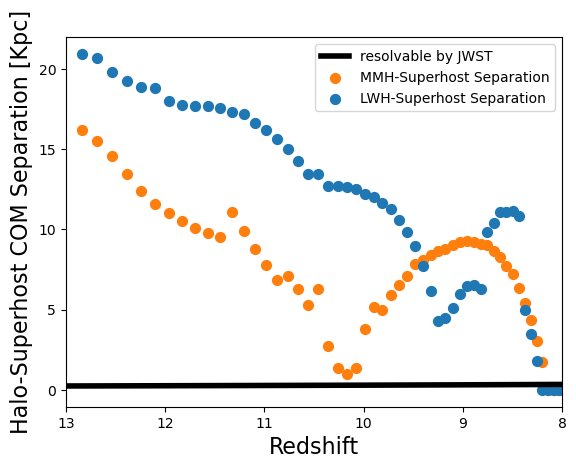

In [194]:
z = np.array(z2[lw_filt])
jwst_z   = np.arange(8,13.6, 0.5)
jwst_res = np.array([4.925, 4.739 ,4.566,4.405,4.255,4.115,3.984,3.861,3.745,3.636,3.534,3.437 ])*.696/10

fig = plt.figure()
ax = plt.axes()
ax.set_xticks(range(0,30,1))

plt.xlim(13,8)
plt.xlabel("Redshift")
plt.ylabel(r"Halo-Superhost COM Separation [Kpc]")
plt.plot(jwst_z, jwst_res, label = "resolvable by JWST", lw=4,c="black")
plt.scatter(z, sep_mm, c="tab:orange",label = "MMH-Superhost Separation", s=50)
plt.scatter(z, sep_lw, c="tab:blue",label = "LWH-Superhost Separation", s=50)
plt.legend()
plt.savefig("figures/halo_parent_COM_sep.pdf",bbox_inches='tight')

### Halo Mass vs Z 

In [21]:
mm_seed_z = 16.4
lw_seed_z = 15.3

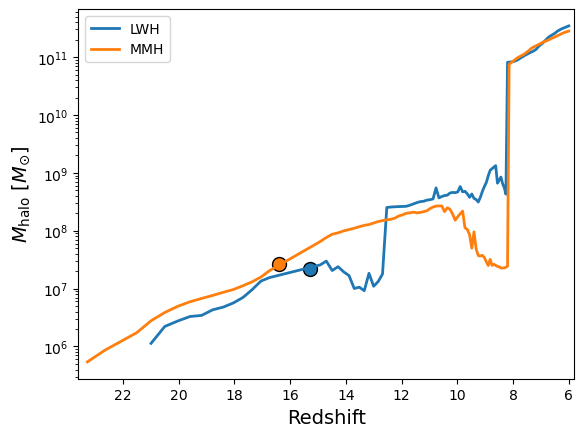

In [86]:
fig = plt.figure()
ax = plt.axes()
ax.set_xticks(range(0,30,2))

plt.yscale("log")
plt.xlim(23.6,5.8)
plt.xlabel("Redshift")
plt.ylabel(r"$M_{\rm halo} \ [M_{\odot}]$")
plt.plot(lw_z, lw_mass, label = "LWH", lw=2)
plt.plot(mm_z, mm_mass, label = "MMH", lw=2)
plt.scatter(lw_seed_z, lw_mass[14]+1e6,c="tab:blue", edgecolors="black", s=100)
plt.scatter(mm_seed_z, mm_mass[15]+0.6e7,c="tab:orange", edgecolors="black", s=100)
plt.legend()
plt.savefig("figures/halo_mass_vs_z_full.pdf",bbox_inches='tight')

### Stellar Mass vs Z

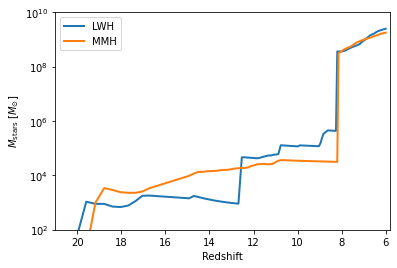

In [28]:
plt.figure()
ax = plt.axes()
ax.set_xticks(range(0,30,2))
ax.set_yticks([1e3,1e4,1e5,1e6,1e7,1e8,1e9])

plt.yscale("log")
plt.xlim(21,5.8)
plt.ylim(1e2,1e10)
plt.xlabel("Redshift")
plt.ylabel(r"$M_{\rm stars} \ [M_{\odot}]$")
plt.plot(lw_z, calc_mass_beh_2019(lw_mass, lw_z) , label = "LWH", lw=2)
plt.plot(mm_z, calc_mass_beh_2019(mm_mass, mm_z), label = "MMH", lw=2)
plt.legend()
plt.savefig("figures/stellar_mass_vs_z_beh_2019_mpeak.pdf",bbox_inches='tight')

<ipython-input-62-66c5ecaa7130>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-62-66c5ecaa7130>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))


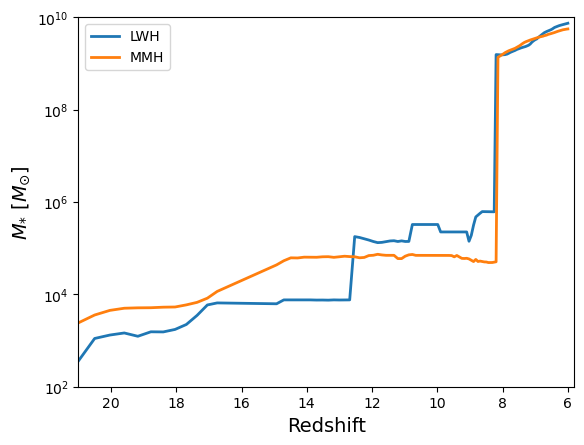

In [88]:
plt.figure()
ax = plt.axes()
ax.set_xticks(range(0,30,2))
ax.set_yticks([1e3,1e4,1e5,1e6,1e7,1e8,1e9])

plt.yscale("log")
plt.xlim(21,5.8)
plt.ylim(1e2,1e10)
plt.xlabel("Redshift")
plt.ylabel(r"$M_{*} \ [M_{\odot}]$")
plt.plot(lw_z, calc_mass_beh_2013(lw_mass, lw_z) , label = "LWH", lw=2)
plt.plot(mm_z, calc_mass_beh_2013(mm_mass, mm_z), label = "MMH", lw=2)
plt.legend()
plt.savefig("figures/stellar_mass_vs_z_beh_2013.pdf",bbox_inches='tight')

<ipython-input-62-66c5ecaa7130>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-62-66c5ecaa7130>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))


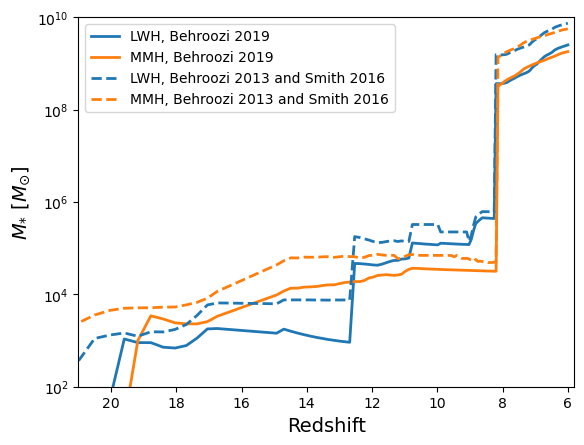

In [89]:
plt.figure()
ax = plt.axes()
ax.set_xticks(range(0,30,2))
ax.set_yticks([1e3,1e4,1e5,1e6,1e7,1e8,1e9])

plt.yscale("log")
plt.xlim(21,5.8)
plt.ylim(1e2,1e10)
plt.xlabel("Redshift")
plt.ylabel(r"$M_{*} \ [M_{\odot}]$")
plt.plot(lw_z, calc_mass_beh_2019(lw_mass, lw_z) , c="tab:blue", label = "LWH, Behroozi 2019", lw=2)
plt.plot(mm_z, calc_mass_beh_2019(mm_mass, mm_z), c="tab:orange", label = "MMH, Behroozi 2019", lw=2)
plt.plot(lw_z, calc_mass_beh_2013(lw_mass, lw_z) , c="tab:blue", label = "LWH, Behroozi 2013 and Smith 2016 ", lw=2, ls="--")
plt.plot(mm_z, calc_mass_beh_2013(mm_mass, mm_z), c="tab:orange", label = "MMH, Behroozi 2013 and Smith 2016", lw=2, ls ="--")
plt.legend()
plt.savefig("figures/stellar_mass_vs_z_comparison.pdf",bbox_inches='tight')

<ipython-input-62-66c5ecaa7130>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))
<ipython-input-62-66c5ecaa7130>:30: RuntimeWarning: overflow encountered in exp
  b = b/(1+np.exp(np.power(10, -x)))


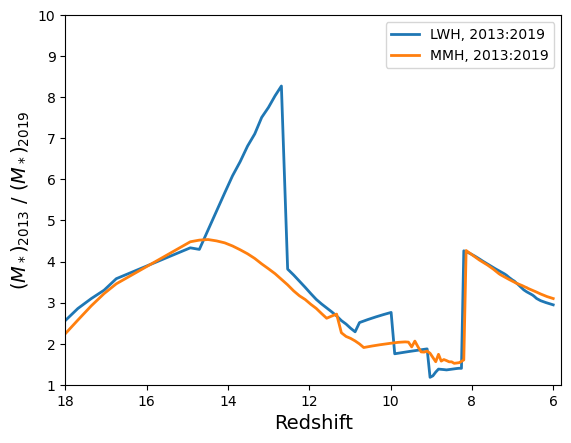

In [90]:
plt.figure()
ax = plt.axes()
ax.set_xticks(range(0,30,2))
#ax.set_yticks([1e3,1e4,1e5,1e6,1e7,1e8,1e9])

plt.xlim(18,5.8)
plt.ylim(1,10)
plt.xlabel("Redshift")
plt.ylabel(r"$(M_*)_{2013} \ / \ (M_*)_{2019}$")
plt.plot(lw_z, calc_mass_beh_2013(lw_mass, lw_z)/ calc_mass_beh_2019(lw_mass, lw_z) , c="tab:blue", label = "LWH, 2013:2019", lw=2)
plt.plot(mm_z, calc_mass_beh_2013(mm_mass, mm_z)/ calc_mass_beh_2019(mm_mass, mm_z), c="tab:orange", label = "MMH, 2013:2019", lw=2)
plt.legend()
plt.savefig("figures/stellar_mass_vs_z_comparison_ratios.pdf",bbox_inches='tight')

### BH mass vs Z

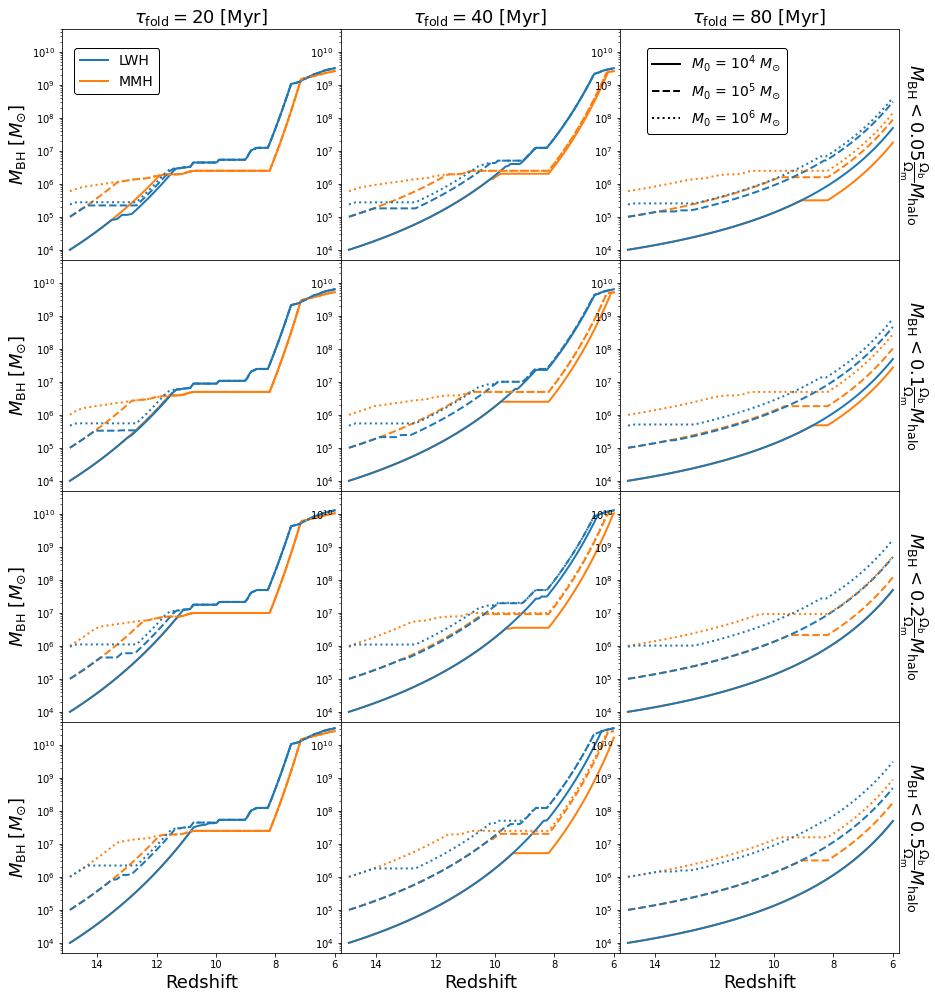

In [69]:
cap_list = [0.05,0.1,0.2,0.5]
seed_list = [1e4,1e5,1e6]
folding_list = [20,40,80]
mm_bh_indices = np.where(np.array(mm_z) < mm_seed_z)
lw_bh_indices = np.where(np.array(lw_z) < lw_seed_z)
x_num = len(folding_list)
y_num = len(cap_list)

fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=False, figsize=(15,17))
for axis in axs.ravel(): 
    axis.set_yscale('log')
    axis.set_ylim(5e3,5e10)
#axs.yscale("log")
plt.xlim(15+0.2,5.8)

for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap = evolve_BH(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass, lw_cap = evolve_BH(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            axs[row,col].plot(np.array(mm_z)[mm_bh_indices], mm_bh_mass, c="tab:orange", linestyle = ls, lw=2)
            axs[row,col].plot(np.array(lw_z)[lw_bh_indices], lw_bh_mass, c="tab:blue", linestyle = ls, lw=2)
            
        if(row==0): axs[row,col].set_title(r"$\tau_{\rm fold} = $" +str(folding_list[col]) +" [Myr]", fontsize = 18 )
        if(col == x_num-1):
            axs[row, col].yaxis.set_label_position("right")
            axs[row, col].set_ylabel(r"$M_{\rm BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_{\rm b}}{\Omega_{\rm m}} M_{\rm halo}$", fontsize = 18, rotation=270, labelpad=30)
        if(col == 0): axs[row, col].set_ylabel(r"$M_{\rm BH} \ [M_{\odot}]$", fontsize = 18 )
        axs[row,col].set_xlabel("Redshift", fontsize = 18 )

            
lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
fig.legend((lines1), ('LWH', 'MMH'), loc='upper left', fontsize = 14, bbox_to_anchor=(0.13, 0.87),edgecolor="black", framealpha=1) 
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper left', fontsize = 14 , bbox_to_anchor=(0.66, 0.87),edgecolor="black", framealpha=1)       


plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z.pdf",bbox_inches='tight')

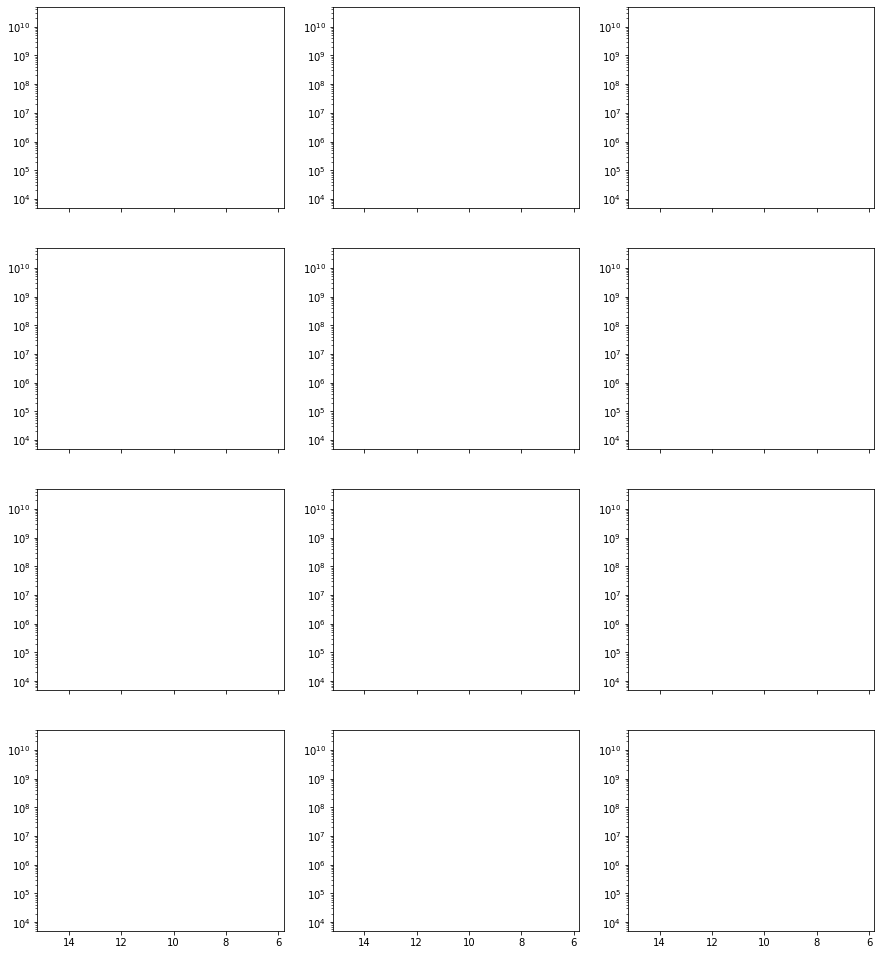

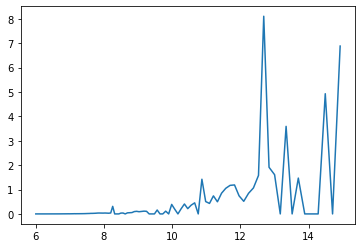

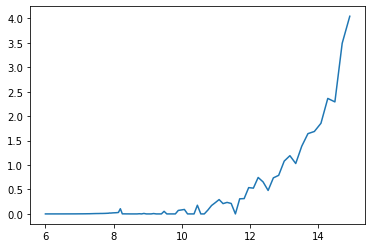

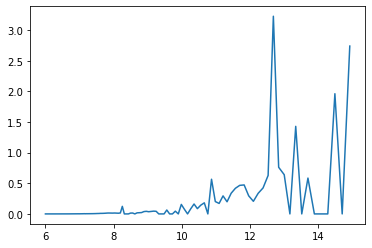

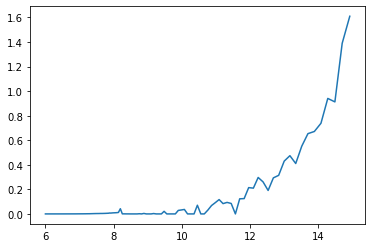

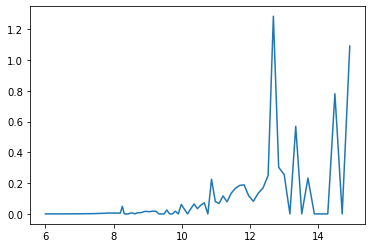

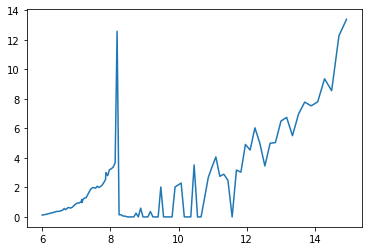

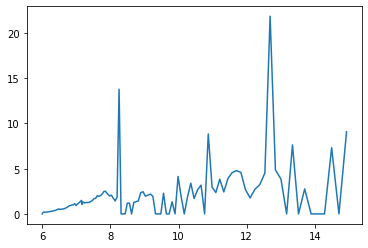

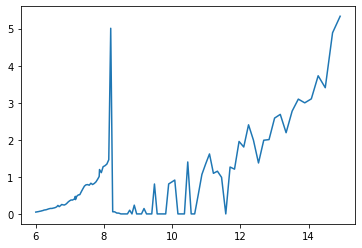

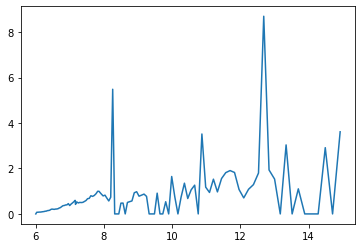

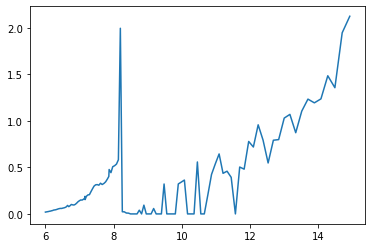

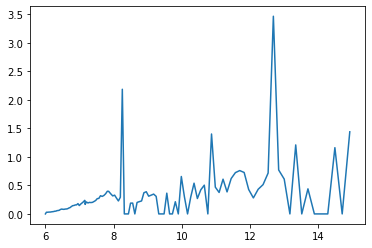

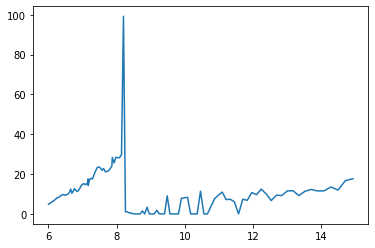

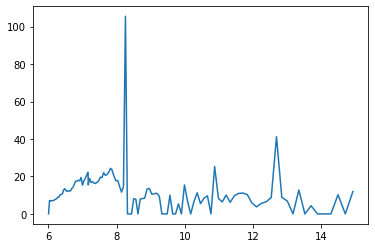

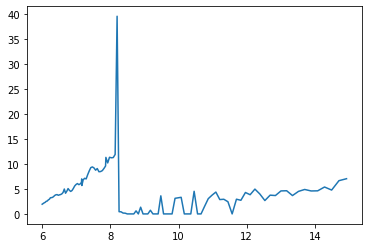

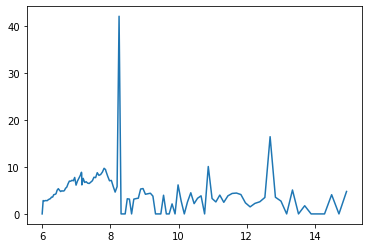

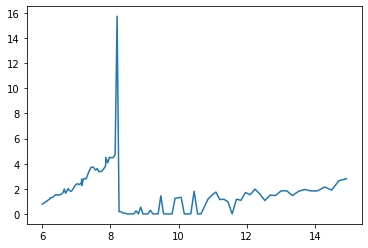

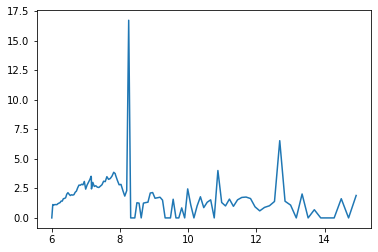

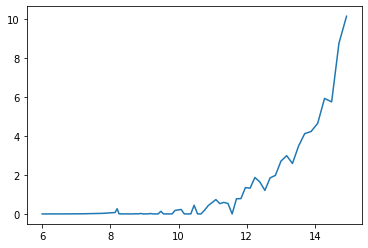

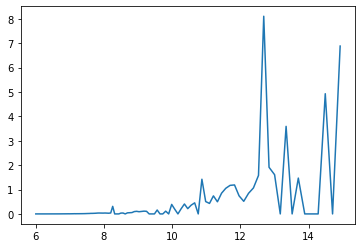

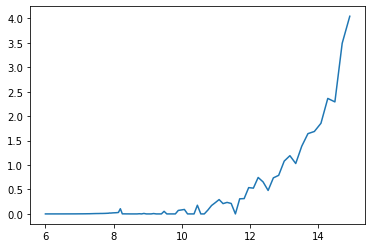

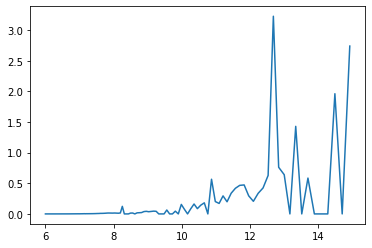

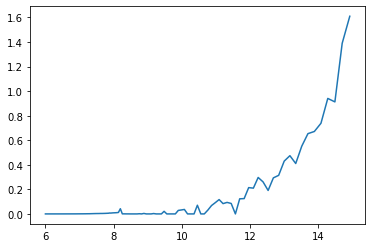

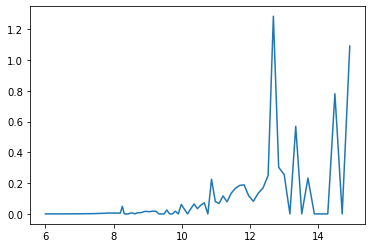

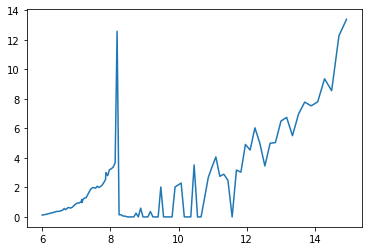

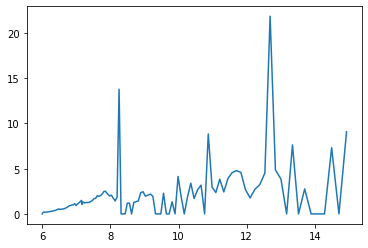

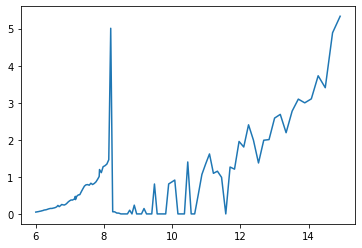

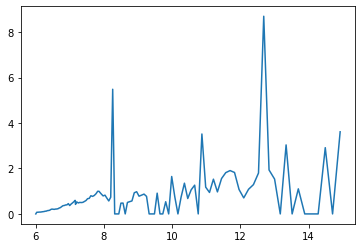

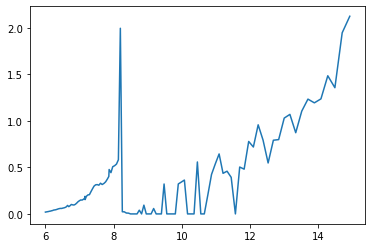

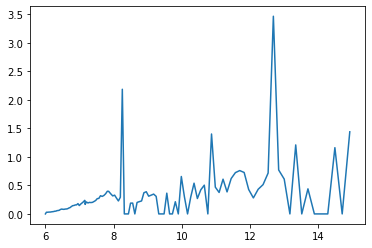

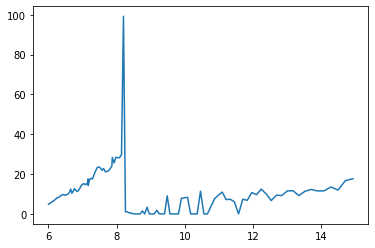

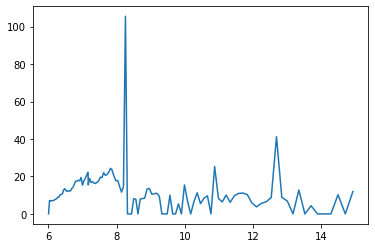

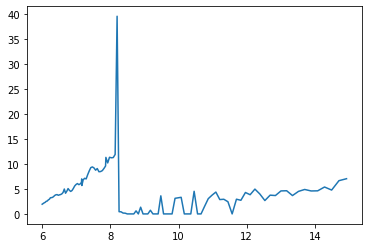

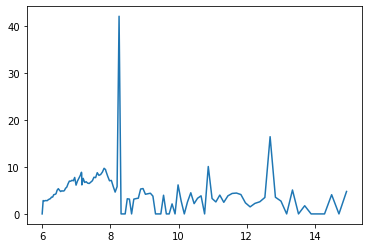

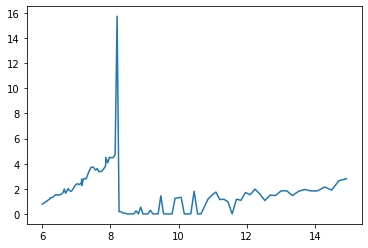

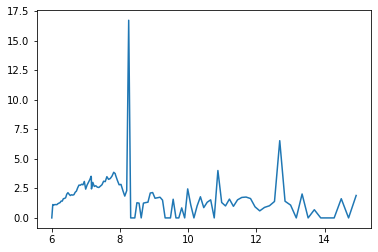

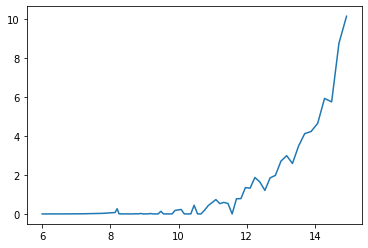

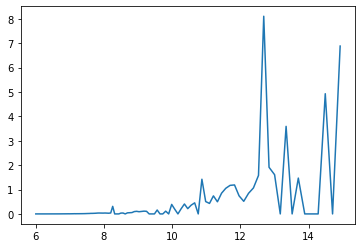

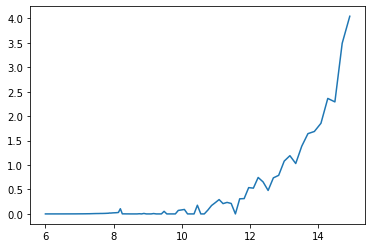

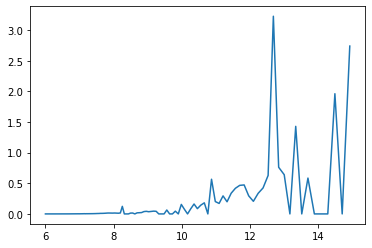

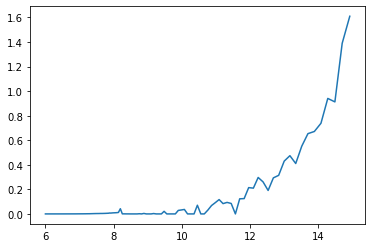

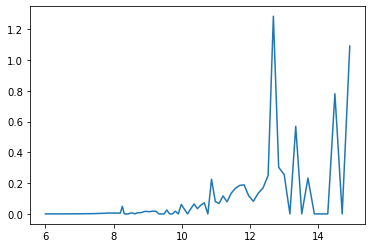

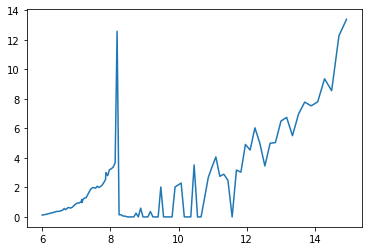

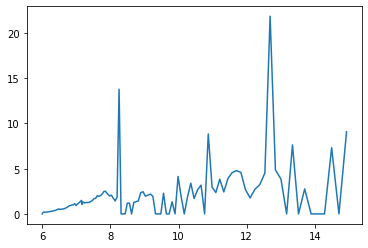

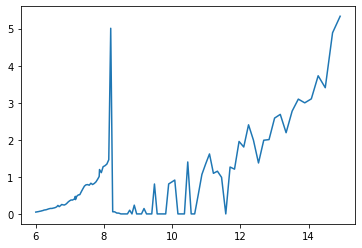

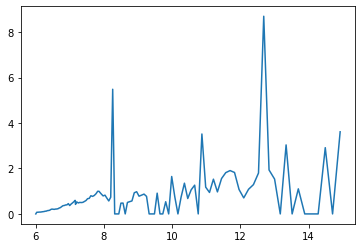

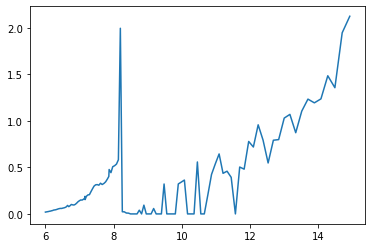

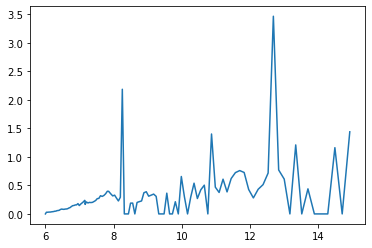

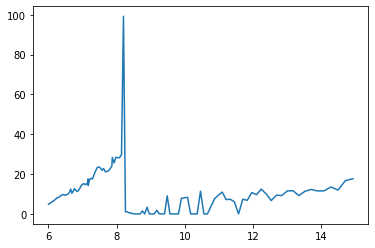

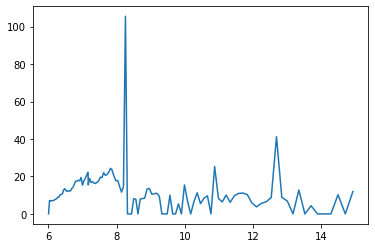

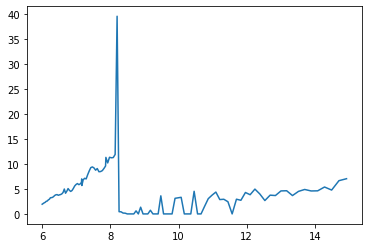

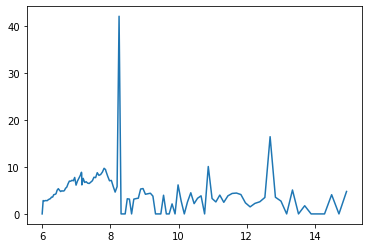

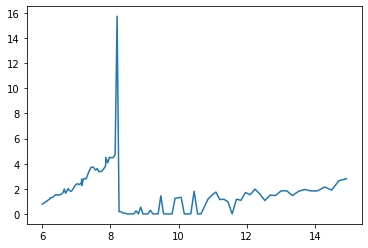

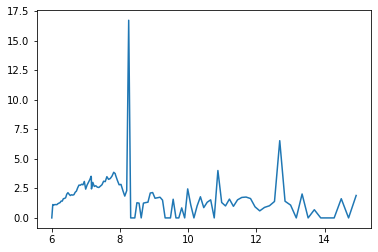

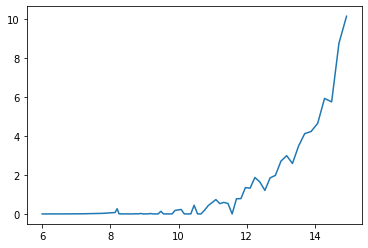

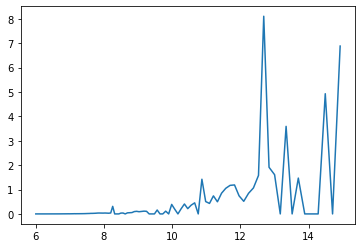

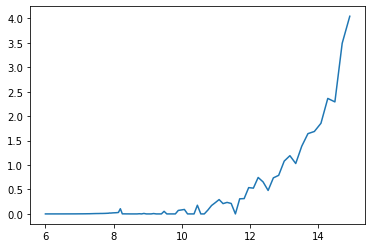

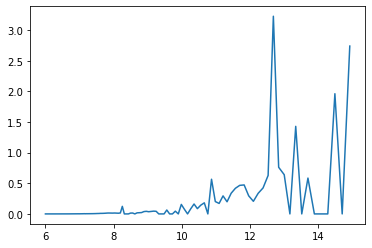

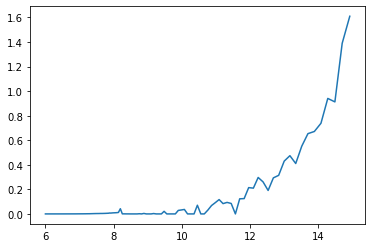

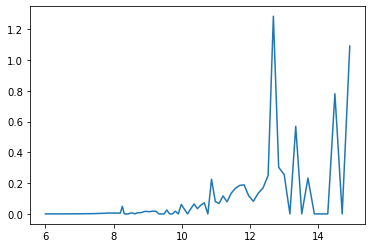

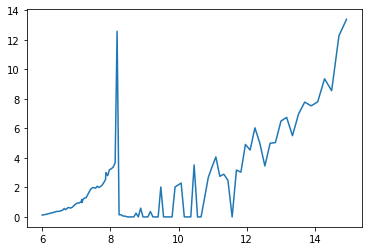

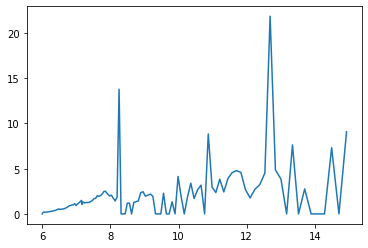

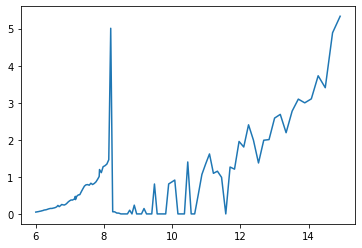

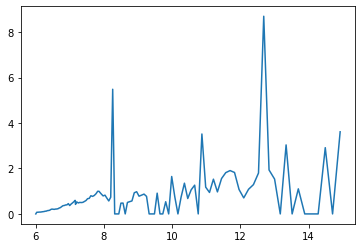

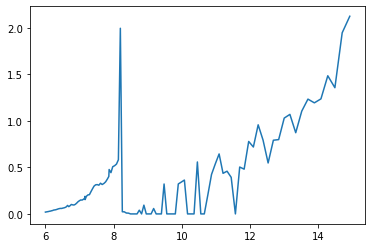

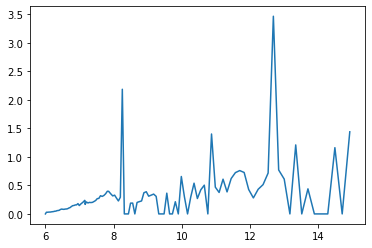

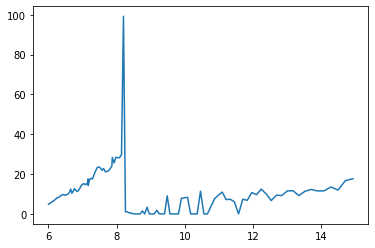

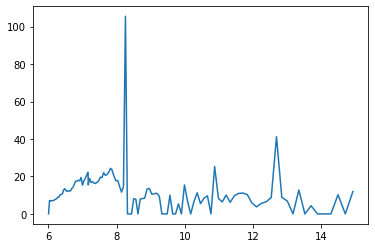

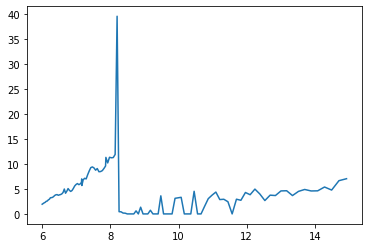

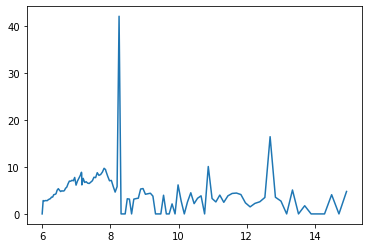

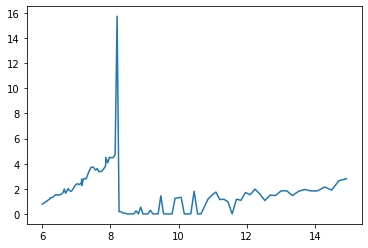

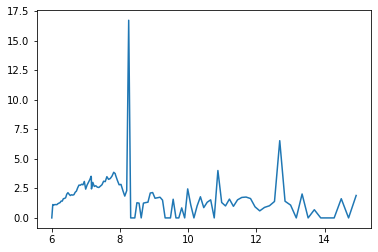

<Figure size 432x288 with 0 Axes>

In [85]:
cap_list = [0.05,0.1,0.2,0.5]
seed_list = [1e4,1e5,1e6]
folding_list = [20,40,80]
mm_bh_indices = np.where(np.array(mm_z) < mm_seed_z)
lw_bh_indices = np.where(np.array(lw_z) < lw_seed_z)
x_num = len(folding_list)
y_num = len(cap_list)

fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=False, figsize=(15,17))
for axis in axs.ravel(): 
    axis.set_yscale('log')
    axis.set_ylim(5e3,5e10)
#axs.yscale("log")
plt.xlim(15+0.2,5.8)

for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap = evolve_BH2(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass, lw_cap = evolve_BH2(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            axs[row,col].plot(np.array(mm_z)[mm_bh_indices], mm_bh_mass, c="tab:orange", linestyle = ls, lw=2)
            axs[row,col].plot(np.array(lw_z)[lw_bh_indices], lw_bh_mass, c="tab:blue", linestyle = ls, lw=2)
            
        if(row==0): axs[row,col].set_title(r"$\tau_{\rm fold} = $" +str(folding_list[col]) +" [Myr]", fontsize = 18 )
        if(col == x_num-1):
            axs[row, col].yaxis.set_label_position("right")
            axs[row, col].set_ylabel(r"$M_{\rm BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_{\rm b}}{\Omega_{\rm m}} M_{\rm halo}$", fontsize = 18, rotation=270, labelpad=30)
        if(col == 0): axs[row, col].set_ylabel(r"$M_{\rm BH} \ [M_{\odot}]$", fontsize = 18 )
        axs[row,col].set_xlabel("Redshift", fontsize = 18 )

            
lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
fig.legend((lines1), ('LWH', 'MMH'), loc='upper left', fontsize = 14, bbox_to_anchor=(0.13, 0.87),edgecolor="black", framealpha=1) 
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper left', fontsize = 14 , bbox_to_anchor=(0.66, 0.87),edgecolor="black", framealpha=1)       


plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z_super.pdf",bbox_inches='tight')

### M_bh/M_stars vs Z

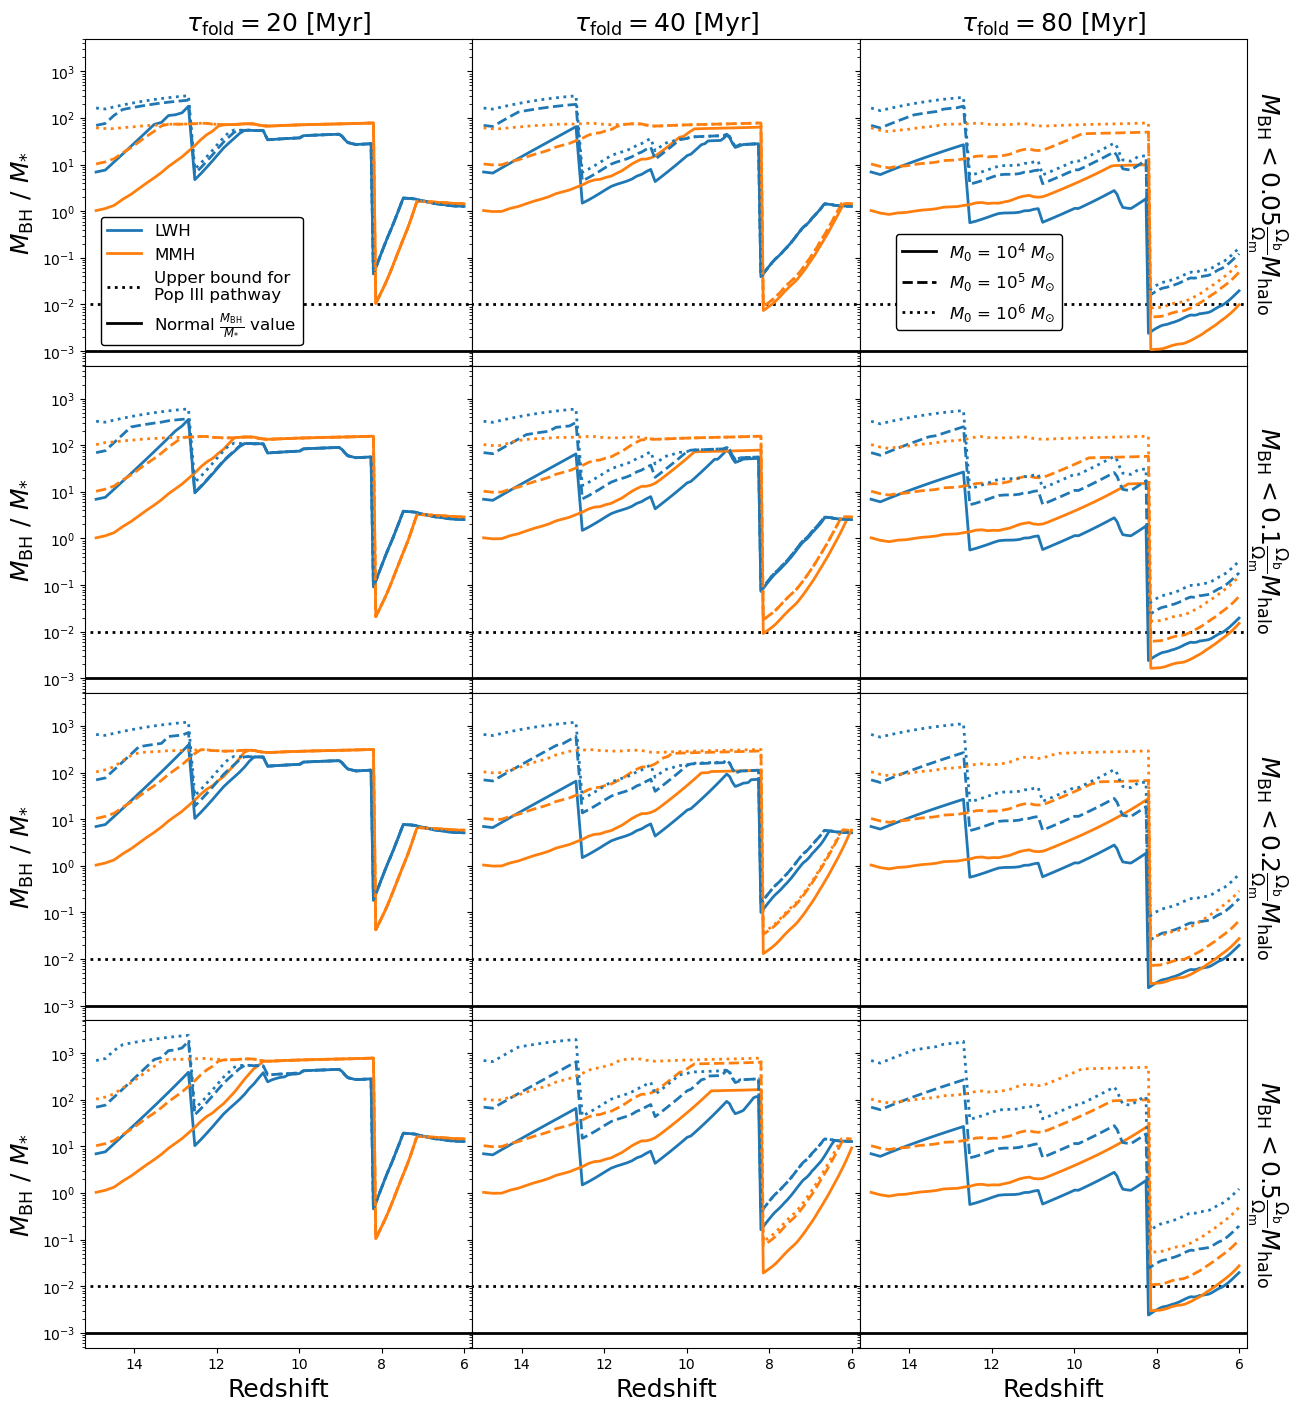

In [168]:

fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=True, figsize=(15,17))
# for axis in axs.ravel(): 
#     axis.set_yscale('log')
#     axis.set_ylim(5e-4,5e3)
plt.yscale("log")
plt.xlim(15+0.2,5.8)


for row in range(y_num):
    for col in range(x_num):
        axs[row, col].plot(np.linspace(5,20,40), np.linspace(1e-3,1e-3,40), c="black", lw=2)
        axs[row, col].plot(np.linspace(5,20,40), np.linspace(1e-2,1e-2,40), c="black", linestyle=":", lw=2)
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap = evolve_BH(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass, lw_cap = evolve_BH(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            lw_stellar_mass = calc_mass_beh_2019(lw_mass, lw_z)
            mm_stellar_mass = calc_mass_beh_2019(mm_mass, mm_z)
            axs[row, col].plot(np.array(lw_z)[lw_bh_indices], np.array(lw_bh_mass)/np.array(lw_stellar_mass)[lw_bh_indices], c="tab:blue", linestyle=ls, lw=2)
            axs[row, col].plot(np.array(mm_z)[mm_bh_indices], np.array(mm_bh_mass)/np.array(mm_stellar_mass)[mm_bh_indices], c="tab:orange", linestyle = ls, lw=2)
        if(row == 0): axs[row, col].set_title(r"$\tau_{\rm fold} = $" +str(folding_list[col]) +" [Myr]", fontsize = 18 )
        if(col == x_num-1):
            axs[row, col].yaxis.set_label_position("right")
            axs[row, col].set_ylabel(r"$M_{\rm BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_{\rm b}}{\Omega_{\rm m}} M_{\rm halo}$", fontsize = 18, rotation=270, labelpad=30)
        if(col == 0): axs[row, col].set_ylabel(r"$M_{\rm BH} \ / \ M_{*}$", fontsize = 18 )        
        if(row == y_num-1): axs[row, col].set_xlabel("Redshift", fontsize = 18 )

        
lines1 = [Line2D([0], [0], color=c, linewidth=2, linestyle=ls) for c,ls in zip(["tab:blue", "tab:orange", "black", "black"], ["-","-",":","-"])]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
fig.legend((lines1), ('LWH', 'MMH', "Upper bound for \nPop III pathway", r"Normal $\frac{M_{\rm BH}}{M_{*}}$ value"), loc='upper left', fontsize = 12, bbox_to_anchor=(0.13, 0.78),edgecolor="black", framealpha=1) 
#fig.legend((lines1), ('LW (born at z='+str(lw_seed_z)+")", 'MM (born at z='+str(mm_seed_z)+")"), loc='upper left', fontsize = 18, bbox_to_anchor=(0.14, 0.72))
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper left', fontsize = 12 , bbox_to_anchor=(0.66, 0.77),edgecolor="black", framealpha=1)       
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_over_M_stars_vs_z.pdf",bbox_inches='tight')

# Trying to get an image of the host halo during stripping from z=11-8


In [169]:
mm_mass = [541340.0, 861230.0, 1230300.0, 1722500.0, 2780500.0, 3863200.0, 4945900.0, 5930200.0, 6766800.0, 7628000.0, 8636900.0, 9645800.0, 11221000.0, 13115000.0, 15871000.0, 20350000.0, 64814000.0, 76280000.0, 86935000.0, 91979000.0, 99287000.0, 104630000.0, 110340000.0, 117500000.0, 123840000.0, 127900000.0, 135780000.0, 144150000.0, 149210000.0, 155050000.0, 157730000.0, 165530000.0, 180100000.0, 188410000.0, 200100000.0, 204190000.0, 209480000.0, 203320000.0, 207190000.0, 213760000.0, 220500000.0, 241090000.0, 256550000.0, 266390000.0, 268240000.0, 267990000.0, 214000000.0, 249190000.0, 235160000.0, 193785000.0, 152410000.0, 174383300.0, 196356700.0, 218330000.0, 112430000.0, 105220000.0, 85803000.0, 49976000.0, 95695000.0, 48376000.0, 37254000.0, 36516000.0, 37673000.0, 34203000.0, 29060000.0, 25000000.0, 32013000.0, 25172000.0, 26280000.0, 25222000.0, 24090000.0, 23893000.0, 22638000.0, 22687000.0, 22761000.0, 23499000.0, 24434000.0, 75017000000.0, 78981000000.0, 82722000000.0, 86786000000.0, 91149000000.0, 94826000000.0, 95746000000.0, 98578000000.0, 101790000000.0, 104830000000.0, 107940000000.0, 111260000000.0, 115500000000.0, 119740000000.0, 124860000000.0, 130700000000.0, 136770000000.0, 142220000000.0, 146830000000.0, 150580000000.0, 154870000000.0, 158590000000.0, 158850000000.0, 159660000000.0, 162670000000.0, 166150000000.0, 169670000000.0, 173770000000.0, 177870000000.0, 181760000000.0, 185090000000.0, 187990000000.0, 190840000000.0, 194270000000.0, 198680000000.0, 202340000000.0, 205390000000.0, 210680000000.0, 214630000000.0, 218230000000.0, 221750000000.0, 225400000000.0, 229160000000.0, 233470000000.0, 238100000000.0, 242730000000.0, 247050000000.0, 251060000000.0, 255260000000.0, 259650000000.0, 263360000000.0, 266940000000.0, 270080000000.0, 273260000000.0, 276010000000.0, 278710000000.0, 281150000000.0, 281300000000.0]
mm_time = [148.80977113935595, 154.7551727054681, 160.72201956215898, 166.65109675362595, 172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
mm_z = [23.277739, 22.651846, 22.06273, 21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_pos = [[13623.54, 13553.191, 12954.65], [13629.83, 13551.641, 12967.99], [13636.011, 13549.74, 12981.77], [13642.01, 13547.761, 12995.5], [13648.311, 13545.971, 13009.44], [13654.51, 13543.931, 13023.361], [13660.93, 13541.801, 13037.33], [13667.0, 13539.61, 13050.42], [13673.15, 13537.61, 13063.84], [13678.841, 13535.691, 13076.75], [13684.681, 13533.721, 13089.771], [13690.621, 13531.531, 13102.711], [13696.391, 13529.24, 13115.181], [13701.841, 13526.931, 13127.73], [13707.49, 13524.71, 13140.13], [13713.36, 13522.421, 13152.55], [13755.319, 13509.17, 13236.05], [13761.08, 13506.501, 13247.74], [13766.971, 13502.78, 13257.761], [13772.471, 13500.331, 13269.911], [13780.2295, 13498.311, 13280.421], [13784.54, 13494.991, 13290.511], [13790.74, 13493.07, 13300.541], [13796.051, 13491.951, 13310.32], [13801.091, 13489.75, 13320.221], [13806.95, 13487.26, 13330.19], [13814.241, 13485.989, 13341.35], [13823.82, 13485.211, 13351.961], [13826.5205, 13483.1, 13361.91], [13832.671, 13481.23, 13372.171], [13838.931, 13478.541, 13382.631], [13846.051, 13475.251, 13392.411], [13852.98, 13474.09, 13402.551], [13858.491, 13470.9795, 13412.28], [13865.7, 13469.341, 13422.011], [13872.461, 13466.791, 13431.561], [13879.49, 13464.521, 13440.9], [13885.67, 13460.931, 13450.32], [13892.19, 13458.48, 13459.66], [13900.111, 13455.61, 13469.25], [13906.82, 13452.51, 13478.66], [13913.761, 13449.661, 13488.101], [13920.931, 13446.34, 13497.812], [13928.561, 13442.951, 13507.24], [13936.41, 13439.4795, 13516.511], [13945.15, 13435.641, 13526.001], [13954.681, 13431.301, 13535.661], [13965.61, 13425.561, 13545.21], [13976.58, 13420.11, 13554.31], [13987.461, 13413.63, 13559.34], [13989.951, 13412.341, 13569.641], [14010.7705, 13399.971, 13575.631], [14017.951, 13395.591, 13581.94], [14024.551, 13391.791, 13588.26], [14030.49, 13388.251, 13594.931], [14035.04, 13386.091, 13601.961], [14039.61, 13383.891, 13609.041], [14043.721, 13382.301, 13615.891], [14047.261, 13381.11, 13622.63], [14050.471, 13380.32, 13629.811], [14053.251, 13379.811, 13636.72], [14055.61, 13379.69, 13643.851], [14057.58, 13380.09, 13650.57], [14059.201, 13380.391, 13657.481], [14060.551, 13381.67, 13664.5205], [14061.851, 13383.24, 13671.37], [14062.69, 13385.311, 13678.03], [14063.091, 13388.02, 13684.891], [14063.48, 13390.971, 13691.75], [14063.51, 13394.431, 13698.54], [14063.341, 13398.57, 13705.301], [14062.801, 13403.091, 13711.931], [14062.15, 13408.52, 13718.95], [14060.71, 13414.791, 13725.501], [14059.141, 13422.069, 13732.181], [14056.74, 13430.79, 13738.561], [14054.401, 13440.61, 13745.941], [14060.48, 13454.53, 13755.101], [14065.051, 13457.88, 13762.201], [14068.12, 13459.65, 13768.87], [14071.37, 13461.111, 13776.77], [14074.011, 13462.65, 13784.69], [14074.63, 13462.341, 13793.841], [14076.491, 13463.19, 13793.95], [14076.78, 13463.51, 13801.501], [14078.891, 13463.92, 13809.97], [14080.061, 13465.001, 13818.851], [14081.649, 13465.19, 13827.35], [14081.311, 13465.0205, 13837.9], [14083.83, 13465.221, 13844.591], [14083.7705, 13465.689, 13854.701], [14083.761, 13465.99, 13864.15], [14083.26, 13466.2, 13874.171], [14084.341, 13465.63, 13883.23], [14084.5, 13464.9, 13892.239], [14095.529, 13471.301, 13893.671], [14086.5205, 13462.2295, 13909.69], [14088.23, 13461.301, 13918.081], [14090.03, 13460.871, 13925.211], [14089.62, 13460.101, 13927.05], [14090.2705, 13460.37, 13927.46], [14091.12, 13459.201, 13933.91], [14092.79, 13459.2705, 13941.631], [14096.82, 13469.4, 13951.101], [14096.061, 13460.671, 13955.5205], [14097.98, 13460.95, 13962.551], [14099.57, 13462.86, 13969.17], [14100.701, 13465.3, 13977.101], [14100.971, 13467.359, 13986.69], [14106.56, 13470.58, 13990.44], [14100.811, 13473.12, 14004.44], [14101.76, 13476.941, 14013.331], [14099.701, 13475.82, 14022.55], [14093.11, 13466.39, 14031.551], [14098.32, 13475.881, 14040.471], [14097.561, 13474.46, 14049.63], [14097.2705, 13473.07, 14058.57], [14097.32, 13473.2, 14068.0205], [14098.49, 13473.69, 14076.601], [14099.961, 13473.541, 14085.07], [14101.261, 13474.58, 14094.291], [14103.051, 13475.791, 14102.67], [14104.761, 13477.45, 14111.6], [14106.37, 13478.871, 14120.58], [14108.17, 13480.78, 14129.58], [14109.53, 13482.2705, 14138.312], [14110.84, 13483.36, 14147.32], [14112.44, 13485.551, 14156.221], [14113.81, 13487.03, 14165.45], [14115.501, 13488.15, 14174.031], [14116.291, 13491.79, 14183.391], [14118.82, 13493.91, 14191.7], [14121.15, 13496.62, 14201.341], [14123.01, 13498.761, 14210.331], [14123.091, 13498.95, 14210.92]]
mm_rad = [2.144, 2.503, 2.819, 3.153, 3.699, 4.127, 4.482, 4.761, 4.975, 5.178, 5.397, 5.599, 5.889, 6.203, 6.61, 7.181, 10.502, 10.89, 11.65, 11.847, 12.179, 12.394, 12.615, 12.882, 13.11, 13.25, 13.518, 13.787, 13.84, 14.065, 14.119, 14.429, 14.831, 14.867, 15.156, 15.271, 15.416, 15.239, 15.26, 15.09, 15.133, 15.755, 15.747, 15.782, 15.365, 15.185, 14.208, 14.417, 13.588, 13.218, 12.826, 12.762, 12.697, 12.631, 10.983, 10.736, 9.918, 8.953, 9.865, 8.872, 8.5, 8.306, 8.364, 8.236, 7.937, 7.578, 7.954, 7.575, 7.652, 7.536, 7.275, 7.275, 7.105, 7.057, 6.857, 6.704, 6.121, 110.873, 112.791, 114.544, 116.388, 118.305, 119.873, 120.26, 121.433, 122.736, 123.945, 125.158, 126.426, 128.009, 129.556, 131.374, 133.389, 135.423, 137.193, 138.66, 139.829, 141.142, 142.261, 142.338, 142.58, 143.469, 144.482, 145.494, 146.655, 147.796, 148.864, 149.764, 150.541, 151.296, 152.195, 153.334, 154.268, 155.038, 156.354, 157.323, 158.194, 159.039, 159.905, 160.785, 161.786, 162.846, 163.89, 164.854, 165.74, 166.656, 167.603, 168.395, 169.152, 169.809, 170.469, 171.037, 171.589, 172.086, 172.115]
mm_tforce = [0.05651, 0.06533, 0.06987, 0.11627, 0.1239, 0.11384, 0.13591, 0.14901, 0.15361, 0.16428, 0.17434, 0.18775, 0.19413, 0.21015, 0.22637, 0.2535, 0.23572, 0.25516, 0.25351, 0.28555, 0.32018, 0.32184, 0.28095, 0.29294, 0.30664, 0.33046, 0.33252, 0.35734, 0.37146, 0.40654, 0.46308, 0.49332, 0.47857, 0.5659, 0.50524, 0.5936, 0.67406, 0.81269, 0.72398, 0.80167, 0.8169, 1.07786, 1.32233, 1.59768, 1.77301, 2.0298, 2.35823, 3.27054, 4.86138, 5.68795, 4.93198, 2.73607, 2.21637, 2.31732, 2.07117, 1.96389, 1.88409, 1.78291, 1.76178, 1.7404, 1.72068, 1.71519, 1.70252, 1.70123, 1.72108, 1.76792, 1.84077, 1.87632, 1.95924, 2.05447, 2.18583, 2.35829, 2.5975, 3.03877, 3.57521, 4.58045, 6.37613, 0.11763, 0.11821, 0.11889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17544, 0.17859, 0.18196, 0.18624, 0.18888, 0.18969, 0.18906, 0.18847, 0.18652, 0.18438, 0.18474, 0.18543, 0.18815, 0.19005, 0.19742, 0.19421, 0.19554, 0.20027, 0.1979, 0.1991, 0.19989, 0.19796, 0.20195, 0.20285, 0.20405, 0.20592, 0.2069, 0.20621]
mm_pos_cm = [[5.9208242e+25, 5.89025e+25, 5.630123e+25], [5.923558e+25, 5.8895764e+25, 5.6359207e+25], [5.926244e+25, 5.8887504e+25, 5.641909e+25], [5.9288513e+25, 5.8878903e+25, 5.647876e+25], [5.9315893e+25, 5.8871124e+25, 5.653935e+25], [5.934284e+25, 5.8862255e+25, 5.659985e+25], [5.937074e+25, 5.8853e+25, 5.666056e+25], [5.939712e+25, 5.884348e+25, 5.6717448e+25], [5.942385e+25, 5.883479e+25, 5.677577e+25], [5.9448576e+25, 5.8826445e+25, 5.6831877e+25], [5.947396e+25, 5.8817886e+25, 5.6888467e+25], [5.949978e+25, 5.8808368e+25, 5.6944702e+25], [5.952485e+25, 5.879841e+25, 5.69989e+25], [5.954854e+25, 5.878837e+25, 5.705344e+25], [5.957309e+25, 5.8778724e+25, 5.710733e+25], [5.9598603e+25, 5.876877e+25, 5.716131e+25], [5.978096e+25, 5.8711186e+25, 5.75242e+25], [5.9805995e+25, 5.8699587e+25, 5.7575005e+25], [5.983159e+25, 5.8683414e+25, 5.7618557e+25], [5.9855497e+25, 5.867277e+25, 5.767136e+25], [5.988922e+25, 5.866399e+25, 5.771704e+25], [5.990795e+25, 5.8649564e+25, 5.776089e+25], [5.9934897e+25, 5.8641217e+25, 5.7804477e+25], [5.9957973e+25, 5.863635e+25, 5.7846983e+25], [5.997988e+25, 5.8626787e+25, 5.7890006e+25], [6.0005345e+25, 5.8615964e+25, 5.7933337e+25], [6.003703e+25, 5.8610443e+25, 5.7981834e+25], [6.0078666e+25, 5.860706e+25, 5.802795e+25], [6.00904e+25, 5.8597886e+25, 5.807119e+25], [6.0117127e+25, 5.858976e+25, 5.8115785e+25], [6.0144336e+25, 5.857807e+25, 5.816124e+25], [6.0175276e+25, 5.8563773e+25, 5.820375e+25], [6.0205395e+25, 5.855873e+25, 5.8247813e+25], [6.0229343e+25, 5.854521e+25, 5.82901e+25], [6.0260675e+25, 5.8538086e+25, 5.8332386e+25], [6.0290056e+25, 5.8527004e+25, 5.837389e+25], [6.032061e+25, 5.851714e+25, 5.8414484e+25], [6.0347463e+25, 5.850154e+25, 5.8455426e+25], [6.03758e+25, 5.8490885e+25, 5.8496014e+25], [6.0410228e+25, 5.8478415e+25, 5.8537694e+25], [6.0439383e+25, 5.846494e+25, 5.857859e+25], [6.046955e+25, 5.8452558e+25, 5.8619616e+25], [6.050071e+25, 5.8438123e+25, 5.866182e+25], [6.0533867e+25, 5.84234e+25, 5.87028e+25], [6.056798e+25, 5.8408313e+25, 5.874309e+25], [6.060597e+25, 5.8391623e+25, 5.878433e+25], [6.064739e+25, 5.837276e+25, 5.8826316e+25], [6.069489e+25, 5.8347817e+25, 5.8867817e+25], [6.0742564e+25, 5.832413e+25, 5.8907367e+25], [6.078985e+25, 5.8295963e+25, 5.8929226e+25], [6.080067e+25, 5.8290365e+25, 5.897399e+25], [6.0891153e+25, 5.82366e+25, 5.9000025e+25], [6.092236e+25, 5.8217565e+25, 5.9027446e+25], [6.0951045e+25, 5.8201055e+25, 5.9054913e+25], [6.0976856e+25, 5.8185666e+25, 5.90839e+25], [6.099663e+25, 5.817628e+25, 5.9114455e+25], [6.1016494e+25, 5.816672e+25, 5.914523e+25], [6.1034355e+25, 5.815981e+25, 5.9174997e+25], [6.104974e+25, 5.815464e+25, 5.9204286e+25], [6.106369e+25, 5.8151202e+25, 5.9235493e+25], [6.1075777e+25, 5.8148984e+25, 5.926552e+25], [6.108603e+25, 5.8148463e+25, 5.929651e+25], [6.1094593e+25, 5.81502e+25, 5.9325716e+25], [6.1101635e+25, 5.8151507e+25, 5.9355747e+25], [6.1107496e+25, 5.815707e+25, 5.938634e+25], [6.111315e+25, 5.816389e+25, 5.9416114e+25], [6.11168e+25, 5.8172887e+25, 5.9445057e+25], [6.111854e+25, 5.8184665e+25, 5.947487e+25], [6.1120234e+25, 5.819749e+25, 5.9504686e+25], [6.1120363e+25, 5.821253e+25, 5.953419e+25], [6.1119625e+25, 5.823052e+25, 5.9563577e+25], [6.1117277e+25, 5.825016e+25, 5.9592387e+25], [6.1114455e+25, 5.827376e+25, 5.9622898e+25], [6.1108192e+25, 5.8301013e+25, 5.9651365e+25], [6.110137e+25, 5.8332645e+25, 5.9680396e+25], [6.109094e+25, 5.8370543e+25, 5.970812e+25], [6.1080776e+25, 5.8413225e+25, 5.97402e+25], [6.1107196e+25, 5.847372e+25, 5.978001e+25], [6.1127054e+25, 5.848828e+25, 5.9810865e+25], [6.1140396e+25, 5.849597e+25, 5.983985e+25], [6.115452e+25, 5.8502322e+25, 5.987418e+25], [6.1165995e+25, 5.850901e+25, 5.9908605e+25], [6.116869e+25, 5.8507663e+25, 5.994837e+25], [6.1176777e+25, 5.8511357e+25, 5.994885e+25], [6.1178036e+25, 5.8512745e+25, 5.9981664e+25], [6.1187204e+25, 5.851453e+25, 6.001847e+25], [6.119229e+25, 5.8519224e+25, 6.0057065e+25], [6.11992e+25, 5.852005e+25, 6.0094004e+25], [6.1197724e+25, 5.851931e+25, 6.013986e+25], [6.120867e+25, 5.8520183e+25, 6.016893e+25], [6.1208414e+25, 5.852222e+25, 6.021287e+25], [6.120837e+25, 5.8523527e+25, 6.025394e+25], [6.1206195e+25, 5.852444e+25, 6.029749e+25], [6.121089e+25, 5.852196e+25, 6.0336865e+25], [6.1211586e+25, 5.851879e+25, 6.037602e+25], [6.125952e+25, 5.8546604e+25, 6.0382235e+25], [6.1220367e+25, 5.8507183e+25, 6.0451857e+25], [6.1227797e+25, 5.8503143e+25, 6.048832e+25], [6.123562e+25, 5.8501276e+25, 6.051931e+25], [6.123384e+25, 5.8497927e+25, 6.05273e+25], [6.123666e+25, 5.8499103e+25, 6.0529085e+25], [6.1240354e+25, 5.8494017e+25, 6.055712e+25], [6.1247613e+25, 5.849432e+25, 6.059067e+25], [6.126513e+25, 5.8538344e+25, 6.063183e+25], [6.1261826e+25, 5.850041e+25, 6.0651036e+25], [6.127017e+25, 5.850162e+25, 6.068159e+25], [6.127708e+25, 5.8509922e+25, 6.0710356e+25], [6.1281993e+25, 5.8520525e+25, 6.0744824e+25], [6.128317e+25, 5.8529476e+25, 6.07865e+25], [6.130746e+25, 5.8543472e+25, 6.08028e+25], [6.128247e+25, 5.8554513e+25, 6.0863644e+25], [6.1286596e+25, 5.857112e+25, 6.0902285e+25], [6.127765e+25, 5.856625e+25, 6.0942347e+25], [6.1249006e+25, 5.852526e+25, 6.0981463e+25], [6.127165e+25, 5.856651e+25, 6.1020234e+25], [6.1268342e+25, 5.8560337e+25, 6.1060037e+25], [6.126709e+25, 5.8554296e+25, 6.1098895e+25], [6.12673e+25, 5.855486e+25, 6.1139962e+25], [6.1272387e+25, 5.8556994e+25, 6.1177252e+25], [6.1278774e+25, 5.855634e+25, 6.1214063e+25], [6.128443e+25, 5.856086e+25, 6.1254134e+25], [6.129221e+25, 5.856612e+25, 6.1290552e+25], [6.1299637e+25, 5.8573333e+25, 6.132936e+25], [6.1306633e+25, 5.8579504e+25, 6.136839e+25], [6.1314455e+25, 5.8587805e+25, 6.14075e+25], [6.1320367e+25, 5.859428e+25, 6.144545e+25], [6.132606e+25, 5.859902e+25, 6.1484603e+25], [6.133301e+25, 5.8608534e+25, 6.1523286e+25], [6.1338966e+25, 5.8614967e+25, 6.15634e+25], [6.1346317e+25, 5.8619833e+25, 6.160069e+25], [6.134975e+25, 5.863565e+25, 6.1641363e+25], [6.136074e+25, 5.8644865e+25, 6.1677477e+25], [6.137087e+25, 5.8656643e+25, 6.1719375e+25], [6.137895e+25, 5.8665945e+25, 6.175845e+25], [6.13793e+25, 5.866677e+25, 6.176101e+25]]
mm_oids = [16320, 9132, 8391, 29644, 25872, 23374, 20473, 4240, 3650, 12300, 10584, 8542, 7275, 991, 677, 692, 484, 17664, 18771, 20018, 21101, 22002, 23168, 24365, 25147, 26482, 27433, 28581, 29537, 29834, 30849, 31670, 31926, 33119, 33886, 95435, 103072, 36812, 103016, 37685, 38316, 112512, 39757, 117540, 40994, 41669, 41922, 43204, 43647, 155133, 44961, 157325, 157845, 45811, 46187, 47518, 46868, 47207, 40362, 40633, 41165, 41362, 41606, 41710, 41715, 42113, 42058, 42541, 42551, 42655, 42906, 42852, 43222, 43371, 43422, 43561, 51190, 127709, 132236, 129983, 144965, 163496, 109009, 125490, 119600, 116652, 131983, 165648, 165826, 130082, 162710, 162968, 159966, 51316, 57954, 60498, 44047, 43669, 59183, 46113, 54598, 62546, 66413, 60424, 73997, 51759, 160537, 159916, 55718, 151243, 43078, 43027, 43319, 157556, 159993, 159474, 159304, 158902, 158107, 156935, 157795, 155677, 157677, 156657, 155041, 155838, 155886, 155494, 155293, 154588, 153914, 153530, 153060, 152755, 153149]
mm_pids = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4336676, 4514815, 4694792, 4876290, 5059504, 5244051, 5430112, 5617360, 5805997, 5995970, 6187016, 6379160, 6572876, 6767498, 6962856, 7159260, 7356174, 7554011, 7752943, 7952437, 8152256, 8352620, 8553283, 8754305, 8955699, 9157673, 9362498, 9565975, 9769559, 9973857, 10177465, 10380179, 10584396, 10788526, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
mm_mvir = [63660000.0, 20350000.0, 15870000.0, 13120000.0, 11220000.0, 9646000.0, 8637000.0, 7628000.0, 6767000.0, 5930000.0, 4946000.0, 3863000.0, 2780000.0, 1722000.0, 1230000.0, 861200.0, 541300.0, 70960000.0, 86890000.0, 91390000.0, 99290000.0, 104600000.0, 110300000.0, 117500000.0, 123800000.0, 127900000.0, 135800000.0, 144000000.0, 145700000.0, 152900000.0, 154700000.0, 165100000.0, 179300000.0, 180600000.0, 191400000.0, 195800000.0, 201400000.0, 194500000.0, 195400000.0, 188900000.0, 190600000.0, 215000000.0, 214700000.0, 216100000.0, 199500000.0, 192500000.0, 157700000.0, 164800000.0, 138000000.0, 127000000.0, 116000000.0, 114300000.0, 112500000.0, 110800000.0, 72860000.0, 68060000.0, 53670000.0, 39470000.0, 52810000.0, 38410000.0, 33780000.0, 31520000.0, 32180000.0, 30730000.0, 27510000.0, 23940000.0, 27680000.0, 23920000.0, 24660000.0, 23550000.0, 21190000.0, 21190000.0, 19730000.0, 19340000.0, 17740000.0, 16580000.0, 12620000.0, 75020000000.0, 78980000000.0, 82720000000.0, 86790000000.0, 91150000000.0, 94830000000.0, 95750000000.0, 98580000000.0, 101800000000.0, 104800000000.0, 107900000000.0, 111300000000.0, 115500000000.0, 119700000000.0, 124900000000.0, 130700000000.0, 136800000000.0, 142200000000.0, 146800000000.0, 150600000000.0, 154900000000.0, 158600000000.0, 158900000000.0, 159700000000.0, 162700000000.0, 166100000000.0, 169700000000.0, 173800000000.0, 177900000000.0, 181800000000.0, 185100000000.0, 188000000000.0, 190800000000.0, 194300000000.0, 198700000000.0, 202300000000.0, 205400000000.0, 210700000000.0, 214600000000.0, 218200000000.0, 221800000000.0, 225400000000.0, 229200000000.0, 233500000000.0, 238100000000.0, 242700000000.0, 247000000000.0, 251100000000.0, 255300000000.0, 259600000000.0, 263400000000.0, 266900000000.0, 270100000000.0, 273300000000.0, 276000000000.0, 278700000000.0, 281100000000.0, 281300000000.0]
mm_pos_cl =[[0.47970212, 0.47722504, 0.45614967], [0.4799236, 0.47717044, 0.45661938], [0.48014122, 0.47710353, 0.45710456], [0.48035246, 0.47703382, 0.45758802], [0.4805743, 0.4769708, 0.4580789], [0.4807926, 0.47689897, 0.45856905], [0.48101866, 0.47682396, 0.4590609], [0.4812324, 0.47674686, 0.45952183], [0.48144895, 0.47667643, 0.45999438], [0.4816493, 0.47660884, 0.46044895], [0.48185495, 0.47653946, 0.46090743], [0.48206413, 0.47646236, 0.46136305], [0.48226726, 0.4763817, 0.46180212], [0.4824592, 0.47630036, 0.46224403], [0.48265812, 0.4762222, 0.46268064], [0.4828648, 0.47614157, 0.46311796], [0.48434225, 0.475675, 0.4660581], [0.48454508, 0.47558102, 0.46646973], [0.48475248, 0.47545, 0.46682256], [0.48494616, 0.47536376, 0.46725038], [0.48521936, 0.47529262, 0.46762046], [0.48537114, 0.47517574, 0.46797574], [0.48558944, 0.47510812, 0.4683289], [0.48577642, 0.4750687, 0.46867326], [0.4859539, 0.4749912, 0.46902186], [0.48616022, 0.47490352, 0.4693729], [0.48641694, 0.4748588, 0.46976584], [0.48675424, 0.47483137, 0.47013947], [0.4868493, 0.47475705, 0.4704898], [0.48706588, 0.4746912, 0.4708511], [0.4872863, 0.4745965, 0.4712194], [0.487537, 0.47448066, 0.47156376], [0.487781, 0.4744398, 0.4719208], [0.48797503, 0.47433028, 0.4722634], [0.4882289, 0.47427255, 0.472606], [0.48846692, 0.47418278, 0.47294226], [0.48871446, 0.47410285, 0.47327113], [0.48893204, 0.47397643, 0.47360283], [0.48916164, 0.47389016, 0.4739317], [0.48944053, 0.4737891, 0.47426936], [0.48967677, 0.47367993, 0.4746007], [0.48992115, 0.47357962, 0.47493312], [0.4901736, 0.47346267, 0.47527504], [0.49044228, 0.47334334, 0.47560707], [0.49071866, 0.47322112, 0.47593346], [0.49102643, 0.47308594, 0.47626764], [0.491362, 0.4729331, 0.47660777], [0.49174684, 0.472731, 0.47694403], [0.4921331, 0.4725391, 0.47726443], [0.49251622, 0.4723109, 0.47744155], [0.4926039, 0.4722655, 0.47780424], [0.49333698, 0.47182995, 0.47801515], [0.49358982, 0.47167572, 0.47823733], [0.49382222, 0.47154194, 0.47845986], [0.49403134, 0.47141728, 0.47869474], [0.49419156, 0.47134122, 0.47894228], [0.4943525, 0.47126377, 0.47919157], [0.4944972, 0.47120777, 0.47943276], [0.49462184, 0.47116587, 0.47967008], [0.49473488, 0.47113803, 0.47992292], [0.49483278, 0.4711201, 0.4801662], [0.49491584, 0.47111586, 0.48041728], [0.49498522, 0.47112992, 0.48065388], [0.4950423, 0.4711405, 0.48089722], [0.4950898, 0.47118556, 0.48114508], [0.49513558, 0.47124085, 0.48138627], [0.49516514, 0.47131374, 0.4816208], [0.49517927, 0.47140914, 0.48186234], [0.49519297, 0.47151306, 0.48210388], [0.49519402, 0.4716349, 0.48234296], [0.49518806, 0.47178066, 0.48258102], [0.49516904, 0.4719398, 0.48281446], [0.49514616, 0.47213098, 0.48306164], [0.49509543, 0.4723518, 0.48329228], [0.49504018, 0.4726081, 0.48352748], [0.49495563, 0.47291514, 0.48375213], [0.4948733, 0.47326094, 0.484012], [0.49508736, 0.47375107, 0.48433453], [0.49524826, 0.47386903, 0.48458454], [0.49535635, 0.47393134, 0.48481938], [0.4954708, 0.47398278, 0.48509753], [0.49556375, 0.474037, 0.48537642], [0.49558556, 0.47402608, 0.4856986], [0.4956511, 0.474056, 0.48570248], [0.4956613, 0.47406724, 0.48596835], [0.4957356, 0.4740817, 0.48626655], [0.49577677, 0.47411975, 0.48657924], [0.49583274, 0.47412643, 0.4868785], [0.4958208, 0.47412044, 0.48725003], [0.4959095, 0.4741275, 0.4874856], [0.4959074, 0.474144, 0.48784158], [0.49590707, 0.4741546, 0.48817432], [0.49588943, 0.47416198, 0.48852715], [0.49592748, 0.4741419, 0.48884615], [0.49593312, 0.4741162, 0.48916337], [0.49632147, 0.47434157, 0.48921376], [0.49600425, 0.47402218, 0.48977783], [0.49606445, 0.47398946, 0.49007326], [0.4961278, 0.47397432, 0.49032432], [0.4961134, 0.4739472, 0.49038908], [0.49613628, 0.4739567, 0.49040353], [0.4961662, 0.47391552, 0.49063066], [0.496225, 0.47391796, 0.49090248], [0.49636692, 0.47427467, 0.49123594], [0.49634016, 0.47396728, 0.49139157], [0.49640775, 0.47397712, 0.4916391], [0.49646375, 0.47404438, 0.4918722], [0.49650356, 0.47413027, 0.49215144], [0.49651307, 0.4742028, 0.4924891], [0.49670985, 0.4743162, 0.49262115], [0.4965074, 0.47440565, 0.4931141], [0.49654084, 0.47454017, 0.49342716], [0.49646834, 0.47450072, 0.49375176], [0.4962363, 0.47416866, 0.49406868], [0.49641973, 0.47450283, 0.49438277], [0.49639297, 0.47445282, 0.4947053], [0.49638277, 0.4744039, 0.4950201], [0.4963845, 0.47440845, 0.49535283], [0.49642572, 0.47442573, 0.49565494], [0.49647748, 0.47442046, 0.49595317], [0.49652326, 0.47445706, 0.49627784], [0.4965863, 0.47449967, 0.49657288], [0.4966465, 0.47455812, 0.49688733], [0.49670318, 0.47460812, 0.49720353], [0.49676654, 0.47467536, 0.49752042], [0.49681446, 0.47472784, 0.49782786], [0.49686056, 0.47476622, 0.49814507], [0.49691692, 0.47484332, 0.49845847], [0.49696514, 0.47489545, 0.49878347], [0.4970247, 0.47493488, 0.4990856], [0.4970525, 0.47506303, 0.49941516], [0.49714157, 0.47513768, 0.49970776], [0.49722362, 0.4752331, 0.5000472], [0.4972891, 0.47530848, 0.50036377], [0.49729192, 0.47531515, 0.5003845]]

#radius in kpc
#cl position in units of 28.400000 Mpc/h


lw_mass = [1131900.0, 2214600.0, 2755900.0, 3297300.0, 3444900.0, 4306100.0, 4798300.0, 5659500.0, 7037500.0, 9621200.0, 13509000.0, 15478000.0, 25591000.0, 29922000.0, 20522000.0, 23942000.0, 19513000.0, 16806000.0, 10039000.0, 10581000.0, 9202800.0, 18381000.0, 10975000.0, 13238000.0, 17864000.0, 251720000.0, 256970000.0, 259600000.0, 261590000.0, 262380000.0, 264990000.0, 276450000.0, 291220000.0, 306470000.0, 318580000.0, 322840000.0, 338340000.0, 343700000.0, 354700000.0, 549780000.0, 369910000.0, 390210000.0, 405490000.0, 411220000.0, 449190000.0, 458790000.0, 454730000.0, 468530000.0, 580150000.0, 470800000.0, 479850000.0, 433740000.0, 377960000.0, 431450000.0, 362530000.0, 346020000.0, 313460000.0, 377220000.0, 479313300.0, 581406700.0, 683500000.0, 894890000.0, 1110300000.0, 1184067000.0, 1257833000.0, 1331600000.0, 663540000.0, 748700000.0, 846540000.0, 647230000.0, 554630000.0, 428550000.0, 81257000000.0, 81876000000.0, 82253000000.0, 82969000000.0, 84271000000.0, 85603000000.0, 87617000000.0, 88156000000.0, 90867000000.0, 94602000000.0, 97834000000.0, 100850000000.0, 103940000000.0, 107830000000.0, 110930000000.0, 114320000000.0, 117170000000.0, 119930000000.0, 122610000000.0, 125540000000.0, 129070000000.0, 132740000000.0, 137540000000.0, 137860000000.0, 139210000000.0, 146200000000.0, 153720000000.0, 160420000000.0, 166230000000.0, 170750000000.0, 179570000000.0, 187040000000.0, 195460000000.0, 203910000000.0, 212980000000.0, 220930000000.0, 227430000000.0, 233470000000.0, 238680000000.0, 244040000000.0, 250030000000.0, 255910000000.0, 263230000000.0, 272610000000.0, 280990000000.0, 287110000000.0, 293210000000.0, 299550000000.0, 304390000000.0, 309730000000.0, 314190000000.0, 318610000000.0, 322940000000.0, 326860000000.0, 331130000000.0, 335680000000.0, 340240000000.0, 345590000000.0, 345590000000.0]
lw_time = [172.5943108799562, 178.54894246446844, 184.5122021682753, 190.48157505618892, 196.39500338039446, 202.36837991895348, 208.3403648449592, 214.30883562420365, 220.2712537730801, 226.22575189432766, 232.17001964749542, 238.10197227901142, 280.05543679809546, 286.02944310257766, 291.9775431082694, 297.96610472470053, 303.9262665840368, 309.85632228190417, 315.8243982111146, 321.76018161069726, 327.7325809752766, 333.67043120769114, 339.64378985547125, 345.6521579461339, 351.5512250162766, 357.55589853307134, 363.52134277754334, 369.44601702107155, 375.40258624228807, 381.39059462538245, 387.33564336967595, 393.31111790385705, 399.2414747082485, 405.20146303020897, 411.1905984620302, 417.1325350259792, 423.10261199133095, 429.02366864889694, 435.049516788962, 441.0254073828885, 446.95011315239316, 452.9010145006453, 458.8779920805803, 464.8017652032442, 470.83000334824135, 476.72442984295975, 482.7233354613676, 488.66651643103893, 494.63371685954303, 500.62486072210714, 506.5586067367931, 512.5153437954932, 518.495086310081, 524.4152394711796, 530.3577134726073, 536.322400449312, 542.3092123992606, 548.2341713832893, 554.2643329915876, 560.2323232189473, 566.136705062038, 572.1463823317815, 578.0919050208049, 584.0576475484295, 589.9581489305449, 595.9639762444675, 601.9038023596937, 607.8629510396826, 613.8414592208092, 619.8393789473006, 625.7691399692071, 631.7174353244855, 637.6843771066199, 643.6698263526378, 649.5853539920877, 655.5184520391944, 661.5585171238068, 667.4383354334415, 673.4246896770616, 674.4988364033456, 679.4288325054705, 685.3603857860621, 691.3089028155567, 697.2745011723143, 703.2565912165634, 709.1647640575196, 715.180493121015, 721.1213927312047, 727.0783078438917, 733.0514345526893, 739.0406658610827, 744.9532606523765, 750.8815239103208, 756.9180999090371, 762.3180774952274, 762.8774428468646, 763.9030440758625, 768.7585662682837, 774.7480804829333, 780.7529689035938, 786.6790949264661, 792.6195820030656, 798.5750623706236, 804.5448707917071, 810.529493905902, 816.5285979023511, 822.4465344667366, 828.3785999661814, 834.4204798368762, 840.2843857648612, 846.258174745029, 852.2458921897727, 858.2472341793768, 864.1653177742492, 870.0966858187079, 876.138949819281, 881.999399078103, 887.9705461173519, 893.9547576458299, 899.952308808675, 905.8641336600356, 911.8876427071534, 917.8249032507888, 923.7748265179816, 929.7373549573446, 935.7122360592097, 941.699794799572, 947.5995746597405, 953.611897131277, 959.5358682561799, 959.9378570568429]
lw_z = [20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
lw_pos = [[0.50667816, 0.5519613, 0.52378064], [0.5065729, 0.55160564, 0.524062], [0.5064662, 0.5513479, 0.5242958], [0.50634086, 0.5510764, 0.524563], [0.5062447, 0.55080914, 0.52480423], [0.50613666, 0.5505405, 0.52503276], [0.5060324, 0.55027115, 0.52525526], [0.50593525, 0.5499926, 0.525481], [0.5058363, 0.5497053, 0.52570987], [0.5057447, 0.54943347, 0.52592325], [0.50564474, 0.54915565, 0.52613944], [0.505544, 0.5488831, 0.5263634], [0.5056233, 0.54565287, 0.52922994], [0.5055247, 0.5454032, 0.5293923], [0.5054166, 0.5451514, 0.52954614], [0.50532925, 0.54491764, 0.5297141], [0.50521266, 0.54464966, 0.5298641], [0.50509226, 0.5443658, 0.53002465], [0.5050106, 0.5441525, 0.530168], [0.50491655, 0.54390776, 0.5303057], [0.504781, 0.5436683, 0.530444], [0.504669, 0.5434398, 0.5305775], [0.5045806, 0.54319435, 0.53074723], [0.50449544, 0.5429722, 0.53086233], [0.50441444, 0.5427215, 0.53101903], [0.5042881, 0.5422704, 0.53133065], [0.5041708, 0.5419831, 0.5314923], [0.50404614, 0.5416944, 0.53165144], [0.5039233, 0.5414099, 0.53181833], [0.5038046, 0.54113525, 0.53198594], [0.5036771, 0.5408567, 0.5321539], [0.5035331, 0.54056835, 0.53230673], [0.5033895, 0.54027504, 0.53246444], [0.5032356, 0.53996694, 0.5326296], [0.50307083, 0.53964895, 0.53280634], [0.50287783, 0.53936905, 0.53293735], [0.5027162, 0.53902113, 0.5331247], [0.502537, 0.5387113, 0.533268], [0.5023602, 0.5383916, 0.53340566], [0.50219434, 0.5380807, 0.5335528], [0.50202745, 0.53776515, 0.533699], [0.50188804, 0.5374482, 0.5338567], [0.5017553, 0.5371384, 0.5340134], [0.50164086, 0.5368278, 0.5341708], [0.50153977, 0.53652745, 0.5343285], [0.5014416, 0.53623134, 0.5344961], [0.5013412, 0.5359532, 0.53466517], [0.50125104, 0.5356701, 0.5348581], [0.5011838, 0.53538525, 0.53507924], [0.50111026, 0.5351208, 0.5353074], [0.50106055, 0.53483415, 0.5355437], [0.5010465, 0.534537, 0.53581375], [0.50105774, 0.53423244, 0.536093], [0.50109226, 0.53391623, 0.5363845], [0.50116026, 0.533613, 0.5367194], [0.5012659, 0.53325635, 0.53706056], [0.50142044, 0.53292924, 0.53742677], [0.50165, 0.5326018, 0.53783804], [0.50226307, 0.5314905, 0.5388736], [0.5023, 0.53123873, 0.5390905], [0.5023331, 0.53101516, 0.5392863], [0.502368, 0.5308204, 0.53942287], [0.5024071, 0.5306553, 0.53952783], [0.502337, 0.5296595, 0.5400916], [0.50235635, 0.52933806, 0.54041445], [0.50237435, 0.52903664, 0.54072434], [0.50239474, 0.52875704, 0.5410176], [0.50240284, 0.52852255, 0.54127294], [0.5024197, 0.5283152, 0.54152924], [0.5023958, 0.5292757, 0.5410803], [0.5023511, 0.5292109, 0.5411222], [0.5023, 0.52921516, 0.5411067], [0.5021215, 0.52905214, 0.5410127], [0.50213385, 0.52882147, 0.54125357], [0.5021039, 0.52856725, 0.54147923], [0.5020944, 0.5283525, 0.5416599], [0.50210637, 0.52818733, 0.5417951], [0.5020916, 0.5280116, 0.541906], [0.50209403, 0.52788556, 0.5419863], [0.50210565, 0.5278606, 0.54202217], [0.5021067, 0.5277218, 0.5421046], [0.5021215, 0.52758455, 0.54216444], [0.5020803, 0.5274553, 0.5422324], [0.50208455, 0.5272993, 0.5423226], [0.50210637, 0.5271634, 0.5424335], [0.5021433, 0.5269602, 0.5425979], [0.5021954, 0.5268127, 0.5427113], [0.50222045, 0.5266088, 0.54285675], [0.5022895, 0.5264961, 0.54301727], [0.5023469, 0.5262799, 0.5432349], [0.5023898, 0.52611166, 0.5434352], [0.50243485, 0.52590984, 0.5436514], [0.502475, 0.5257078, 0.5438982], [0.50252676, 0.52554226, 0.54405916], [0.50251377, 0.5253141, 0.5441951], [0.5025384, 0.52532643, 0.5442088], [0.50248414, 0.5252634, 0.5442254], [0.5024888, 0.52509123, 0.5443944], [0.5025064, 0.5248877, 0.5445275], [0.502519, 0.5246743, 0.54467714], [0.5025092, 0.5244644, 0.54475987], [0.5025518, 0.5243852, 0.54493064], [0.50253594, 0.52403665, 0.54505], [0.5025197, 0.52380633, 0.54515284], [0.50252783, 0.5235687, 0.5453275], [0.50258946, 0.52336407, 0.5455095], [0.5025785, 0.5231169, 0.54572046], [0.50260246, 0.5228588, 0.5458877], [0.5026423, 0.5226328, 0.5460641], [0.502643, 0.5223525, 0.546206], [0.50270987, 0.5220683, 0.54640776], [0.50271904, 0.5217979, 0.5465458], [0.50267714, 0.5214965, 0.54660773], [0.50273454, 0.5212088, 0.5467581], [0.50278556, 0.52093065, 0.54684895], [0.5028303, 0.5206694, 0.54695636], [0.50284755, 0.52044225, 0.5469715], [0.50290424, 0.520231, 0.54711694], [0.5029155, 0.52005, 0.54720354], [0.5028828, 0.5198162, 0.54719824], [0.5029275, 0.519624, 0.5473049], [0.50291693, 0.5194553, 0.54734474], [0.50289017, 0.5192549, 0.54741937], [0.5029007, 0.5190145, 0.5475137], [0.50293386, 0.51885355, 0.54758066], [0.5029662, 0.51866406, 0.5476697], [0.5029708, 0.5184585, 0.54776657], [0.5030282, 0.51828414, 0.5478324], [0.50304437, 0.5181078, 0.54789364], [0.502969, 0.5176746, 0.54818064], [0.50306094, 0.51794755, 0.547912]]
lw_rad = [2.741, 3.416, 3.688, 3.915, 3.973, 4.279, 4.437, 4.688, 5.041, 5.595, 6.265, 6.555, 7.337, 8.041, 7.137, 7.555, 6.966, 6.481, 5.517, 5.227, 5.166, 6.092, 4.876, 5.584, 6.064, 16.494, 16.597, 16.718, 16.742, 16.708, 16.77, 16.98, 17.281, 17.569, 17.803, 17.908, 18.187, 18.277, 18.421, 19.587, 18.665, 18.861, 18.891, 18.698, 18.965, 18.988, 18.769, 18.604, 19.032, 18.705, 18.644, 18.432, 18.182, 18.337, 17.748, 17.102, 16.485, 16.181, 17.537, 18.711, 19.753, 21.36, 23.366, 23.349, 23.332, 23.315, 19.307, 20.045, 20.843, 19.831, 18.477, 17.006, 113.867, 114.155, 114.328, 114.658, 115.253, 115.855, 116.756, 116.994, 118.18, 119.776, 121.123, 122.352, 123.589, 125.112, 126.297, 127.569, 128.618, 129.618, 130.576, 131.605, 132.824, 134.072, 135.667, 135.771, 136.213, 138.453, 140.787, 142.801, 144.501, 145.796, 148.263, 150.289, 152.51, 154.673, 156.932, 158.857, 160.398, 161.804, 162.996, 164.204, 165.535, 166.819, 168.391, 170.366, 172.092, 173.328, 174.544, 175.791, 176.729, 177.753, 178.6, 179.431, 180.238, 180.96, 181.742, 182.567, 183.387, 184.34, 184.34]
lw_oids = [49361, 35449, 27435, 22499, 20864, 17855, 15564, 17295, 12429, 10172, 7982, 6847, 5387, 52043, 54441, 68334, 60010, 61343, 87721, 67714, 70575, 73128, 91052, 77737, 80013, 82436, 84614, 56707, 99055, 90770, 60200, 126070, 107546, 117262, 107998, 116403, 118415, 116475, 120973, 121633, 124834, 119456, 113506, 127839, 127045, 115628, 121388, 153153, 133517, 128113, 69029, 73055, 73450, 70463, 131505, 111063, 121048, 110178, 194171, 194839, 162845, 137615, 130757, 196492, 197374, 131482, 122472, 114424, 114121, 142606, 140114, 124114, 151146, 130183, 134604, 132986, 151348, 166537, 166270, 166376, 122261, 122493, 135027, 116136, 123296, 132725, 165153, 75022, 162839, 163709, 164070, 163962, 163762, 161920, 163634, 163884, 161769, 160805, 163267, 163131, 162702, 160109, 162350, 161763, 161307, 160728, 159900, 160205, 159622, 158927, 157877, 157007, 156916, 156578, 155870, 157623, 73624, 156409, 155262, 154509, 156028, 86820, 154175, 72930, 153606, 152216, 151581, 151436, 150890, 140006, 72102]
lw_pids = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1580084, 1709532, 1842461, 1979225, -1, -1, -1, -1, -1, -1, -1, -1, -1, 3511281, 3679259, 3849720, 4022291, 4196835, 4373401, 4551912, 4732099, 4913870, 5097272, 5282252, 5468485, 5655932, 5844691, 6034727, 6225966, 6418260, 6612053, 6806755, 7001727, 7198074, 7395080, 7593006, 7791889, 7992075, 8191832, 8392175, 8592773, 8793737, 8995174, 9197216, 9400087, 9603491, 9806683, 10010129, 10213620, 10417244, 10621523, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
lw_mvir = [21700000.0, 15480000.0, 13510000.0, 9621000.0, 7038000.0, 5660000.0, 4798000.0, 4306000.0, 3445000.0, 3297000.0, 2756000.0, 2190000.0, 1132000.0, 28570000.0, 19980000.0, 23700000.0, 18580000.0, 14960000.0, 9228000.0, 7850000.0, 7579000.0, 12430000.0, 6373000.0, 9572000.0, 12250000.0, 246700000.0, 251300000.0, 256800000.0, 258000000.0, 256400000.0, 259200000.0, 269200000.0, 283700000.0, 298200000.0, 310200000.0, 315800000.0, 330700000.0, 335700000.0, 343700000.0, 413200000.0, 357500000.0, 369000000.0, 370700000.0, 359500000.0, 375100000.0, 376500000.0, 363600000.0, 354100000.0, 379100000.0, 359900000.0, 356400000.0, 344400000.0, 330600000.0, 339100000.0, 307500000.0, 275100000.0, 246400000.0, 233100000.0, 296700000.0, 360400000.0, 424000000.0, 536200000.0, 701900000.0, 700400000.0, 698900000.0, 697400000.0, 396000000.0, 443200000.0, 498300000.0, 429200000.0, 347200000.0, 270700000.0, 81260000000.0, 81880000000.0, 82250000000.0, 82970000000.0, 84270000000.0, 85600000000.0, 87620000000.0, 88160000000.0, 90870000000.0, 94600000000.0, 97830000000.0, 100800000000.0, 103900000000.0, 107800000000.0, 110900000000.0, 114300000000.0, 117200000000.0, 119900000000.0, 122600000000.0, 125500000000.0, 129100000000.0, 132700000000.0, 137500000000.0, 137900000000.0, 139200000000.0, 146200000000.0, 153700000000.0, 160400000000.0, 166200000000.0, 170800000000.0, 179600000000.0, 187000000000.0, 195500000000.0, 203900000000.0, 213000000000.0, 220900000000.0, 227400000000.0, 233500000000.0, 238700000000.0, 244000000000.0, 250000000000.0, 255900000000.0, 263200000000.0, 272600000000.0, 281000000000.0, 287100000000.0, 293200000000.0, 299600000000.0, 304400000000.0, 309700000000.0, 314200000000.0, 318600000000.0, 322900000000.0, 326900000000.0, 331100000000.0, 335700000000.0, 340200000000.0, 345600000000.0, 345600000000.0]

#outdated stellar mass calcs, calculate mass during plotting using calc_mass_beh_2019
#mm_stellar_mass = [323.6756460016639, 581.2890036725277, 851.7877166729404, 1226.1951321882, 2427.6988683363784, 3568.5958012870233, 4490.33525795417, 4999.13826242906, 5100.708330465163, 5127.400191938851, 5266.918340711722, 5317.3497826833855, 5910.353144870894, 6700.7991581531605, 8246.689513000685, 11554.331717090396, 43365.034674059505, 53317.68200195522, 61627.46167664382, 61231.701032497374, 63744.42658344072, 63413.94120779275, 63378.40506988587, 64913.89557211357, 65259.12071704192, 63143.38079543119, 64859.35508943214, 66790.17042689511, 65555.60065263447, 64940.58714243483, 61756.61178748961, 62837.451191396794, 69033.4078574673, 70046.25254035169, 73530.18507852055, 71182.04605598435, 69855.25465302348, 61230.16495511636, 59449.07224370926, 59351.557772711465, 59316.23758884053, 66994.41443821366, 71578.75889445102, 72853.16821094527, 69738.350130016, 65763.88595988665, 39143.743121646556, 50756.942277635186, 42714.80155967036, 27270.088072233902, 15828.245627321892, 19888.117642450758, 24198.69459300433, 28712.31108927191, 7028.836440238597, 5871.935678056764, 3702.150317061083, 1173.1268669301662, 4264.957524143516, 1013.5846029373703, 571.2725010098031, 528.3698202176295, 542.7646283401795, 429.82372596754783, 297.6340902271835, 211.50596982571724, 339.0610346798472, 200.924252859837, 212.61887655773577, 189.51797478900176, 167.45292933062282, 159.8737864208488, 139.1351372224545, 135.8267665195257, 133.01436888943704, 138.14580043994604, 145.62680176409953, 1343475515.8200357, 1431773807.8124774, 1513370783.6364832, 1603432774.644816, 1702439383.9984117, 1781028399.9560769, 1802541765.9880307, 1861344835.4419532, 1926198448.1766827, 1985718637.999693, 2046835242.8838723, 2113562227.7173014, 2206675677.1006594, 2298956244.132532, 2416462121.942501, 2554097737.068291, 2697774177.4775696, 2823294516.8059664, 2924993822.9491735, 3001944610.3023505, 3093415633.9120398, 3171686815.0558877, 3176229099.765321, 3194001701.546154, 3254662210.648565, 3322658737.083402, 3391466722.240401, 3476927061.747609, 3562094174.776964, 3641005476.459232, 3703705615.451164, 3753847428.897738, 3802221253.061751, 3867355292.0191083, 3960202997.2466288, 4030824862.7238216, 4084806069.01763, 4202071566.273376, 4280756819.252036, 4349170047.446131, 4415595322.2211895, 4485499118.30772, 4557741764.392745, 4646713993.212022, 4744095202.216687, 4841277917.67693, 4929350523.07651, 5008905573.079752, 5093133772.69955, 5183254039.976692, 5253592283.341305, 5319978637.09228, 5373441228.635342, 5427833023.029347, 5470170385.783222, 5510172240.66906, 5543012131.11821, 5544780869.12938]
#lw_stellar_mass = [366.58706213292555, 1107.8837995219878, 1314.0180685807684, 1457.126480330609, 1236.0697563878891, 1544.431025887219, 1534.9342274004273, 1738.5296075920417, 2223.2632487561546, 3501.899730771929, 5885.186486660582, 6516.685773533809, 6240.760092298118, 7576.022035113273, 3040.8591096611276, 3708.5912419096135, 2153.0314873103157, 1409.3810207130336, 432.3864998597814, 434.43558999101924, 293.5904903966145, 1121.1828236688882, 349.11141117369374, 469.6864461504707, 801.0318226859127, 177400.93209877447, 169863.16612867606, 159653.46024679116, 149565.38825786125, 139048.70891355106, 131496.4709522962, 133220.2891646545, 138056.21995535615, 142990.56022887086, 144605.36932959626, 139066.83161563208, 143554.68486806267, 139253.08417612474, 139623.5732013663, 324455.2575927744, 135238.50827656657, 142601.2815424058, 145944.9015501052, 142311.7595760592, 161740.36657362888, 160475.2601752285, 149731.0985129356, 151549.0211322818, 223930.76065548052, 139059.0861394061, 138102.36861266586, 107300.47689437868, 77415.0648830018, 97299.33519972631, 65315.22563950649, 56979.001738202256, 44705.04212335688, 62802.82001689272, 98588.0546491406, 140863.54317472063, 188950.65372406927, 315764.85204922827, 473123.79889359605, 520638.71227669815, 568954.8490008315, 617386.7440204393, 144341.81164630974, 178722.49516779513, 222299.634425714, 124703.98746985623, 88355.53781901594, 50754.790217174996, 1546319582.378096, 1539268517.2775345, 1525203967.0189836, 1520424066.250143, 1531599390.1427934, 1544000658.3883743, 1575041351.6077585, 1585633445.4736223, 1640869868.0913215, 1720549321.42502, 1785486227.1805606, 1843849315.8231587, 1903924474.0016766, 1986931698.6980076, 2046503869.735047, 2114437262.4725678, 2166512908.390676, 2215619931.413708, 2262045766.4377728, 2315732078.5316477, 2386265215.5041056, 2459976065.887983, 2569265401.73193, 2575484157.0889726, 2608815763.003672, 2783761215.5251517, 2967601186.4557257, 3127455683.6732774, 3261898093.4943843, 3359077025.5280867, 3578701455.6360927, 3759108759.3151035, 3965726751.111206, 4172300318.470077, 4395746915.247837, 4587041177.819349, 4737138492.627613, 4875156832.256273, 4989593680.26722, 5107972181.798896, 5243492692.569331, 5376254129.5557, 5548239274.965801, 5775405275.755802, 5975551951.036458, 6113896048.92109, 6251571064.092294, 6395579006.517654, 6499592113.465711, 6616527350.753342, 6710114758.60335, 6802498258.307178, 6892320887.873622, 6970888076.744595, 7058793000.461665, 7154664046.616218, 7250229690.735848, 7367748226.134966, 7365813711.516601]

#parent stuff
mm_parent_mass =[10715000000.0, 9600200000.0, 10324100000.0, 11048000000.0, 7856700000.0, 19679000000.0, 20137000000.0, 20718000000.0, 21282000000.0, 21448000000.0, 22494000000.0, 23047000000.0, 23693000000.0, 24725000000.0, 26065000000.0, 27043000000.0, 27783000000.0, 28409000000.0, 29083000000.0, 30009000000.0, 31107000000.0, 32977000000.0, 35895000000.0, 41878000000.0, 47447000000.0, 51402000000.0, 23427000000.0, 24242000000.0, 22613000000.0, 290730000.0, 310340000.0, 20896000000.0, 23872000000.0, 17183000000.0]
lw_parent_mass =[5342600000.0, 1109800000.0, 1133800000.0, 1335100000.0, 1392100000.0, 2154700000.0, 2033567000.0, 2098500000.0, 4537400000.0, 5109000000.0, 5480800000.0, 5778100000.0, 6092000000.0, 6456700000.0, 6835600000.0, 7148100000.0, 7474500000.0, 7821600000.0, 20671000000.0, 390730000.0, 373820000.0, 75121000000.0, 77041000000.0, 78616000000.0, 79907000000.0, 80649000000.0, 1968000000.0, 1924000000.0, 1732600000.0, 928800000.0, 1228600000.0, 5226200000.0, 5366000000.0, 5573300000.0]
mm_parent_rvir = [57.589, 55.892, 57.262, 58.569, 48.407, 70.997, 71.542, 72.224, 72.873, 73.061, 74.229, 74.832, 75.523, 76.604, 77.963, 78.925, 79.638, 80.23, 80.859, 81.708, 82.691, 84.316, 86.731, 91.304, 95.183, 97.756, 74.174, 74.983, 71.484, 15.984, 15.976, 67.532, 67.982, 59.655]
lm_parent_rvir = [43.514, 25.149, 25.273, 27.081, 27.955, 31.137, 29.837, 30.754, 43.539, 45.198, 46.191, 47.109, 47.779, 48.752, 49.806, 50.6, 51.372, 52.19, 62.722, 17.601, 17.336, 110.932, 111.868, 112.624, 113.236, 113.584, 30.137, 29.372, 28.37, 22.628, 25.139, 44.612, 44.135, 44.405]
mm_poids = [117548, 40973, 149444, 42486, 43199, 43659, 43989, 44962, 116772, 45867, 48955, 49154, 49769, 46993, 50555, 48022, 48087, 119010, 107814, 111302, 113273, 49816, 134800, 124368, 50220, 112088, 50929, 116819, 105063, 43228, 43413, 134123, 119381, 51299]
lw_poids = [123963, 127053, 115705, 121400, 153177, 133556, 194135, 110247, 107969, 116365, 118409, 117340, 121124, 121704, 125007, 119555, 113566, 127887, 111138, 70881, 73971, 114259, 114203, 142614, 140006, 124086, 121575, 131514, 122446, 130755, 127635, 128859, 131250, 135948]
mm_parent_pos =[[13971.651, 13416.761, 13500.491], [13973.251, 13417.82, 13508.961], [13975.28, 13418.161, 13518.0], [13978.311, 13417.6, 13528.051], [13981.591, 13415.83, 13538.461], [13984.431, 13417.091, 13547.311], [13985.671, 13419.811, 13554.94], [13987.791, 13421.03, 13563.791], [13990.811, 13421.511, 13573.261], [13993.861, 13427.38, 13581.311], [13995.671, 13415.69, 13595.351], [13998.25, 13418.63, 13603.921], [13998.73, 13417.351, 13613.24], [14002.11, 13420.181, 13618.439], [14005.36, 13424.61, 13627.101], [14007.561, 13424.28, 13634.56], [14009.461, 13424.35, 13642.201], [14012.421, 13425.71, 13649.841], [14014.351, 13426.171, 13657.091], [14018.0, 13429.921, 13663.2705], [14020.501, 13431.86, 13670.5], [14022.961, 13434.081, 13677.33], [14025.271, 13435.041, 13684.701], [14027.73, 13436.07, 13692.15], [14030.011, 13439.03, 13698.711], [14032.31, 13439.63, 13705.49], [14067.5205, 13458.5205, 13662.58], [14067.12, 13458.87, 13675.38], [14066.95, 13459.74, 13689.58], [14062.75, 13420.21, 13714.62], [14070.35, 13424.73, 13728.721], [14063.431, 13459.73, 13731.001], [14059.801, 13457.91, 13745.261], [14055.24, 13455.431, 13758.3]]
mm_parent_pos_cl = [[0.49195954, 0.47242117, 0.4753694], [0.49201587, 0.47245845, 0.47566763], [0.49208733, 0.47247046, 0.4759859], [0.49219403, 0.4724507, 0.47633982], [0.49230954, 0.4723884, 0.47670636], [0.49240953, 0.4724328, 0.47701797], [0.4924532, 0.47252855, 0.47728664], [0.49252784, 0.4725715, 0.47759828], [0.49263418, 0.4725884, 0.4779317], [0.49274158, 0.47279507, 0.47821516], [0.4928053, 0.47238347, 0.47870952], [0.49289614, 0.47248697, 0.4790113], [0.49291304, 0.4724419, 0.47933945], [0.49303204, 0.47254157, 0.47952253], [0.49314648, 0.47269756, 0.4798275], [0.49322397, 0.47268593, 0.48009014], [0.49329087, 0.47268838, 0.4803592], [0.4933951, 0.47273627, 0.4806282], [0.49346304, 0.47275248, 0.48088348], [0.49359155, 0.47288454, 0.48110107], [0.4936796, 0.47295284, 0.48135564], [0.49376622, 0.473031, 0.48159614], [0.49384758, 0.4730648, 0.48185566], [0.49393418, 0.47310108, 0.48211798], [0.49401447, 0.4732053, 0.48234898], [0.4940954, 0.4732264, 0.4825877], [0.49533522, 0.47389156, 0.48107675], [0.49532112, 0.4739039, 0.48152748], [0.49531516, 0.4739345, 0.48202747], [0.49516726, 0.4725426, 0.48290917], [0.49543485, 0.4727018, 0.48340565], [0.49519122, 0.47393417, 0.48348594], [0.4950634, 0.47387007, 0.48398805], [0.49490282, 0.47378278, 0.48444718]]
lw_parent_pos = [[0.5047215, 0.54344827, 0.53060216], [0.5046183, 0.54313415, 0.5307968], [0.5045049, 0.54284686, 0.53098804], [0.50439507, 0.5425574, 0.5311634], [0.5024852, 0.5404979, 0.5318229], [0.50253767, 0.5402236, 0.53209084], [0.5025609, 0.5399539, 0.5323634], [0.5025821, 0.5396895, 0.5326229], [0.50259405, 0.5394187, 0.5328817], [0.5026, 0.53914547, 0.5331247], [0.5025954, 0.5388507, 0.53338593], [0.50260425, 0.5385528, 0.53362817], [0.5026102, 0.5382595, 0.5338701], [0.5026187, 0.53796625, 0.5341088], [0.5007645, 0.53678733, 0.53458947], [0.50100034, 0.5364884, 0.5349282], [0.5012264, 0.53619546, 0.5352419], [0.5014507, 0.5359042, 0.5355553], [0.50169015, 0.5355926, 0.53584546], [0.50089264, 0.53366446, 0.53534895], [0.501081, 0.5335803, 0.5357328], [0.5012986, 0.53350633, 0.5361289], [0.5014954, 0.5334271, 0.5365388], [0.5011722, 0.53452224, 0.5363011], [0.50121975, 0.53404224, 0.53667855], [0.50214124, 0.53384227, 0.53726375], [0.5020314, 0.5333623, 0.5375912], [0.5020377, 0.53270143, 0.5379817], [0.50271094, 0.5318835, 0.5386997], [0.5024806, 0.531631, 0.5389187], [0.5023789, 0.5312222, 0.53903383], [0.5024856, 0.53065884, 0.53950316], [0.50252295, 0.5303666, 0.53981584], [0.50255, 0.5301007, 0.5400979], [0.50254405, 0.52988666, 0.54033977], [0.5025282, 0.5296979, 0.54056484], [0.5024852, 0.52956414, 0.5407141], [0.5021409, 0.530644, 0.5397131], [0.5021215, 0.5302817, 0.5399247], [0.5021074, 0.52994263, 0.5401676], [0.5021, 0.5296074, 0.5404574], [0.5021071, 0.5293159, 0.54075426]]
mm_parent_dist = [50.87455896577134, 43.39799624955716, 35.74004167112888, 28.354251697321516, 19.88999994262397, 10.942508077595354, 7.795277556993678, 10.69593337640521, 29.461330286177304, 39.89110371636984, 38.15156197978566, 45.20086373202663, 49.22182819331974, 53.02457191438804, 58.200867933231855, 59.84974616836063, 61.432621828968365, 62.81713595483907, 63.545565169543714, 64.89251665415541, 65.69968163690433, 65.75669012750296, 64.7997179260023, 63.23089393356261, 62.349276660161124, 59.397944161419, 73.5978729262707, 67.42114297139068, 61.04039692018205, 12.480607249632232, 14.215858034886478, 37.92224571983522, 28.102570250827583, 19.31555068429285]
lw_parent_dist = [1.6647600603811679, 2.4599244739912, 5.048703018609028, 6.231629435142266, 40.47207098462493, 35.500496521679715, 34.47712806199225, 33.302717951927235, 33.4126249130561, 34.56835118830991, 35.91223323944261, 37.94694760696327, 40.24645866360857, 42.657551289669236, 24.37584636859059, 18.998318798415795, 18.062186563361998, 21.642864037421294, 26.739432280493983, 41.83591904774992, 36.01671870725617, 31.4350231298477, 28.946503124706066, 17.52061540440648, 12.361497942680861, 30.466311468404857, 21.774676716642485, 12.07837083731058, 17.62809177249901, 13.199351899053488, 9.36357529068661, 6.116088704204649, 12.039679919843302, 13.915018426607572, 16.602960441790426, 19.806324928223518, 24.62307305121841, 75.15148462848674, 72.57627696834841, 33.13187715773531, 23.111083479577275, 11.763666403696078]
mm_filtered_z = [10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786]
lw_filtered_z =[13.170327, 13.003641, 12.84083, 12.685508, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688]

### Code for the 1x3 image

In [60]:
import glob
import numpy as np
import yt
import ytree
import math
import sys
import matplotlib.pyplot as plt
from yt.units import kpc
from matplotlib import cm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import LogNorm
from yt.visualization.base_plot_types import get_multi_plot


mm_z = [23.277739, 22.651846, 22.06273, 21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_pos = [[13623.54, 13553.191, 12954.65], [13629.83, 13551.641, 12967.99], [13636.011, 13549.74, 12981.77], [13642.01, 13547.761, 12995.5], [13648.311, 13545.971, 13009.44], [13654.51, 13543.931, 13023.361], [13660.93, 13541.801, 13037.33], [13667.0, 13539.61, 13050.42], [13673.15, 13537.61, 13063.84], [13678.841, 13535.691, 13076.75], [13684.681, 13533.721, 13089.771], [13690.621, 13531.531, 13102.711], [13696.391, 13529.24, 13115.181], [13701.841, 13526.931, 13127.73], [13707.49, 13524.71, 13140.13], [13713.36, 13522.421, 13152.55], [13755.319, 13509.17, 13236.05], [13761.08, 13506.501, 13247.74], [13766.971, 13502.78, 13257.761], [13772.471, 13500.331, 13269.911], [13780.2295, 13498.311, 13280.421], [13784.54, 13494.991, 13290.511], [13790.74, 13493.07, 13300.541], [13796.051, 13491.951, 13310.32], [13801.091, 13489.75, 13320.221], [13806.95, 13487.26, 13330.19], [13814.241, 13485.989, 13341.35], [13823.82, 13485.211, 13351.961], [13826.5205, 13483.1, 13361.91], [13832.671, 13481.23, 13372.171], [13838.931, 13478.541, 13382.631], [13846.051, 13475.251, 13392.411], [13852.98, 13474.09, 13402.551], [13858.491, 13470.9795, 13412.28], [13865.7, 13469.341, 13422.011], [13872.461, 13466.791, 13431.561], [13879.49, 13464.521, 13440.9], [13885.67, 13460.931, 13450.32], [13892.19, 13458.48, 13459.66], [13900.111, 13455.61, 13469.25], [13906.82, 13452.51, 13478.66], [13913.761, 13449.661, 13488.101], [13920.931, 13446.34, 13497.812], [13928.561, 13442.951, 13507.24], [13936.41, 13439.4795, 13516.511], [13945.15, 13435.641, 13526.001], [13954.681, 13431.301, 13535.661], [13965.61, 13425.561, 13545.21], [13976.58, 13420.11, 13554.31], [13987.461, 13413.63, 13559.34], [13989.951, 13412.341, 13569.641], [14010.7705, 13399.971, 13575.631], [14017.951, 13395.591, 13581.94], [14024.551, 13391.791, 13588.26], [14030.49, 13388.251, 13594.931], [14035.04, 13386.091, 13601.961], [14039.61, 13383.891, 13609.041], [14043.721, 13382.301, 13615.891], [14047.261, 13381.11, 13622.63], [14050.471, 13380.32, 13629.811], [14053.251, 13379.811, 13636.72], [14055.61, 13379.69, 13643.851], [14057.58, 13380.09, 13650.57], [14059.201, 13380.391, 13657.481], [14060.551, 13381.67, 13664.5205], [14061.851, 13383.24, 13671.37], [14062.69, 13385.311, 13678.03], [14063.091, 13388.02, 13684.891], [14063.48, 13390.971, 13691.75], [14063.51, 13394.431, 13698.54], [14063.341, 13398.57, 13705.301], [14062.801, 13403.091, 13711.931], [14062.15, 13408.52, 13718.95], [14060.71, 13414.791, 13725.501], [14059.141, 13422.069, 13732.181], [14056.74, 13430.79, 13738.561], [14054.401, 13440.61, 13745.941], [14060.48, 13454.53, 13755.101], [14065.051, 13457.88, 13762.201], [14068.12, 13459.65, 13768.87], [14071.37, 13461.111, 13776.77], [14074.011, 13462.65, 13784.69], [14074.63, 13462.341, 13793.841], [14076.491, 13463.19, 13793.95], [14076.78, 13463.51, 13801.501], [14078.891, 13463.92, 13809.97], [14080.061, 13465.001, 13818.851], [14081.649, 13465.19, 13827.35], [14081.311, 13465.0205, 13837.9], [14083.83, 13465.221, 13844.591], [14083.7705, 13465.689, 13854.701], [14083.761, 13465.99, 13864.15], [14083.26, 13466.2, 13874.171], [14084.341, 13465.63, 13883.23], [14084.5, 13464.9, 13892.239], [14095.529, 13471.301, 13893.671], [14086.5205, 13462.2295, 13909.69], [14088.23, 13461.301, 13918.081], [14090.03, 13460.871, 13925.211], [14089.62, 13460.101, 13927.05], [14090.2705, 13460.37, 13927.46], [14091.12, 13459.201, 13933.91], [14092.79, 13459.2705, 13941.631], [14096.82, 13469.4, 13951.101], [14096.061, 13460.671, 13955.5205], [14097.98, 13460.95, 13962.551], [14099.57, 13462.86, 13969.17], [14100.701, 13465.3, 13977.101], [14100.971, 13467.359, 13986.69], [14106.56, 13470.58, 13990.44], [14100.811, 13473.12, 14004.44], [14101.76, 13476.941, 14013.331], [14099.701, 13475.82, 14022.55], [14093.11, 13466.39, 14031.551], [14098.32, 13475.881, 14040.471], [14097.561, 13474.46, 14049.63], [14097.2705, 13473.07, 14058.57], [14097.32, 13473.2, 14068.0205], [14098.49, 13473.69, 14076.601], [14099.961, 13473.541, 14085.07], [14101.261, 13474.58, 14094.291], [14103.051, 13475.791, 14102.67], [14104.761, 13477.45, 14111.6], [14106.37, 13478.871, 14120.58], [14108.17, 13480.78, 14129.58], [14109.53, 13482.2705, 14138.312], [14110.84, 13483.36, 14147.32], [14112.44, 13485.551, 14156.221], [14113.81, 13487.03, 14165.45], [14115.501, 13488.15, 14174.031], [14116.291, 13491.79, 14183.391], [14118.82, 13493.91, 14191.7], [14121.15, 13496.62, 14201.341], [14123.01, 13498.761, 14210.331], [14123.091, 13498.95, 14210.92]]
mm_rad = [2.144, 2.503, 2.819, 3.153, 3.699, 4.127, 4.482, 4.761, 4.975, 5.178, 5.397, 5.599, 5.889, 6.203, 6.61, 7.181, 10.502, 10.89, 11.65, 11.847, 12.179, 12.394, 12.615, 12.882, 13.11, 13.25, 13.518, 13.787, 13.84, 14.065, 14.119, 14.429, 14.831, 14.867, 15.156, 15.271, 15.416, 15.239, 15.26, 15.09, 15.133, 15.755, 15.747, 15.782, 15.365, 15.185, 14.208, 14.417, 13.588, 13.218, 12.826, 12.762, 12.697, 12.631, 10.983, 10.736, 9.918, 8.953, 9.865, 8.872, 8.5, 8.306, 8.364, 8.236, 7.937, 7.578, 7.954, 7.575, 7.652, 7.536, 7.275, 7.275, 7.105, 7.057, 6.857, 6.704, 6.121, 110.873, 112.791, 114.544, 116.388, 118.305, 119.873, 120.26, 121.433, 122.736, 123.945, 125.158, 126.426, 128.009, 129.556, 131.374, 133.389, 135.423, 137.193, 138.66, 139.829, 141.142, 142.261, 142.338, 142.58, 143.469, 144.482, 145.494, 146.655, 147.796, 148.864, 149.764, 150.541, 151.296, 152.195, 153.334, 154.268, 155.038, 156.354, 157.323, 158.194, 159.039, 159.905, 160.785, 161.786, 162.846, 163.89, 164.854, 165.74, 166.656, 167.603, 168.395, 169.152, 169.809, 170.469, 171.037, 171.589, 172.086, 172.115]

mm_parent_rvir = [57.589, 55.892, 57.262, 58.569, 48.407, 70.997, 71.542, 72.224, 72.873, 73.061, 74.229, 74.832, 75.523, 76.604, 77.963, 78.925, 79.638, 80.23, 80.859, 81.708, 82.691, 84.316, 86.731, 91.304, 95.183, 97.756, 74.174, 74.983, 71.484, 15.984, 15.976, 67.532, 67.982, 59.655]
mm_parent_pos =[[13971.651, 13416.761, 13500.491], [13973.251, 13417.82, 13508.961], [13975.28, 13418.161, 13518.0], [13978.311, 13417.6, 13528.051], [13981.591, 13415.83, 13538.461], [13984.431, 13417.091, 13547.311], [13985.671, 13419.811, 13554.94], [13987.791, 13421.03, 13563.791], [13990.811, 13421.511, 13573.261], [13993.861, 13427.38, 13581.311], [13995.671, 13415.69, 13595.351], [13998.25, 13418.63, 13603.921], [13998.73, 13417.351, 13613.24], [14002.11, 13420.181, 13618.439], [14005.36, 13424.61, 13627.101], [14007.561, 13424.28, 13634.56], [14009.461, 13424.35, 13642.201], [14012.421, 13425.71, 13649.841], [14014.351, 13426.171, 13657.091], [14018.0, 13429.921, 13663.2705], [14020.501, 13431.86, 13670.5], [14022.961, 13434.081, 13677.33], [14025.271, 13435.041, 13684.701], [14027.73, 13436.07, 13692.15], [14030.011, 13439.03, 13698.711], [14032.31, 13439.63, 13705.49], [14067.5205, 13458.5205, 13662.58], [14067.12, 13458.87, 13675.38], [14066.95, 13459.74, 13689.58], [14062.75, 13420.21, 13714.62], [14070.35, 13424.73, 13728.721], [14063.431, 13459.73, 13731.001], [14059.801, 13457.91, 13745.261], [14055.24, 13455.431, 13758.3]]

mm_merger_z=[21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_merger_rad=[2.979, 3.364, 3.905, 4.119, 4.429, 4.858, 5.144, 5.468, 5.788, 6.093, 6.336, 6.701, 7.193, 7.576, 22.92, 23.973, 24.927, 25.884, 26.874, 27.91, 28.73, 29.682, 30.931, 29.85, 29.758, 29.504, 29.945, 31.983, 32.046, 29.384, 32.796, 27.411, 30.38, 30.864, 38.549, 37.241, 35.834, 32.214, 37.629, 35.338, 67.684, 68.519, 69.202, 69.538, 70.503, 70.997, 71.542, 72.224, 72.873, 73.061, 74.229, 74.832, 75.523, 76.604, 77.963, 78.925, 79.638, 80.23, 80.859, 81.708, 82.691, 84.316, 86.731, 91.304, 95.183, 97.756, 100.692, 102.174, 103.527, 104.66, 105.69, 106.822, 107.838, 109.142, 110.873, 112.791, 114.544, 116.388, 118.305, 119.873, 120.26, 121.433, 122.736, 123.945, 125.158, 126.426, 128.009, 129.556, 131.374, 133.389, 135.423, 137.193, 138.66, 139.829, 141.142, 142.261, 142.338, 142.58, 143.469, 144.482, 145.494, 146.655, 147.796, 148.864, 149.764, 150.541, 151.296, 152.195, 153.334, 154.268, 155.038, 156.354, 157.323, 158.194, 159.039, 159.905, 160.785, 161.786, 162.846, 163.89, 164.854, 165.74, 166.656, 167.603, 168.395, 169.152, 169.809, 170.469, 171.037, 171.589, 172.086, 172.115]
mm_merger_pos=[[13976.95, 13373.77, 13066.069], [13976.29, 13374.94, 13077.461], [13977.131, 13375.41, 13087.44], [13977.2, 13375.71, 13097.01], [13977.26, 13376.47, 13106.79], [13977.17, 13377.32, 13116.5205], [13977.131, 13378.011, 13126.501], [13977.07, 13378.44, 13136.011], [13977.44, 13379.131, 13145.45], [13977.121, 13379.72, 13154.751], [13976.74, 13380.29, 13163.71], [13976.16, 13380.841, 13172.7705], [13975.98, 13381.42, 13181.431], [13973.68, 13378.341, 13237.34], [13973.35, 13379.171, 13251.24], [13972.961, 13380.821, 13261.801], [13971.961, 13381.561, 13272.251], [13970.82, 13382.391, 13282.2], [13969.41, 13383.63, 13292.16], [13967.99, 13384.95, 13302.37], [13966.48, 13385.721, 13312.472], [13963.86, 13386.4, 13322.43], [13959.931, 13387.262, 13332.561], [13955.78, 13388.631, 13343.2705], [13951.431, 13390.32, 13354.091], [13947.141, 13392.391, 13364.96], [13942.741, 13394.551, 13375.68], [13938.601, 13398.551, 13385.621], [13937.26, 13403.061, 13396.15], [13937.62, 13407.071, 13406.54], [13939.6, 13409.851, 13417.031], [13941.32, 13410.671, 13427.971], [13943.54, 13410.28, 13438.921], [13946.351, 13408.87, 13449.2], [13948.811, 13406.081, 13459.37], [13961.871, 13391.551, 13467.351], [13965.01, 13399.74, 13472.0205], [13966.44, 13406.03, 13478.24], [13968.08, 13411.73, 13484.811], [13969.55, 13415.681, 13492.06], [13969.95, 13400.71, 13512.141], [13973.751, 13403.061, 13518.92], [13977.36, 13406.291, 13526.09], [13982.661, 13388.751, 13540.391], [13983.051, 13413.48, 13540.029], [13984.431, 13417.091, 13547.311], [13985.671, 13419.811, 13554.94], [13987.791, 13421.03, 13563.791], [13990.811, 13421.511, 13573.261], [13993.861, 13427.38, 13581.311], [13995.671, 13415.69, 13595.351], [13998.25, 13418.63, 13603.921], [13998.73, 13417.351, 13613.24], [14002.11, 13420.181, 13618.439], [14005.36, 13424.61, 13627.101], [14007.561, 13424.28, 13634.56], [14009.461, 13424.35, 13642.201], [14012.421, 13425.71, 13649.841], [14014.351, 13426.171, 13657.091], [14018.0, 13429.921, 13663.2705], [14020.501, 13431.86, 13670.5], [14022.961, 13434.081, 13677.33], [14025.271, 13435.041, 13684.701], [14027.73, 13436.07, 13692.15], [14030.011, 13439.03, 13698.711], [14032.31, 13439.63, 13705.49], [14035.841, 13442.47, 13710.721], [14036.661, 13441.701, 13718.84], [14039.051, 13443.33, 13725.011], [14041.03, 13443.97, 13730.07], [14044.92, 13445.851, 13734.581], [14046.291, 13446.79, 13739.95], [14051.02, 13449.24, 13743.561], [14054.561, 13451.53, 13749.221], [14060.48, 13454.53, 13755.101], [14065.051, 13457.88, 13762.201], [14068.12, 13459.65, 13768.87], [14071.37, 13461.111, 13776.77], [14074.011, 13462.65, 13784.69], [14074.63, 13462.341, 13793.841], [14076.491, 13463.19, 13793.95], [14076.78, 13463.51, 13801.501], [14078.891, 13463.92, 13809.97], [14080.061, 13465.001, 13818.851], [14081.649, 13465.19, 13827.35], [14081.311, 13465.0205, 13837.9], [14083.83, 13465.221, 13844.591], [14083.7705, 13465.689, 13854.701], [14083.761, 13465.99, 13864.15], [14083.26, 13466.2, 13874.171], [14084.341, 13465.63, 13883.23], [14084.5, 13464.9, 13892.239], [14095.529, 13471.301, 13893.671], [14086.5205, 13462.2295, 13909.69], [14088.23, 13461.301, 13918.081], [14090.03, 13460.871, 13925.211], [14089.62, 13460.101, 13927.05], [14090.2705, 13460.37, 13927.46], [14091.12, 13459.201, 13933.91], [14092.79, 13459.2705, 13941.631], [14096.82, 13469.4, 13951.101], [14096.061, 13460.671, 13955.5205], [14097.98, 13460.95, 13962.551], [14099.57, 13462.86, 13969.17], [14100.701, 13465.3, 13977.101], [14100.971, 13467.359, 13986.69], [14106.56, 13470.58, 13990.44], [14100.811, 13473.12, 14004.44], [14101.76, 13476.941, 14013.331], [14099.701, 13475.82, 14022.55], [14093.11, 13466.39, 14031.551], [14098.32, 13475.881, 14040.471], [14097.561, 13474.46, 14049.63], [14097.2705, 13473.07, 14058.57], [14097.32, 13473.2, 14068.0205], [14098.49, 13473.69, 14076.601], [14099.961, 13473.541, 14085.07], [14101.261, 13474.58, 14094.291], [14103.051, 13475.791, 14102.67], [14104.761, 13477.45, 14111.6], [14106.37, 13478.871, 14120.58], [14108.17, 13480.78, 14129.58], [14109.53, 13482.2705, 14138.312], [14110.84, 13483.36, 14147.32], [14112.44, 13485.551, 14156.221], [14113.81, 13487.03, 14165.45], [14115.501, 13488.15, 14174.031], [14116.291, 13491.79, 14183.391], [14118.82, 13493.91, 14191.7], [14121.15, 13496.62, 14201.341], [14123.01, 13498.761, 14210.331], [14123.091, 13498.95, 14210.92]]

yt.enable_parallelism()


file_list = glob.glob("DD0*\\"+"output_0???", recursive=True)
for file in file_list:
    ds = yt.load(file)
    redshift = ds.current_redshift
    print("Working on redshift: "+str(redshift))
    
    i = np.where(np.abs(np.array(mm_z)-redshift) < 0.01)[0][0]
    print("i="+str(i))
    j = np.where(np.abs(np.array(mm_merger_z)-redshift) < 0.01)[0][0]
    print("j="+str(j))

    
    c=ds.arr(mm_merger_pos[j], 'kpccm/h')
    radius = 90
    width = ds.quan(2*radius, 'kpccm/h')
    field = ('deposit', 'all_cic')
    region =  ds.region(c,c-0.5*width,c+0.5*width)

    slc = []
    print("loading z projection")
    slc.append(yt.ProjectionPlot(ds, 'z', field, center=c, width=width, data_source=region,weight_field=field))
    print("loading x projection")
    slc.append(yt.ProjectionPlot(ds, 'x', field, center=c, width=width, data_source=region,weight_field=field))
    print("loading y projection")
    slc.append(yt.ProjectionPlot(ds, 'y', field, center=c, width=width, data_source=region,weight_field=field))

    slc_frbs = [s.data_source.to_frb((radius*2, "kpccm/h"), 800) for s in slc]
    slc_arrs = [np.array(slc_frb[field])[::][::-1] for slc_frb in slc_frbs]



    orient = "horizontal"
    fig, axes, colorbars = get_multi_plot(3,1, colorbar=orient)
    for y in range(3):
        axes[0][y].xaxis.set_visible(False)
        axes[0][y].yaxis.set_visible(False)

    axes[0][0].xaxis.set_visible(True)
    axes[0][1].xaxis.set_visible(True)
    axes[0][2].xaxis.set_visible(True)
    axes[0][0].set_ylabel("Kpccm/h")
    axes[0][0].yaxis.set_visible(True)
    axes[0][0].set_xlabel("Kpccm/h\nZ Projection")
    axes[0][1].set_xlabel("Kpccm/h\nX Projection")
    axes[0][2].set_xlabel("Kpccm/h\nY Projection")
    axes[0][1].set_title("Redshift "+str('%.3f'%(redshift)))

    mm_x,mm_y, mm_px, mm_py, = [],[],[],[]
    for a in np.linspace(0, 2*np.pi, 1000) :
        mm_x.append(mm_rad[i]*np.cos(a))
        mm_y.append(mm_rad[i]*np.sin(a))
        mm_px.append(mm_merger_rad[j]*np.cos(a))
        mm_py.append(mm_merger_rad[j]*np.sin(a))


    plots = []
    for y in range(3):

        plots.append(axes[0][y].imshow(slc_arrs[y],extent=[-radius,radius,-radius,radius], norm=LogNorm()))
        
        filt = np.where((np.abs(mm_px)<0.9*radius) & (np.abs(mm_py) <0.9*radius))
        axes[0][y].scatter(np.array(mm_px)[filt], np.array(mm_py)[filt],s=10, c="tab:green", label=r"$r_{vir}$ MMH-Parent")
       
        if(y==0): a,b = 0,1
        elif(y==1): a,b = 1,2 
        else: a,b = 2,0
        dp = (np.array(mm_pos[i])-np.array(mm_merger_pos[j]))
        filt = np.where((np.abs(mm_x+dp[a]) <0.9*radius) & (np.abs(mm_y+dp[b]) <0.9*radius))
        axes[0][y].scatter(np.array(mm_x+dp[a])[filt], np.array(mm_y+dp[b])[filt],s=10, c="tab:orange", label=r"$r_{vir}}$ MMH")
        
        axes[0][y].legend(loc="upper left")
        plots[-1].set_cmap("bone")
        plots[-1].set_clim(1e-25,1e-21)

    for x in range(3):
        axes[0][x].set_xticks(np.arange(-radius+20,radius-15,20))

    t = r"$\mathrm{Density-Weighted \ Projected \ Density}\ (\mathrm{g\ cm^{-2}})$"
    k=0
    for p, cax in zip(plots[0:3:1], colorbars):
        if(k==1):
            cbar = fig.colorbar(p, cax=cax, orientation=orient)
            cbar.set_label(t)
        else:
            fig.colorbar(p, cax=cax, orientation=orient).remove()
        k+=1
    fig.savefig("figures/DD"+file.split("_")[-1]+"_collision.pdf",bbox_inches='tight')

yt : [INFO     ] 2022-03-03 10:32:09,116 mpi4py was not found. Disabling parallel computation
yt : [INFO     ] 2022-03-03 10:32:09,209 Parameters: current_time              = 22.140600366142
yt : [INFO     ] 2022-03-03 10:32:09,209 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-03-03 10:32:09,210 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-03-03 10:32:09,210 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-03-03 10:32:09,211 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-03-03 10:32:09,211 Parameters: current_redshift          = 10.076893039419
yt : [INFO     ] 2022-03-03 10:32:09,212 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2022-03-03 10:32:09,212 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2022-03-03 10:32:09,213 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-03-03 10:32:09,214 Parameters: hubble_constant           = 0.71
Parsing

Working on redshift: 10.076893039419
i=50
j=47
loading z projection


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 318541/318541 [00:23<00:00, 13706.23it/s]
yt : [INFO     ] 2022-03-03 10:32:43,116 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-03-03 10:32:54,513 Projection completed
yt : [INFO     ] 2022-03-03 10:32:54,514 xlim = 13897.791000 14077.791000
yt : [INFO     ] 2022-03-03 10:32:54,515 ylim = 13331.030000 13511.030000
yt : [INFO     ] 2022-03-03 10:32:54,516 xlim = 0.489359 0.495697
yt : [INFO     ] 2022-03-03 10:32:54,517 ylim = 0.469402 0.475740
yt : [INFO     ] 2022-03-03 10:32:54,518 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading x projection


yt : [INFO     ] 2022-03-03 10:33:03,044 Projection completed
yt : [INFO     ] 2022-03-03 10:33:03,045 xlim = 13331.030000 13511.030000
yt : [INFO     ] 2022-03-03 10:33:03,045 ylim = 13473.791000 13653.791000
yt : [INFO     ] 2022-03-03 10:33:03,046 xlim = 0.469402 0.475740
yt : [INFO     ] 2022-03-03 10:33:03,047 ylim = 0.474429 0.480767
yt : [INFO     ] 2022-03-03 10:33:03,048 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading y projection


yt : [INFO     ] 2022-03-03 10:33:11,362 Projection completed
yt : [INFO     ] 2022-03-03 10:33:11,363 xlim = 13473.791000 13653.791000
yt : [INFO     ] 2022-03-03 10:33:11,364 ylim = 13897.791000 14077.791000
yt : [INFO     ] 2022-03-03 10:33:11,364 xlim = 0.474429 0.480767
yt : [INFO     ] 2022-03-03 10:33:11,365 ylim = 0.489359 0.495697
yt : [INFO     ] 2022-03-03 10:33:11,366 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800
yt : [INFO     ] 2022-03-03 10:33:14,167 Parameters: current_time              = 25.69461836628
yt : [INFO     ] 2022-03-03 10:33:14,168 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-03-03 10:33:14,168 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-03-03 10:33:14,169 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-03-03 10:33:14,170 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-03-03 10:33:14,170 Parameters: current_redshift          = 9.0295

Working on redshift: 9.0295661456118
i=63
j=60
loading z projection


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 283546/283546 [00:25<00:00, 11329.87it/s]
yt : [INFO     ] 2022-03-03 10:33:47,102 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-03-03 10:34:01,933 Projection completed
yt : [INFO     ] 2022-03-03 10:34:01,935 xlim = 13930.501000 14110.501000
yt : [INFO     ] 2022-03-03 10:34:01,935 ylim = 13341.860000 13521.860000
yt : [INFO     ] 2022-03-03 10:34:01,936 xlim = 0.490511 0.496849
yt : [INFO     ] 2022-03-03 10:34:01,937 ylim = 0.469784 0.476122
yt : [INFO     ] 2022-03-03 10:34:01,938 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading x projection


yt : [INFO     ] 2022-03-03 10:34:13,550 Projection completed
yt : [INFO     ] 2022-03-03 10:34:13,551 xlim = 13341.860000 13521.860000
yt : [INFO     ] 2022-03-03 10:34:13,552 ylim = 13580.500000 13760.500000
yt : [INFO     ] 2022-03-03 10:34:13,553 xlim = 0.469784 0.476122
yt : [INFO     ] 2022-03-03 10:34:13,553 ylim = 0.478187 0.484525
yt : [INFO     ] 2022-03-03 10:34:13,554 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading y projection


yt : [INFO     ] 2022-03-03 10:34:24,998 Projection completed
yt : [INFO     ] 2022-03-03 10:34:24,999 xlim = 13580.500000 13760.500000
yt : [INFO     ] 2022-03-03 10:34:25,000 ylim = 13930.501000 14110.501000
yt : [INFO     ] 2022-03-03 10:34:25,001 xlim = 0.478187 0.484525
yt : [INFO     ] 2022-03-03 10:34:25,002 ylim = 0.490511 0.496849
yt : [INFO     ] 2022-03-03 10:34:25,003 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800
yt : [INFO     ] 2022-03-03 10:34:27,913 Parameters: current_time              = 27.881706365935
yt : [INFO     ] 2022-03-03 10:34:27,914 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-03-03 10:34:27,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-03-03 10:34:27,916 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-03-03 10:34:27,916 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-03-03 10:34:27,917 Parameters: current_redshift          = 8.497

Working on redshift: 8.497456158109
i=71
j=68
loading z projection


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 272689/272689 [00:19<00:00, 13860.39it/s]
yt : [INFO     ] 2022-03-03 10:35:04,027 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-03-03 10:35:22,985 Projection completed
yt : [INFO     ] 2022-03-03 10:35:22,986 xlim = 13949.051000 14129.051000
yt : [INFO     ] 2022-03-03 10:35:22,987 ylim = 13353.330000 13533.330000
yt : [INFO     ] 2022-03-03 10:35:22,987 xlim = 0.491164 0.497502
yt : [INFO     ] 2022-03-03 10:35:22,988 ylim = 0.470188 0.476526
yt : [INFO     ] 2022-03-03 10:35:22,989 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading x projection


yt : [INFO     ] 2022-03-03 10:35:38,173 Projection completed
yt : [INFO     ] 2022-03-03 10:35:38,174 xlim = 13353.330000 13533.330000
yt : [INFO     ] 2022-03-03 10:35:38,175 ylim = 13635.011000 13815.011000
yt : [INFO     ] 2022-03-03 10:35:38,176 xlim = 0.470188 0.476526
yt : [INFO     ] 2022-03-03 10:35:38,177 ylim = 0.480106 0.486444
yt : [INFO     ] 2022-03-03 10:35:38,178 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading y projection


yt : [INFO     ] 2022-03-03 10:35:53,469 Projection completed
yt : [INFO     ] 2022-03-03 10:35:53,470 xlim = 13635.011000 13815.011000
yt : [INFO     ] 2022-03-03 10:35:53,470 ylim = 13949.051000 14129.051000
yt : [INFO     ] 2022-03-03 10:35:53,471 xlim = 0.480106 0.486444
yt : [INFO     ] 2022-03-03 10:35:53,472 ylim = 0.491164 0.497502
yt : [INFO     ] 2022-03-03 10:35:53,473 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


### the 3x3 figure

Snapshot times for our final 3x3 figure:
1. first infall: just before it enters the parent halo, z=11.448 DD067
2. after first passage: it shouldn't be at pericenter because the density contrast will be lost in the high DM densities of the parent halo z=9.481 DD0087
3. final infall before merger z=8.199 DD0106

In [170]:
import glob
import numpy as np
import yt
import ytree
import math
import sys
import matplotlib.pyplot as plt
from yt.units import kpc
from matplotlib import cm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import LogNorm
from yt.visualization.base_plot_types import get_multi_plot


mm_z = [23.277739, 22.651846, 22.06273, 21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_pos = [[13623.54, 13553.191, 12954.65], [13629.83, 13551.641, 12967.99], [13636.011, 13549.74, 12981.77], [13642.01, 13547.761, 12995.5], [13648.311, 13545.971, 13009.44], [13654.51, 13543.931, 13023.361], [13660.93, 13541.801, 13037.33], [13667.0, 13539.61, 13050.42], [13673.15, 13537.61, 13063.84], [13678.841, 13535.691, 13076.75], [13684.681, 13533.721, 13089.771], [13690.621, 13531.531, 13102.711], [13696.391, 13529.24, 13115.181], [13701.841, 13526.931, 13127.73], [13707.49, 13524.71, 13140.13], [13713.36, 13522.421, 13152.55], [13755.319, 13509.17, 13236.05], [13761.08, 13506.501, 13247.74], [13766.971, 13502.78, 13257.761], [13772.471, 13500.331, 13269.911], [13780.2295, 13498.311, 13280.421], [13784.54, 13494.991, 13290.511], [13790.74, 13493.07, 13300.541], [13796.051, 13491.951, 13310.32], [13801.091, 13489.75, 13320.221], [13806.95, 13487.26, 13330.19], [13814.241, 13485.989, 13341.35], [13823.82, 13485.211, 13351.961], [13826.5205, 13483.1, 13361.91], [13832.671, 13481.23, 13372.171], [13838.931, 13478.541, 13382.631], [13846.051, 13475.251, 13392.411], [13852.98, 13474.09, 13402.551], [13858.491, 13470.9795, 13412.28], [13865.7, 13469.341, 13422.011], [13872.461, 13466.791, 13431.561], [13879.49, 13464.521, 13440.9], [13885.67, 13460.931, 13450.32], [13892.19, 13458.48, 13459.66], [13900.111, 13455.61, 13469.25], [13906.82, 13452.51, 13478.66], [13913.761, 13449.661, 13488.101], [13920.931, 13446.34, 13497.812], [13928.561, 13442.951, 13507.24], [13936.41, 13439.4795, 13516.511], [13945.15, 13435.641, 13526.001], [13954.681, 13431.301, 13535.661], [13965.61, 13425.561, 13545.21], [13976.58, 13420.11, 13554.31], [13987.461, 13413.63, 13559.34], [13989.951, 13412.341, 13569.641], [14010.7705, 13399.971, 13575.631], [14017.951, 13395.591, 13581.94], [14024.551, 13391.791, 13588.26], [14030.49, 13388.251, 13594.931], [14035.04, 13386.091, 13601.961], [14039.61, 13383.891, 13609.041], [14043.721, 13382.301, 13615.891], [14047.261, 13381.11, 13622.63], [14050.471, 13380.32, 13629.811], [14053.251, 13379.811, 13636.72], [14055.61, 13379.69, 13643.851], [14057.58, 13380.09, 13650.57], [14059.201, 13380.391, 13657.481], [14060.551, 13381.67, 13664.5205], [14061.851, 13383.24, 13671.37], [14062.69, 13385.311, 13678.03], [14063.091, 13388.02, 13684.891], [14063.48, 13390.971, 13691.75], [14063.51, 13394.431, 13698.54], [14063.341, 13398.57, 13705.301], [14062.801, 13403.091, 13711.931], [14062.15, 13408.52, 13718.95], [14060.71, 13414.791, 13725.501], [14059.141, 13422.069, 13732.181], [14056.74, 13430.79, 13738.561], [14054.401, 13440.61, 13745.941], [14060.48, 13454.53, 13755.101], [14065.051, 13457.88, 13762.201], [14068.12, 13459.65, 13768.87], [14071.37, 13461.111, 13776.77], [14074.011, 13462.65, 13784.69], [14074.63, 13462.341, 13793.841], [14076.491, 13463.19, 13793.95], [14076.78, 13463.51, 13801.501], [14078.891, 13463.92, 13809.97], [14080.061, 13465.001, 13818.851], [14081.649, 13465.19, 13827.35], [14081.311, 13465.0205, 13837.9], [14083.83, 13465.221, 13844.591], [14083.7705, 13465.689, 13854.701], [14083.761, 13465.99, 13864.15], [14083.26, 13466.2, 13874.171], [14084.341, 13465.63, 13883.23], [14084.5, 13464.9, 13892.239], [14095.529, 13471.301, 13893.671], [14086.5205, 13462.2295, 13909.69], [14088.23, 13461.301, 13918.081], [14090.03, 13460.871, 13925.211], [14089.62, 13460.101, 13927.05], [14090.2705, 13460.37, 13927.46], [14091.12, 13459.201, 13933.91], [14092.79, 13459.2705, 13941.631], [14096.82, 13469.4, 13951.101], [14096.061, 13460.671, 13955.5205], [14097.98, 13460.95, 13962.551], [14099.57, 13462.86, 13969.17], [14100.701, 13465.3, 13977.101], [14100.971, 13467.359, 13986.69], [14106.56, 13470.58, 13990.44], [14100.811, 13473.12, 14004.44], [14101.76, 13476.941, 14013.331], [14099.701, 13475.82, 14022.55], [14093.11, 13466.39, 14031.551], [14098.32, 13475.881, 14040.471], [14097.561, 13474.46, 14049.63], [14097.2705, 13473.07, 14058.57], [14097.32, 13473.2, 14068.0205], [14098.49, 13473.69, 14076.601], [14099.961, 13473.541, 14085.07], [14101.261, 13474.58, 14094.291], [14103.051, 13475.791, 14102.67], [14104.761, 13477.45, 14111.6], [14106.37, 13478.871, 14120.58], [14108.17, 13480.78, 14129.58], [14109.53, 13482.2705, 14138.312], [14110.84, 13483.36, 14147.32], [14112.44, 13485.551, 14156.221], [14113.81, 13487.03, 14165.45], [14115.501, 13488.15, 14174.031], [14116.291, 13491.79, 14183.391], [14118.82, 13493.91, 14191.7], [14121.15, 13496.62, 14201.341], [14123.01, 13498.761, 14210.331], [14123.091, 13498.95, 14210.92]]
mm_rad = [2.144, 2.503, 2.819, 3.153, 3.699, 4.127, 4.482, 4.761, 4.975, 5.178, 5.397, 5.599, 5.889, 6.203, 6.61, 7.181, 10.502, 10.89, 11.65, 11.847, 12.179, 12.394, 12.615, 12.882, 13.11, 13.25, 13.518, 13.787, 13.84, 14.065, 14.119, 14.429, 14.831, 14.867, 15.156, 15.271, 15.416, 15.239, 15.26, 15.09, 15.133, 15.755, 15.747, 15.782, 15.365, 15.185, 14.208, 14.417, 13.588, 13.218, 12.826, 12.762, 12.697, 12.631, 10.983, 10.736, 9.918, 8.953, 9.865, 8.872, 8.5, 8.306, 8.364, 8.236, 7.937, 7.578, 7.954, 7.575, 7.652, 7.536, 7.275, 7.275, 7.105, 7.057, 6.857, 6.704, 6.121, 110.873, 112.791, 114.544, 116.388, 118.305, 119.873, 120.26, 121.433, 122.736, 123.945, 125.158, 126.426, 128.009, 129.556, 131.374, 133.389, 135.423, 137.193, 138.66, 139.829, 141.142, 142.261, 142.338, 142.58, 143.469, 144.482, 145.494, 146.655, 147.796, 148.864, 149.764, 150.541, 151.296, 152.195, 153.334, 154.268, 155.038, 156.354, 157.323, 158.194, 159.039, 159.905, 160.785, 161.786, 162.846, 163.89, 164.854, 165.74, 166.656, 167.603, 168.395, 169.152, 169.809, 170.469, 171.037, 171.589, 172.086, 172.115]

mm_parent_rvir = [57.589, 55.892, 57.262, 58.569, 48.407, 70.997, 71.542, 72.224, 72.873, 73.061, 74.229, 74.832, 75.523, 76.604, 77.963, 78.925, 79.638, 80.23, 80.859, 81.708, 82.691, 84.316, 86.731, 91.304, 95.183, 97.756, 74.174, 74.983, 71.484, 15.984, 15.976, 67.532, 67.982, 59.655]
mm_parent_pos =[[13971.651, 13416.761, 13500.491], [13973.251, 13417.82, 13508.961], [13975.28, 13418.161, 13518.0], [13978.311, 13417.6, 13528.051], [13981.591, 13415.83, 13538.461], [13984.431, 13417.091, 13547.311], [13985.671, 13419.811, 13554.94], [13987.791, 13421.03, 13563.791], [13990.811, 13421.511, 13573.261], [13993.861, 13427.38, 13581.311], [13995.671, 13415.69, 13595.351], [13998.25, 13418.63, 13603.921], [13998.73, 13417.351, 13613.24], [14002.11, 13420.181, 13618.439], [14005.36, 13424.61, 13627.101], [14007.561, 13424.28, 13634.56], [14009.461, 13424.35, 13642.201], [14012.421, 13425.71, 13649.841], [14014.351, 13426.171, 13657.091], [14018.0, 13429.921, 13663.2705], [14020.501, 13431.86, 13670.5], [14022.961, 13434.081, 13677.33], [14025.271, 13435.041, 13684.701], [14027.73, 13436.07, 13692.15], [14030.011, 13439.03, 13698.711], [14032.31, 13439.63, 13705.49], [14067.5205, 13458.5205, 13662.58], [14067.12, 13458.87, 13675.38], [14066.95, 13459.74, 13689.58], [14062.75, 13420.21, 13714.62], [14070.35, 13424.73, 13728.721], [14063.431, 13459.73, 13731.001], [14059.801, 13457.91, 13745.261], [14055.24, 13455.431, 13758.3]]

mm_merger_z=[21.512383, 20.992523, 20.500753, 20.034918, 19.59308, 19.177563, 18.77848, 18.398642, 18.03674, 17.69159, 17.3621, 17.047283, 16.74623, 14.926104, 14.703518, 14.489467, 14.281174, 14.080681, 13.887598, 13.699397, 13.5180025, 13.34103, 13.170327, 13.003641, 12.84083, 12.685508, 12.5318, 12.383297, 12.239772, 12.099293, 11.961762, 11.828736, 11.698413, 11.57229, 11.448649, 11.327416, 11.210012, 11.094823, 10.983224, 10.872254, 10.764706, 10.660448, 10.558022, 10.457378, 10.359763, 10.262529, 10.16944, 10.076651, 9.986596, 9.897995, 9.810811, 9.726161, 9.642826, 9.560777, 9.481082, 9.40258, 9.325245, 9.249052, 9.175011, 9.10101, 9.029084, 8.9591675, 8.88924, 8.821253, 8.754194, 8.688983, 8.623713, 8.560229, 8.497578, 8.435742, 8.374707, 8.315324, 8.256688, 8.198786, 8.141603, 8.085953, 8.030976, 7.975855, 7.9229946, 7.8699665, 7.8605347, 7.817564, 7.766547, 7.716116, 7.6662617, 7.616976, 7.56898, 7.52079, 7.473858, 7.4274397, 7.381527, 7.336112, 7.291874, 7.248103, 7.2041187, 7.165265, 7.1612663, 7.153947, 7.119519, 7.077544, 7.036001, 6.995522, 6.9554496, 6.915776, 6.876497, 6.837605, 6.7990947, 6.7615647, 6.7243934, 6.686986, 6.651109, 6.6149864, 6.579202, 6.5437536, 6.509199, 6.474959, 6.4404764, 6.4074073, 6.3740873, 6.3410664, 6.3083386, 6.2764316, 6.2442765, 6.2129254, 6.181844, 6.1510296, 6.120478, 6.0901875, 6.0606513, 6.030865, 6.0018206, 5.9998603]
mm_merger_rad=[2.979, 3.364, 3.905, 4.119, 4.429, 4.858, 5.144, 5.468, 5.788, 6.093, 6.336, 6.701, 7.193, 7.576, 22.92, 23.973, 24.927, 25.884, 26.874, 27.91, 28.73, 29.682, 30.931, 29.85, 29.758, 29.504, 29.945, 31.983, 32.046, 29.384, 32.796, 27.411, 30.38, 30.864, 38.549, 37.241, 35.834, 32.214, 37.629, 35.338, 67.684, 68.519, 69.202, 69.538, 70.503, 70.997, 71.542, 72.224, 72.873, 73.061, 74.229, 74.832, 75.523, 76.604, 77.963, 78.925, 79.638, 80.23, 80.859, 81.708, 82.691, 84.316, 86.731, 91.304, 95.183, 97.756, 100.692, 102.174, 103.527, 104.66, 105.69, 106.822, 107.838, 109.142, 110.873, 112.791, 114.544, 116.388, 118.305, 119.873, 120.26, 121.433, 122.736, 123.945, 125.158, 126.426, 128.009, 129.556, 131.374, 133.389, 135.423, 137.193, 138.66, 139.829, 141.142, 142.261, 142.338, 142.58, 143.469, 144.482, 145.494, 146.655, 147.796, 148.864, 149.764, 150.541, 151.296, 152.195, 153.334, 154.268, 155.038, 156.354, 157.323, 158.194, 159.039, 159.905, 160.785, 161.786, 162.846, 163.89, 164.854, 165.74, 166.656, 167.603, 168.395, 169.152, 169.809, 170.469, 171.037, 171.589, 172.086, 172.115]
mm_merger_pos=[[13976.95, 13373.77, 13066.069], [13976.29, 13374.94, 13077.461], [13977.131, 13375.41, 13087.44], [13977.2, 13375.71, 13097.01], [13977.26, 13376.47, 13106.79], [13977.17, 13377.32, 13116.5205], [13977.131, 13378.011, 13126.501], [13977.07, 13378.44, 13136.011], [13977.44, 13379.131, 13145.45], [13977.121, 13379.72, 13154.751], [13976.74, 13380.29, 13163.71], [13976.16, 13380.841, 13172.7705], [13975.98, 13381.42, 13181.431], [13973.68, 13378.341, 13237.34], [13973.35, 13379.171, 13251.24], [13972.961, 13380.821, 13261.801], [13971.961, 13381.561, 13272.251], [13970.82, 13382.391, 13282.2], [13969.41, 13383.63, 13292.16], [13967.99, 13384.95, 13302.37], [13966.48, 13385.721, 13312.472], [13963.86, 13386.4, 13322.43], [13959.931, 13387.262, 13332.561], [13955.78, 13388.631, 13343.2705], [13951.431, 13390.32, 13354.091], [13947.141, 13392.391, 13364.96], [13942.741, 13394.551, 13375.68], [13938.601, 13398.551, 13385.621], [13937.26, 13403.061, 13396.15], [13937.62, 13407.071, 13406.54], [13939.6, 13409.851, 13417.031], [13941.32, 13410.671, 13427.971], [13943.54, 13410.28, 13438.921], [13946.351, 13408.87, 13449.2], [13948.811, 13406.081, 13459.37], [13961.871, 13391.551, 13467.351], [13965.01, 13399.74, 13472.0205], [13966.44, 13406.03, 13478.24], [13968.08, 13411.73, 13484.811], [13969.55, 13415.681, 13492.06], [13969.95, 13400.71, 13512.141], [13973.751, 13403.061, 13518.92], [13977.36, 13406.291, 13526.09], [13982.661, 13388.751, 13540.391], [13983.051, 13413.48, 13540.029], [13984.431, 13417.091, 13547.311], [13985.671, 13419.811, 13554.94], [13987.791, 13421.03, 13563.791], [13990.811, 13421.511, 13573.261], [13993.861, 13427.38, 13581.311], [13995.671, 13415.69, 13595.351], [13998.25, 13418.63, 13603.921], [13998.73, 13417.351, 13613.24], [14002.11, 13420.181, 13618.439], [14005.36, 13424.61, 13627.101], [14007.561, 13424.28, 13634.56], [14009.461, 13424.35, 13642.201], [14012.421, 13425.71, 13649.841], [14014.351, 13426.171, 13657.091], [14018.0, 13429.921, 13663.2705], [14020.501, 13431.86, 13670.5], [14022.961, 13434.081, 13677.33], [14025.271, 13435.041, 13684.701], [14027.73, 13436.07, 13692.15], [14030.011, 13439.03, 13698.711], [14032.31, 13439.63, 13705.49], [14035.841, 13442.47, 13710.721], [14036.661, 13441.701, 13718.84], [14039.051, 13443.33, 13725.011], [14041.03, 13443.97, 13730.07], [14044.92, 13445.851, 13734.581], [14046.291, 13446.79, 13739.95], [14051.02, 13449.24, 13743.561], [14054.561, 13451.53, 13749.221], [14060.48, 13454.53, 13755.101], [14065.051, 13457.88, 13762.201], [14068.12, 13459.65, 13768.87], [14071.37, 13461.111, 13776.77], [14074.011, 13462.65, 13784.69], [14074.63, 13462.341, 13793.841], [14076.491, 13463.19, 13793.95], [14076.78, 13463.51, 13801.501], [14078.891, 13463.92, 13809.97], [14080.061, 13465.001, 13818.851], [14081.649, 13465.19, 13827.35], [14081.311, 13465.0205, 13837.9], [14083.83, 13465.221, 13844.591], [14083.7705, 13465.689, 13854.701], [14083.761, 13465.99, 13864.15], [14083.26, 13466.2, 13874.171], [14084.341, 13465.63, 13883.23], [14084.5, 13464.9, 13892.239], [14095.529, 13471.301, 13893.671], [14086.5205, 13462.2295, 13909.69], [14088.23, 13461.301, 13918.081], [14090.03, 13460.871, 13925.211], [14089.62, 13460.101, 13927.05], [14090.2705, 13460.37, 13927.46], [14091.12, 13459.201, 13933.91], [14092.79, 13459.2705, 13941.631], [14096.82, 13469.4, 13951.101], [14096.061, 13460.671, 13955.5205], [14097.98, 13460.95, 13962.551], [14099.57, 13462.86, 13969.17], [14100.701, 13465.3, 13977.101], [14100.971, 13467.359, 13986.69], [14106.56, 13470.58, 13990.44], [14100.811, 13473.12, 14004.44], [14101.76, 13476.941, 14013.331], [14099.701, 13475.82, 14022.55], [14093.11, 13466.39, 14031.551], [14098.32, 13475.881, 14040.471], [14097.561, 13474.46, 14049.63], [14097.2705, 13473.07, 14058.57], [14097.32, 13473.2, 14068.0205], [14098.49, 13473.69, 14076.601], [14099.961, 13473.541, 14085.07], [14101.261, 13474.58, 14094.291], [14103.051, 13475.791, 14102.67], [14104.761, 13477.45, 14111.6], [14106.37, 13478.871, 14120.58], [14108.17, 13480.78, 14129.58], [14109.53, 13482.2705, 14138.312], [14110.84, 13483.36, 14147.32], [14112.44, 13485.551, 14156.221], [14113.81, 13487.03, 14165.45], [14115.501, 13488.15, 14174.031], [14116.291, 13491.79, 14183.391], [14118.82, 13493.91, 14191.7], [14121.15, 13496.62, 14201.341], [14123.01, 13498.761, 14210.331], [14123.091, 13498.95, 14210.92]]

yt.enable_parallelism()
z_of_int = []
DDs = ["DD0080", "DD0093", "DD0101"]
file_list = [DD+"\output_"+DD[2:] for DD in DDs]
print(file_list)

titles = []
i_inds = []
j_inds = []
slc = []
slc_frbs = []
slc_arrs = []
    
for file in file_list:
    ds = yt.load(file)
    print(file)
    redshift = ds.current_redshift
    print("Working on redshift: "+str(redshift))
    titles.append("Redshift "+str('%.3f'%(redshift)))

    i_inds.append(np.where(np.abs(np.array(mm_z)-redshift) < 0.01)[0][0])
    j_inds.append(np.where(np.abs(np.array(mm_merger_z)-redshift) < 0.01)[0][0])
    j=j_inds[-1]
    
    c=ds.arr(mm_merger_pos[j], 'kpccm/h')
    radius = 100
    width = ds.quan(2*radius, 'kpccm/h')
    field = ('deposit', 'all_cic')
    region =  ds.region(c,c-0.5*width,c+0.5*width)

    print("loading z projection")
    slc.append(yt.ProjectionPlot(ds, 'z', field, center=c, width=width, data_source=region,weight_field=field))
    slc_frbs.append(slc[-1].data_source.to_frb((radius*2, "kpccm/h"), 800))
    slc_arrs.append(np.array(slc_frbs[-1][field])[::][::-1])
    print("loading x projection")
    slc.append(yt.ProjectionPlot(ds, 'x', field, center=c, width=width, data_source=region,weight_field=field))
    slc_frbs.append(slc[-1].data_source.to_frb((radius*2, "kpccm/h"), 800))
    slc_arrs.append(np.array(slc_frbs[-1][field])[::][::-1])
    print("loading y projection")
    slc.append(yt.ProjectionPlot(ds, 'y', field, center=c, width=width, data_source=region,weight_field=field))
    slc_frbs.append(slc[-1].data_source.to_frb((radius*2, "kpccm/h"), 800))
    slc_arrs.append(np.array(slc_frbs[-1][field])[::][::-1])

yt : [INFO     ] 2022-04-11 23:50:38,718 mpi4py was not found. Disabling parallel computation
yt : [INFO     ] 2022-04-11 23:50:38,811 Parameters: current_time              = 22.140600366142
yt : [INFO     ] 2022-04-11 23:50:38,812 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-04-11 23:50:38,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-04-11 23:50:38,813 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-04-11 23:50:38,814 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-04-11 23:50:38,814 Parameters: current_redshift          = 10.076893039419
yt : [INFO     ] 2022-04-11 23:50:38,815 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2022-04-11 23:50:38,815 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2022-04-11 23:50:38,815 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-04-11 23:50:38,815 Parameters: hubble_constant           = 0.71
Parsing

['DD0080\\output_0080', 'DD0093\\output_0093', 'DD0101\\output_0101']
DD0080\output_0080
Working on redshift: 10.076893039419
loading z projection


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 318541/318541 [00:24<00:00, 12903.26it/s]
yt : [INFO     ] 2022-04-11 23:51:12,244 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-04-11 23:51:25,780 Projection completed
yt : [INFO     ] 2022-04-11 23:51:25,781 xlim = 13887.791000 14087.791000
yt : [INFO     ] 2022-04-11 23:51:25,781 ylim = 13321.030000 13521.030000
yt : [INFO     ] 2022-04-11 23:51:25,782 xlim = 0.489007 0.496049
yt : [INFO     ] 2022-04-11 23:51:25,783 ylim = 0.469050 0.476093
yt : [INFO     ] 2022-04-11 23:51:25,784 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading x projection


yt : [INFO     ] 2022-04-11 23:51:35,527 Projection completed
yt : [INFO     ] 2022-04-11 23:51:35,528 xlim = 13321.030000 13521.030000
yt : [INFO     ] 2022-04-11 23:51:35,528 ylim = 13463.791000 13663.791000
yt : [INFO     ] 2022-04-11 23:51:35,529 xlim = 0.469050 0.476093
yt : [INFO     ] 2022-04-11 23:51:35,530 ylim = 0.474077 0.481119
yt : [INFO     ] 2022-04-11 23:51:35,531 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading y projection


yt : [INFO     ] 2022-04-11 23:51:45,141 Projection completed
yt : [INFO     ] 2022-04-11 23:51:45,142 xlim = 13463.791000 13663.791000
yt : [INFO     ] 2022-04-11 23:51:45,142 ylim = 13887.791000 14087.791000
yt : [INFO     ] 2022-04-11 23:51:45,143 xlim = 0.474077 0.481119
yt : [INFO     ] 2022-04-11 23:51:45,144 ylim = 0.489007 0.496049
yt : [INFO     ] 2022-04-11 23:51:45,145 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800
yt : [INFO     ] 2022-04-11 23:51:45,387 Parameters: current_time              = 25.69461836628
yt : [INFO     ] 2022-04-11 23:51:45,387 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-04-11 23:51:45,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-04-11 23:51:45,389 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-04-11 23:51:45,389 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-04-11 23:51:45,389 Parameters: current_redshift          = 9.0295

DD0093\output_0093
Working on redshift: 9.0295661456118
loading z projection


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 283546/283546 [00:26<00:00, 10842.18it/s]
yt : [INFO     ] 2022-04-11 23:52:19,569 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-04-11 23:52:38,051 Projection completed
yt : [INFO     ] 2022-04-11 23:52:38,052 xlim = 13920.501000 14120.501000
yt : [INFO     ] 2022-04-11 23:52:38,053 ylim = 13331.860000 13531.860000
yt : [INFO     ] 2022-04-11 23:52:38,054 xlim = 0.490158 0.497201
yt : [INFO     ] 2022-04-11 23:52:38,054 ylim = 0.469432 0.476474
yt : [INFO     ] 2022-04-11 23:52:38,054 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading x projection


yt : [INFO     ] 2022-04-11 23:52:52,360 Projection completed
yt : [INFO     ] 2022-04-11 23:52:52,361 xlim = 13331.860000 13531.860000
yt : [INFO     ] 2022-04-11 23:52:52,362 ylim = 13570.500000 13770.500000
yt : [INFO     ] 2022-04-11 23:52:52,362 xlim = 0.469432 0.476474
yt : [INFO     ] 2022-04-11 23:52:52,363 ylim = 0.477835 0.484877
yt : [INFO     ] 2022-04-11 23:52:52,364 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading y projection


yt : [INFO     ] 2022-04-11 23:53:06,649 Projection completed
yt : [INFO     ] 2022-04-11 23:53:06,650 xlim = 13570.500000 13770.500000
yt : [INFO     ] 2022-04-11 23:53:06,651 ylim = 13920.501000 14120.501000
yt : [INFO     ] 2022-04-11 23:53:06,651 xlim = 0.477835 0.484877
yt : [INFO     ] 2022-04-11 23:53:06,652 ylim = 0.490158 0.497201
yt : [INFO     ] 2022-04-11 23:53:06,653 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800
yt : [INFO     ] 2022-04-11 23:53:06,923 Parameters: current_time              = 27.881706365935
yt : [INFO     ] 2022-04-11 23:53:06,924 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-04-11 23:53:06,924 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-04-11 23:53:06,925 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-04-11 23:53:06,925 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-04-11 23:53:06,926 Parameters: current_redshift          = 8.497

DD0101\output_0101
Working on redshift: 8.497456158109
loading z projection


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 272689/272689 [00:26<00:00, 10145.34it/s]
yt : [INFO     ] 2022-04-11 23:53:41,641 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-04-11 23:54:04,505 Projection completed
yt : [INFO     ] 2022-04-11 23:54:04,506 xlim = 13939.051000 14139.051000
yt : [INFO     ] 2022-04-11 23:54:04,507 ylim = 13343.330000 13543.330000
yt : [INFO     ] 2022-04-11 23:54:04,508 xlim = 0.490812 0.497854
yt : [INFO     ] 2022-04-11 23:54:04,508 ylim = 0.469836 0.476878
yt : [INFO     ] 2022-04-11 23:54:04,509 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading x projection


yt : [INFO     ] 2022-04-11 23:54:22,713 Projection completed
yt : [INFO     ] 2022-04-11 23:54:22,714 xlim = 13343.330000 13543.330000
yt : [INFO     ] 2022-04-11 23:54:22,715 ylim = 13625.011000 13825.011000
yt : [INFO     ] 2022-04-11 23:54:22,715 xlim = 0.469836 0.476878
yt : [INFO     ] 2022-04-11 23:54:22,716 ylim = 0.479754 0.486796
yt : [INFO     ] 2022-04-11 23:54:22,717 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading y projection


yt : [INFO     ] 2022-04-11 23:54:41,013 Projection completed
yt : [INFO     ] 2022-04-11 23:54:41,014 xlim = 13625.011000 13825.011000
yt : [INFO     ] 2022-04-11 23:54:41,014 ylim = 13939.051000 14139.051000
yt : [INFO     ] 2022-04-11 23:54:41,015 xlim = 0.479754 0.486796
yt : [INFO     ] 2022-04-11 23:54:41,015 ylim = 0.490812 0.497854
yt : [INFO     ] 2022-04-11 23:54:41,016 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


In [12]:
orient = "horizontal"
fig, axes, colorbars = get_multi_plot(3,3, colorbar=orient)
for x in range(3):
    for y in range(3):
        axes[x][y].xaxis.set_visible(False)
        axes[x][y].yaxis.set_visible(False)

axes[2][0].xaxis.set_visible(True)
axes[2][1].xaxis.set_visible(True)
axes[2][2].xaxis.set_visible(True)
axes[0][0].yaxis.set_visible(True)
axes[1][0].yaxis.set_visible(True)
axes[2][0].yaxis.set_visible(True)

axes[2][0].set_xlabel("Kpccm/h")
axes[2][1].set_xlabel("Kpccm/h")
axes[2][2].set_xlabel("Kpccm/h")
axes[0][0].set_ylabel("Kpccm/h\nZ Projection")
axes[1][0].set_ylabel("Kpccm/h\nX Projection")
axes[2][0].set_ylabel("Kpccm/h\nY Projection")



plots = []
for x in range(3):
    i = i_inds[x]
    j = j_inds[x]
    axes[0][x].set_title(titles[x])

    
    mm_x,mm_y, mm_px, mm_py, = [],[],[],[]
    for a in np.linspace(0, 2*np.pi, 1000) :
        mm_x.append(mm_rad[i]*np.cos(a))
        mm_y.append(mm_rad[i]*np.sin(a))
        mm_px.append(mm_merger_rad[j]*np.cos(a))
        mm_py.append(mm_merger_rad[j]*np.sin(a))

    for y in range(3):

        plots.append(axes[y][x].imshow(slc_arrs[y+3*x],extent=[-radius,radius,-radius,radius], norm=LogNorm()))
        
        filt = np.where((np.abs(mm_px)<0.9*radius) & (np.abs(mm_py) <0.9*radius))
        axes[y][x].scatter(np.array(mm_px)[filt], np.array(mm_py)[filt],s=10, c="tab:green", label=r"$r_{vir}$ MMH-Parent")
       
        if(y==0): a,b = 0,1
        elif(y==1): a,b = 1,2 
        else: a,b = 2,0
        dp = (np.array(mm_pos[i])-np.array(mm_merger_pos[j]))
        filt = np.where((np.abs(mm_x+dp[a]) <0.9*radius) & (np.abs(mm_y+dp[b]) <0.9*radius))
        axes[y][x].scatter(np.array(mm_x+dp[a])[filt], np.array(mm_y+dp[b])[filt],s=10, c="tab:orange", label=r"$r_{vir}}$ MMH")
        
        if(y==0 and x==0): axes[y][x].legend(loc="upper left")
        plots[-1].set_cmap("bone")
        plots[-1].set_clim(1e-25,1e-21)

    
for x in range(3):
    axes[2][x].set_xticks(np.arange(-radius,radius,20))
    axes[x][0].set_yticks(np.arange(-radius,radius,20))
    


for p, cax,k in zip(plots[0:9:3], colorbars,range(3)):
    if(k==1):
        cbar = fig.colorbar(p, cax=cax, orientation=orient)
        cbar.set_label(r"$\mathrm{Density-Weighted \ Projected \ Density}\ (\mathrm{g\ cm^{-2}})$")
    else:
        fig.colorbar(p, cax=cax, orientation=orient).remove()
        
fig.savefig("figures/collision_3x3.pdf",bbox_inches='tight')

3x4

In [ ]:
orient = "horizontal"
fig, axes, colorbars = get_multi_plot(4,3, colorbar=orient)
for x in range(4):
    for y in range(3):
        axes[y][x].xaxis.set_visible(False)
        axes[y][x].yaxis.set_visible(False)

axes[2][0].xaxis.set_visible(True)
axes[2][1].xaxis.set_visible(True)
axes[2][2].xaxis.set_visible(True)
axes[2][3].xaxis.set_visible(True)
axes[0][0].yaxis.set_visible(True)
axes[1][0].yaxis.set_visible(True)
axes[2][0].yaxis.set_visible(True)
axes[2][0].set_xlabel("Kpccm/h")
axes[2][1].set_xlabel("Kpccm/h")
axes[2][2].set_xlabel("Kpccm/h")
axes[2][3].set_xlabel("Kpccm/h")
axes[0][0].set_ylabel("Kpccm/h\nZ Projection")
axes[1][0].set_ylabel("Kpccm/h\nX Projection")
axes[2][0].set_ylabel("Kpccm/h\nY Projection")



plots = []
for x in range(4):
    i = i_inds[x]
    j = j_inds[x]
    axes[0][x].set_title(titles[x])

    
    mm_x,mm_y, mm_px, mm_py, = [],[],[],[]
    for a in np.linspace(0, 2*np.pi, 1000) :
        mm_x.append(mm_rad[i]*np.cos(a))
        mm_y.append(mm_rad[i]*np.sin(a))
        mm_px.append(mm_merger_rad[j]*np.cos(a))
        mm_py.append(mm_merger_rad[j]*np.sin(a))

    for y in range(3):

        plots.append(axes[y][x].imshow(slc_arrs[y+3*x],extent=[-radius,radius,-radius,radius], norm=LogNorm()))
        
        filt = np.where((np.abs(mm_px)<0.9*radius) & (np.abs(mm_py) <0.9*radius))
        axes[y][x].scatter(np.array(mm_px)[filt], np.array(mm_py)[filt],s=10, c="tab:green", label=r"$r_{vir}$ MMH-Parent")
       
        if(y==0): a,b = 0,1
        elif(y==1): a,b = 1,2 
        else: a,b = 2,0
        dp = (np.array(mm_pos[i])-np.array(mm_merger_pos[j]))
        filt = np.where((np.abs(mm_x+dp[a]) <0.9*radius) & (np.abs(mm_y+dp[b]) <0.9*radius))
        axes[y][x].scatter(np.array(mm_x+dp[a])[filt], np.array(mm_y+dp[b])[filt],s=10, c="tab:orange", label=r"$r_{vir}}$ MMH")
        
        if(y==0 and x==0): axes[y][x].legend(loc="upper left")
        plots[-1].set_cmap("bone")
        plots[-1].set_clim(1e-25,1e-21)

    
for x in range(4): axes[2][x].set_xticks(np.arange(-radius,radius,20))
for y in range(3): axes[y][0].set_yticks(np.arange(-radius,radius,20))
    


for p, cax,k in zip(plots[0:12:3], colorbars,range(4)):
    if(k==1):
        cbar = fig.colorbar(p, cax=cax, orientation=orient)
        cbar.set_label(r"$\mathrm{Density-Weighted \ Projected \ Density}\ (\mathrm{g\ cm^{-2}})$")
    else:
        fig.colorbar(p, cax=cax, orientation=orient).remove()
        
fig.savefig("figures/collision_3x4.pdf",bbox_inches='tight')

### Tracing out the path of MMH while focused on a snapshot after the merger

In [ ]:
# John:
# Perhaps in addition to this multi-time figure, a potential figure could
# be zoomed out and centered on the parent halo.  Here we can trace out
# the relative orbit of the stripped halo, marking the places where we
# show the stripped halo in the multi-time figure.  It could be tricky,
# though, because we'd be overlaying a time-varying quantity (the orbit)
# with a static image (density at the final time)

In [176]:
#Merger at redshift 8.141, DD0107
z_jump=10
start_z =  np.where(np.abs(np.array(mm_z)-12.384) < 0.01)[0][0]+z_jump
merger_z = np.where(np.abs(np.array(mm_z)-8.14) < 0.01)[0][0]
start_z_parent = np.where(np.abs(np.array(mm_merger_z)-12.384) < 0.01)[0][0]+z_jump
merger_z_parent =  np.where(np.abs(np.array(mm_merger_z)-8.14) < 0.01)[0][0]
z = np.array(mm_z)[start_z:merger_z+1]
m = np.array(mm_mass)[start_z:merger_z+1]
t = np.array(mm_time)[start_z:merger_z+1]
p =  np.array(mm_pos)[start_z:merger_z+1]
parent_rad  = np.array(mm_merger_rad)[start_z_parent:merger_z_parent+1]
parent_pos  = np.array(mm_merger_pos)[start_z_parent:merger_z_parent+1]

t_merger = t[-1]
dt = t-t_merger
merger_p = parent_pos[-1]
dp = (p-parent_pos).T
dz = 8.141-z

In [177]:
mm_px, mm_py =[],[]
for a in np.linspace(0, 2*np.pi, 1000) :
    mm_px.append(parent_rad[-1]*np.cos(a))
    mm_py.append(parent_rad[-1]*np.sin(a))
mm_px = np.array(mm_px)
mm_py = np.array(mm_py)

In [187]:
shift=[0,0,0]

In [181]:
import matplotlib.cm as cm
cmap = cm.autumn
yt.enable_parallelism()
ds = yt.load("DD0107\output_0107")
shift = np.array([np.max(np.abs(dp[i]))/2 for i in range(3)])
#cent = merger_p - shift
cent = merger_p# - shift

radius =  150
c=ds.arr(cent, 'kpccm/h')

width = ds.quan(2*radius, 'kpccm/h')
field = ('deposit', 'all_cic')
region =  ds.region(c,c-0.5*width,c+0.5*width)
slc = []
print("loading z projection")
slc.append(yt.ProjectionPlot(ds, 'z', field, center=c, width=width, data_source=region,weight_field=field))
print("loading x projection")
slc.append(yt.ProjectionPlot(ds, 'x', field, center=c, width=width, data_source=region,weight_field=field))
print("loading y projection")
slc.append(yt.ProjectionPlot(ds, 'y', field, center=c, width=width, data_source=region,weight_field=field))
slc_frbs = [s.data_source.to_frb((radius*2, "kpccm/h"), 800) for s in slc]
slc_arrs = [np.array(slc_frb[field])[::][::-1] for slc_frb in slc_frbs]

yt : [INFO     ] 2022-04-12 00:02:15,576 mpi4py was not found. Disabling parallel computation
yt : [INFO     ] 2022-04-12 00:02:15,635 Parameters: current_time              = 29.522022366142
yt : [INFO     ] 2022-04-12 00:02:15,636 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-04-12 00:02:15,637 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-04-12 00:02:15,637 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-04-12 00:02:15,637 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-04-12 00:02:15,638 Parameters: current_redshift          = 8.1419185479435
yt : [INFO     ] 2022-04-12 00:02:15,638 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2022-04-12 00:02:15,638 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2022-04-12 00:02:15,639 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-04-12 00:02:15,639 Parameters: hubble_constant           = 0.71
Parsing

loading z projection


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 268083/268083 [00:24<00:00, 10889.99it/s]
yt : [INFO     ] 2022-04-12 00:02:47,777 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-04-12 00:03:22,787 Projection completed
yt : [INFO     ] 2022-04-12 00:03:22,788 xlim = 13910.480000 14210.480000
yt : [INFO     ] 2022-04-12 00:03:22,789 ylim = 13304.530000 13604.530000
yt : [INFO     ] 2022-04-12 00:03:22,790 xlim = 0.489806 0.500369
yt : [INFO     ] 2022-04-12 00:03:22,790 ylim = 0.468469 0.479033
yt : [INFO     ] 2022-04-12 00:03:22,791 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading x projection


yt : [INFO     ] 2022-04-12 00:03:55,129 Projection completed
yt : [INFO     ] 2022-04-12 00:03:55,130 xlim = 13304.530000 13604.530000
yt : [INFO     ] 2022-04-12 00:03:55,131 ylim = 13605.101000 13905.101000
yt : [INFO     ] 2022-04-12 00:03:55,132 xlim = 0.468469 0.479033
yt : [INFO     ] 2022-04-12 00:03:55,133 ylim = 0.479053 0.489616
yt : [INFO     ] 2022-04-12 00:03:55,133 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


loading y projection


yt : [INFO     ] 2022-04-12 00:04:28,178 Projection completed
yt : [INFO     ] 2022-04-12 00:04:28,179 xlim = 13605.101000 13905.101000
yt : [INFO     ] 2022-04-12 00:04:28,180 ylim = 13910.480000 14210.480000
yt : [INFO     ] 2022-04-12 00:04:28,181 xlim = 0.479053 0.489616
yt : [INFO     ] 2022-04-12 00:04:28,181 ylim = 0.489806 0.500369
yt : [INFO     ] 2022-04-12 00:04:28,182 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800


In [191]:
orient = "horizontal"
fig, axes, colorbars = get_multi_plot(3,1, colorbar=orient)
for y in range(3):
    axes[0][y].xaxis.set_visible(False)
    axes[0][y].yaxis.set_visible(False)
axes[0][0].xaxis.set_visible(True)
axes[0][1].xaxis.set_visible(True)
axes[0][2].xaxis.set_visible(True)
axes[0][0].set_ylabel("[cmKpc/h]")
axes[0][0].yaxis.set_visible(True)
axes[0][0].set_xlabel("Z Projection [cmKpc/h]")
axes[0][1].set_xlabel("X Projection [cmKpc/h]")
axes[0][2].set_xlabel("Y Projection [cmKpc/h]")
#axes[0][1].set_title(r"MMH-Superhost COM separation relative to superhost's frame at redshift $z=8.14$")

plots = []
#labels = ["MMH (x,y) trajectory", "MMH (y,z) trajectory","MMH (x,z) trajectory",]

for y in range(3):

    if(y==0): a,b = 0,1
    elif(y==1): a,b = 1,2 
    else: a,b = 2,0
        
    if(y==2): 
        plots.append(axes[0][y].imshow(slc_arrs[y],extent=[-radius,radius,-radius,radius], norm=LogNorm()))
        plots[-1].set_cmap("bone")
        plots[-1].set_clim(1e-25,1e-21)
    else: 
        axes[0][y].imshow(slc_arrs[y],extent=[-radius,radius,-radius,radius], norm=LogNorm(1e-25,1e-21), cmap=cm.bone)

    if(y!=2): 
        if(y==0): color_map = dt
        if(y==1): color_map = dz
        plots.append(axes[0][y].scatter(dp[a]+shift[a],dp[b]+shift[b],s=10, c=color_map, cmap=cmap))#, label=labels[y]))
    else: axes[0][y].scatter(dp[a]+shift[a],dp[b]+shift[b],s=10, c=dt, cmap=cmap)#, label=labels[y])
    
    x_circs = mm_px+(merger_p[a]-cent[a])
    y_circs = mm_py+(merger_p[b]-cent[b])
    filt = np.where((np.abs(x_circs) <0.9*radius) & (np.abs((y_circs) <0.9*radius)))
    axes[0][y].scatter(x_circs[filt], y_circs[filt], s=10, c="tab:green", label=r"Superhost $R_{\rm vir}$ at $z=8.14$")
    axes[0][y].legend(loc="upper left")
    







for x in range(3):
    axes[0][x].set_xticks(np.arange(-radius,radius,50))

t = r"$\mathrm{Density-Weighted \ Projected \ Density}\ (\mathrm{g\ cm^{-2}})$"
k=0
for p, cax in zip(plots[0:3:1], colorbars):
    if(k==0):
        cbar = fig.colorbar(p, cax=cax, orientation=orient)
        cbar.set_label(label=r"$d\tau$ (Myr)")
    elif(k==1):
        cbar = fig.colorbar(p, cax=cax, orientation=orient)
        cbar.set_label(label=r"dz")
    else:
        cbar = fig.colorbar(p, cax=cax, orientation=orient)
        cbar.set_label(label=t)

    k+=1
fig.savefig("figures/DD"+file.split("_")[-1]+"_trajectory.pdf",bbox_inches='tight')

# graveyard

In [8]:
mm_oid = oids[1]

names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'mass', 'specific_energy', 'particle_id', 'type', 'assigned_internal_haloid', 'internal_haloid', 'external_haloid']
p = pd.read_table("enzo_data/80.particles", names=names, comment="#",sep = " ")
print(p["internal_haloid"])
x,y,z = p['x'], p['y'], p['z']
int_id, particle_id, extern_id = p["internal_haloid"], p["particle_id"], p["external_haloid"]

0              0
1              0
2              0
3              0
4              0
           ...  
4809032    18568
4809033    18568
4809034    18568
4809035    18568
4809036    18568
Name: internal_haloid, Length: 4809037, dtype: int64


In [87]:
ds1  = yt.load('enzo_data/DD0080/output_0080')

yt : [INFO     ] 2022-02-17 11:58:11,705 Parameters: current_time              = 22.140600366142
yt : [INFO     ] 2022-02-17 11:58:11,709 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-02-17 11:58:11,713 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-02-17 11:58:11,717 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-02-17 11:58:11,718 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-02-17 11:58:11,719 Parameters: current_redshift          = 10.076893039419
yt : [INFO     ] 2022-02-17 11:58:11,720 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2022-02-17 11:58:11,721 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2022-02-17 11:58:11,722 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-02-17 11:58:11,723 Parameters: hubble_constant           = 0.71



Parsing Hierarchy :  27%|██████████████▍                                      | 87127/318541 [00:18<00:52, 4432.54it/s]


Parsing Hierarchy :  57%|█████████████████████████████▋                      | 181959/318541 [00:36<00:21, 6439.40it/s]


Parsing Hierarchy :  83%|███████████████████████████████████████████         | 263871/318541 [00:54<00:08, 6340.41it/s]


Parsing Hierarchy : 100%|████████████████████████████████████████████████████| 318541/318541 [01:06<00:00, 4809.94it/s]
yt : [INFO     ] 2022-02-17 12:00:04,855 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-02-17 12:13:42,987 Projection completed
yt : [INFO     ] 2022-02-17 12:13:42,989 xlim = 0.466727 0.488881
yt : [INFO     ] 2022-02-17 12:13:42,991 ylim = 0.481527 0.503681
yt : [INFO     ] 2022-02-17 12:13:42,993 xlim = 0.466727 0.488881
yt : [INFO     ] 2022-02-17 12:13:42,996 ylim = 0.481527 0.503681
yt : [INFO     ] 2022-02-17 12:13:43,001 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800



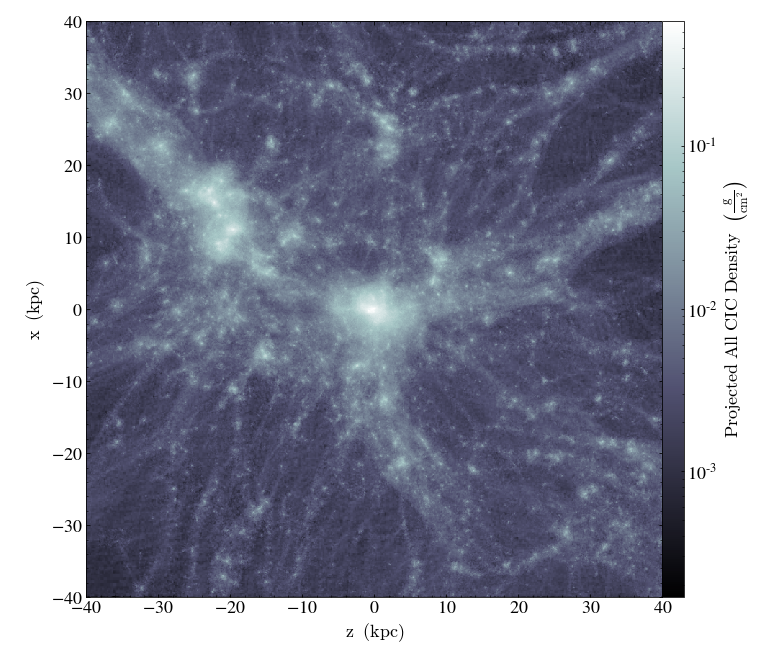

In [88]:
i = 0
ds = ds1
c=ds.arr(ps[i], 'code_length')
width = ds.quan(80, 'kpc')
region = ds.region(c, c-0.5*width, c+0.5*width)
field = ('deposit', 'all_cic')
s1 = yt.ProjectionPlot(ds, 'y', field, center=c, width=width, data_source=region)
s1.set_cmap(field, 'bone')

In [23]:
from os import listdir
from os.path import isfile, join

print(len(listdir('enzo_data/DD0101/')))
#was 108 at 613

136


In [84]:
ds2  = yt.load('enzo_data/DD0093/output_0093')

yt : [INFO     ] 2022-02-17 18:10:38,902 Parameters: current_time              = 25.69461836628
yt : [INFO     ] 2022-02-17 18:10:38,903 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-02-17 18:10:38,904 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-02-17 18:10:38,905 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-02-17 18:10:38,905 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-02-17 18:10:38,906 Parameters: current_redshift          = 9.0295661456118
yt : [INFO     ] 2022-02-17 18:10:38,906 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2022-02-17 18:10:38,906 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2022-02-17 18:10:38,907 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-02-17 18:10:38,907 Parameters: hubble_constant           = 0.71


Parsing Hierarchy : 100%|████████████████████████████████████████████████████| 283546/283546 [00:29<00:00, 9679.76it/s]
yt : [INFO     ] 2022-02-17 18:11:25,405 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2022-02-17 18:11:27,217 Projection completed
yt : [INFO     ] 2022-02-17 18:11:27,218 xlim = 0.471015 0.471266
yt : [INFO     ] 2022-02-17 18:11:27,219 ylim = 0.480772 0.481023
yt : [INFO     ] 2022-02-17 18:11:27,220 xlim = 0.471015 0.471266
yt : [INFO     ] 2022-02-17 18:11:27,221 ylim = 0.480772 0.481023
yt : [INFO     ] 2022-02-17 18:11:27,222 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800



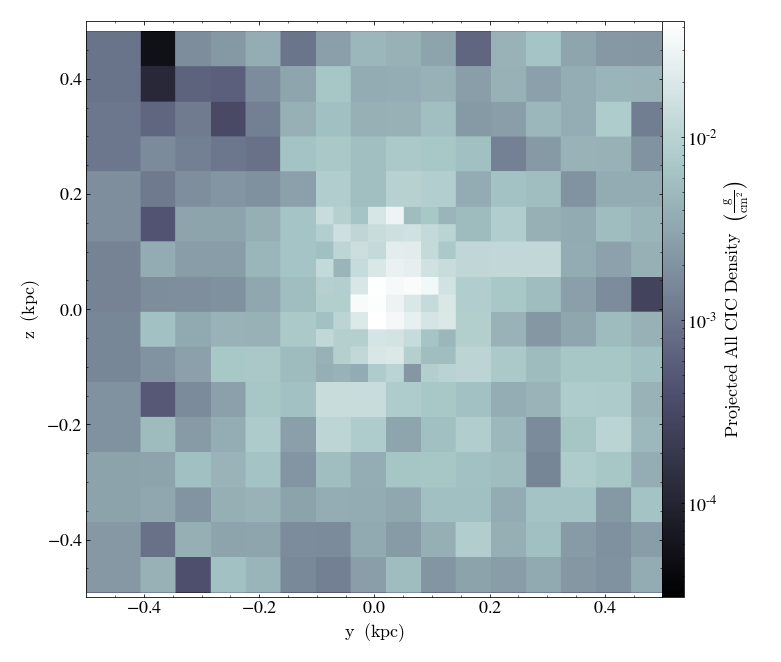

In [85]:
i = 1
ds = ds2
c=ds.arr(ps[i], 'code_length')
width = ds.quan(1, 'kpc')
region = ds.region(c, c-0.5*width, c+0.5*width)
field = ('deposit', 'all_cic')
s2 = yt.ProjectionPlot(ds, 'x', field, center=c, width=width, data_source=region)
s2.set_cmap(field, 'bone')

In [26]:
ds3  = yt.load('enzo_data/DD0101/output_0101')

yt : [INFO     ] 2022-02-02 18:49:07,554 Parameters: current_time              = 27.881706365935
yt : [INFO     ] 2022-02-02 18:49:07,555 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-02-02 18:49:07,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-02-02 18:49:07,556 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-02-02 18:49:07,557 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-02-02 18:49:07,557 Parameters: current_redshift          = 8.497456158109
yt : [INFO     ] 2022-02-02 18:49:07,557 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2022-02-02 18:49:07,558 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2022-02-02 18:49:07,558 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-02-02 18:49:07,558 Parameters: hubble_constant           = 0.71


Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 272689/272689 [00:24<00:00, 10949.00it/s]
yt : [INFO     ] 2022-02-02 18:59:42,598 Projection completed
yt : [INFO     ] 2022-02-02 18:59:42,599 xlim = 0.470990 0.472890
yt : [INFO     ] 2022-02-02 18:59:42,599 ylim = 0.481865 0.483764
yt : [INFO     ] 2022-02-02 18:59:42,600 xlim = 0.470990 0.472890
yt : [INFO     ] 2022-02-02 18:59:42,601 ylim = 0.481865 0.483764
yt : [INFO     ] 2022-02-02 18:59:42,602 Making a fixed resolution buffer of (('deposit', 'all_cic')) 800 by 800



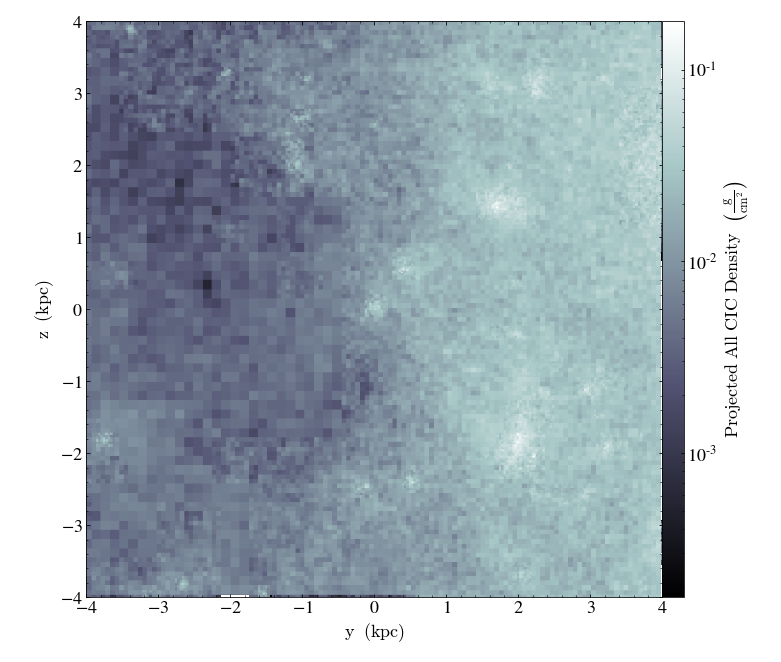

In [30]:
i = 2
ds = ds3
c=ds.arr(ps[i], 'code_length')
width = ds.quan(8, 'kpc')
region = ds.region(c, c-0.5*width, c+0.5*width)
field = ('deposit', 'all_cic')
s3 = yt.ProjectionPlot(ds, 'x', field, center=c, width=width, data_source=region)
s3.set_cmap(field, 'bone')

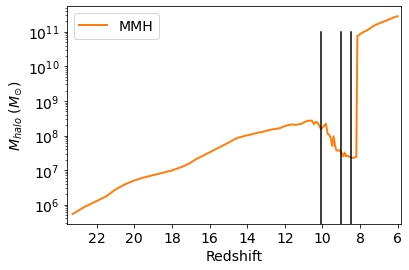

In [57]:
fig = plt.figure()
ax = plt.axes()
ax.set_xticks(range(0,30,2))

plt.yscale("log")
plt.xlim(23.6,5.8)
plt.xlabel("Redshift")
plt.ylabel(r"$M_{halo} \ (M_{\odot})$")
plt.plot(mm_z, mm_mass, label = "MMH", lw=2, c="tab:orange")
plt.plot([zs[0],zs[0]], [0,1e11], c="black")
plt.plot([zs[1],zs[1]], [0,1e11], c="black")
plt.plot([zs[2],zs[2]], [0,1e11], c="black")
plt.legend()
plt.savefig("figures/halo_mass_vs_z_snaps_marked.pdf")

In [53]:
d1 = mm_parent_distance[7]*1000
d2 = mm_parent_distance[20]*1000
d3 = mm_parent_distance[28]*1000
print(zs[0],zs[1],zs[2])
print(d1,d2,d3)
print(mm_mass[inds[0]], mm_mass[inds[1]], mm_mass[inds[2]])

10.07 9.029 8.497
0.3766106778344101 2.3133630799686924 2.1493109629130625
152410000.0 34203000.0 23893000.0



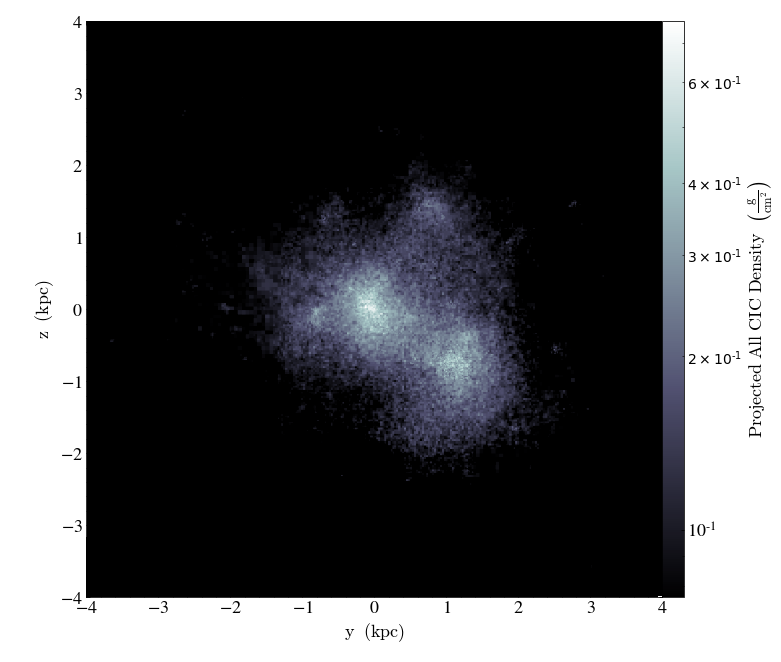


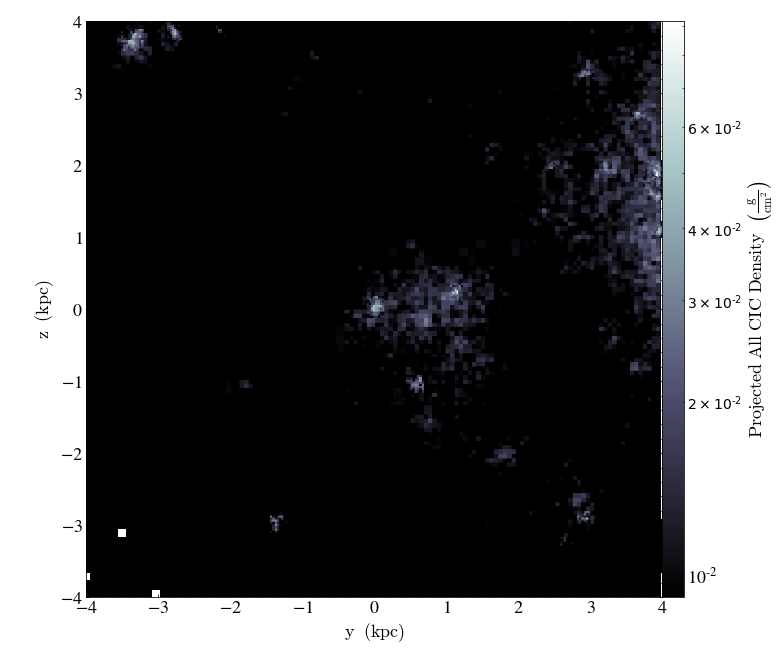


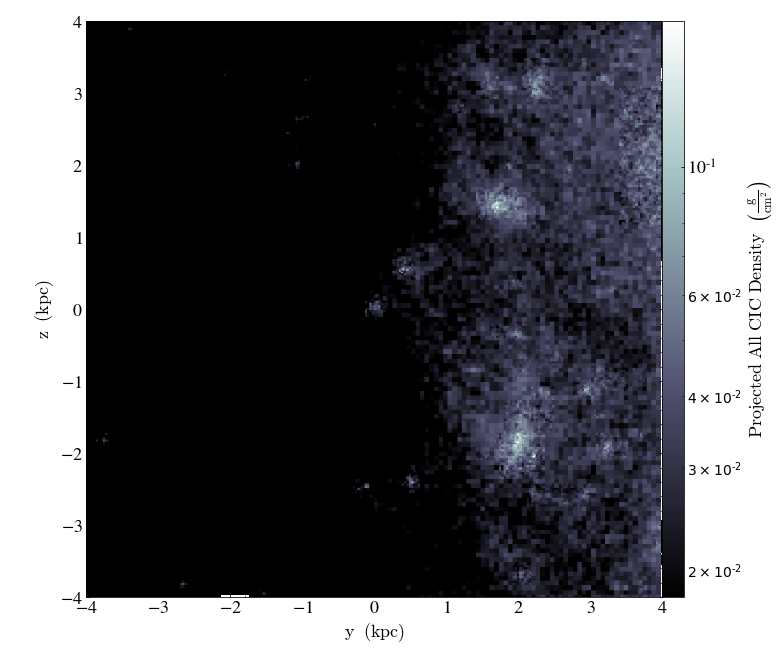

In [34]:
s4 = s1
zmax = s4.frb[field].max()
zmin = 1e-1 * zmax
s4.set_zlim(field, zmin, zmax)
s4.show()


s5 = s2
zmax = s5.frb[field].max()
zmin = 1e-1 * zmax
s5.set_zlim(field, zmin, zmax)
s5.show()



s6 = s3
zmax = s6.frb[field].max()
zmin = 1e-1 * zmax
s6.set_zlim(field, zmin, zmax)
s6.show()

In [58]:
d1 = mm_parent_distance[7]*1000
d2 = mm_parent_distance[20]*1000
d3 = mm_parent_distance[28]*1000
print(zs[0],zs[1],zs[2])
print(d1,d2,d3)
print(mm_mass[inds[0]], mm_mass[inds[1]], mm_mass[inds[2]])

10.07 9.029 8.497
0.3766106778344101 2.3133630799686924 2.1493109629130625
152410000.0 34203000.0 23893000.0


In [60]:
s4.save("z=10.07_parent_d=0.376_kpc.pdf")
s5.save("z=9.029_parent_d=2.313_kpc.pdf")
s6.save("z=8.497_parent_d=2.149_kpc.pdf")


yt : [WARNING  ] 2022-02-02 19:19:40,363 Received two valid image formats '.pdf' (from `filename`) and '.png' (from `suffix`). The former is ignored.
yt : [INFO     ] 2022-02-02 19:19:40,364 Saving plot z=10.07_parent_d=0.376_kpc_Projection_x_all_cic.png
yt : [WARNING  ] 2022-02-02 19:19:40,620 Received two valid image formats '.pdf' (from `filename`) and '.png' (from `suffix`). The former is ignored.
yt : [INFO     ] 2022-02-02 19:19:40,621 Saving plot z=9.029_parent_d=2.313_kpc_Projection_x_all_cic.png
yt : [WARNING  ] 2022-02-02 19:19:40,874 Received two valid image formats '.pdf' (from `filename`) and '.png' (from `suffix`). The former is ignored.
yt : [INFO     ] 2022-02-02 19:19:40,874 Saving plot z=8.497_parent_d=2.149_kpc_Projection_x_all_cic.png


['z=8.497_parent_d=2.149_kpc_Projection_x_all_cic.png']

yt : [INFO     ] 2022-02-02 19:44:21,587 Parameters: current_time              = 22.140600366142
yt : [INFO     ] 2022-02-02 19:44:21,588 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2022-02-02 19:44:21,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-02-02 19:44:21,589 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-02-02 19:44:21,590 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-02-02 19:44:21,590 Parameters: current_redshift          = 10.076893039419
yt : [INFO     ] 2022-02-02 19:44:21,590 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2022-02-02 19:44:21,590 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2022-02-02 19:44:21,591 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-02-02 19:44:21,591 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 318541/318541 [00:28<00


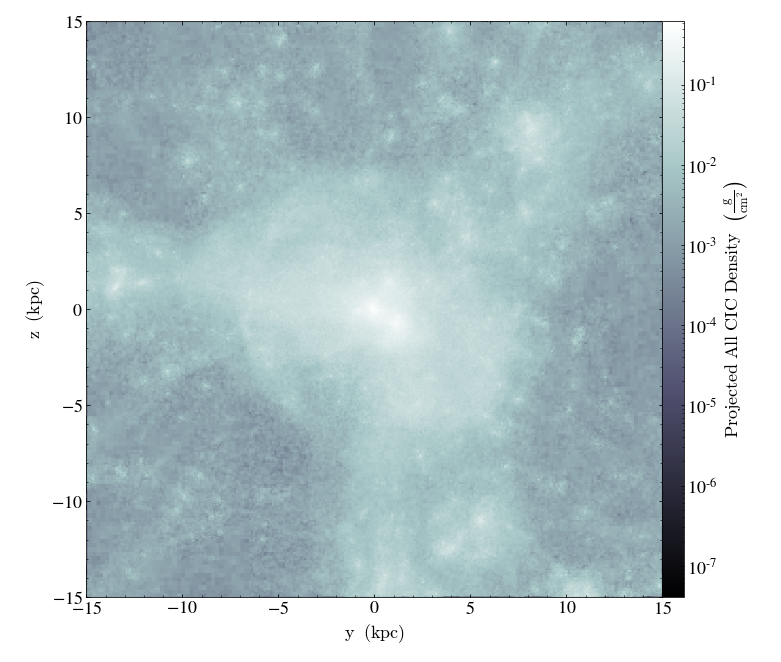

In [5]:
ds1  = yt.load('enzo_data/DD0080/output_0080')
i = 0
ds = ds1
c=ds.arr(ps[i], 'code_length')
width = ds.quan(30, 'kpc')
region = ds.region(c, c-0.5*width, c+0.5*width)
field = ('deposit', 'all_cic')
s1 = yt.ProjectionPlot(ds, 'x', field, center=c, width=width, data_source=region)
s1.set_cmap(field, 'bone')


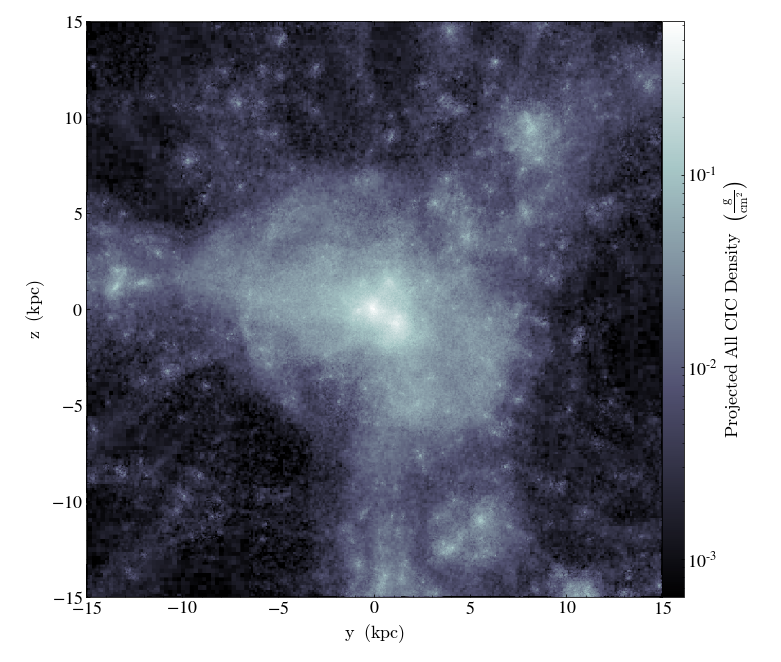

In [17]:
s4 = s1
zmax = s4.frb[field].max()
zmin = 1e-3 * zmax
s4.set_zlim(field, zmin, zmax)
s4.show()

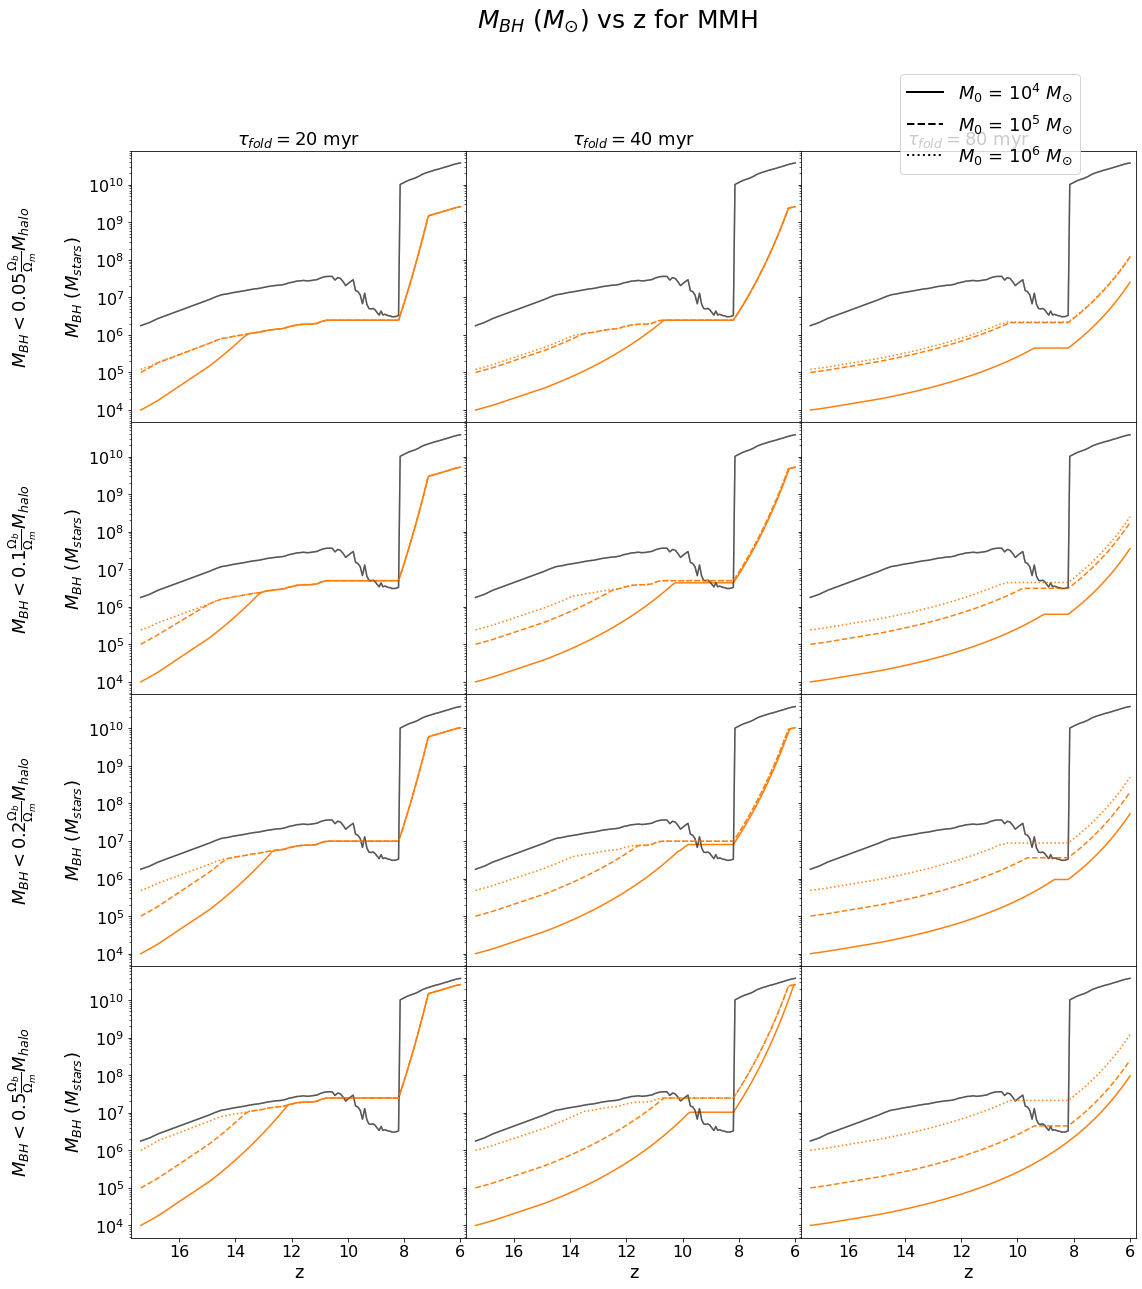

In [21]:
fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=True, figsize=(18, 20))
plt.yscale("log")
plt.xlim(17.7,5.8)


for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap, mm_uncapped = evolve_BH(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            axs[row, col].plot(np.array(mm_z)[mm_bh_indices], cap, c="black", alpha=0.3)
            axs[row, col].plot(np.array(mm_z)[mm_bh_indices], mm_bh_mass, c="tab:orange", linestyle = ls)
            
        if(row == 0): axs[row, col].set_title(r"$\tau_{fold} = $" +str(folding_list[col]) +" myr", fontsize = 18 )
        if(col == 0): axs[row, col].set_ylabel(r"$M_{BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_b}{\Omega_m} M_{halo}$"+ "\n\n"+ "$M_{BH} \ (M_{stars})$", fontsize = 18 )
        if(row == y_num-1): axs[row, col].set_xlabel("Redshift", fontsize = 18 )

            
#lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
#fig.legend((lines1), ('LW (born at z='+str(lw_seed_z)+")", 'MM (born at z='+str(mm_seed_z)+")"), loc='upper left', fontsize = 18, bbox_to_anchor=(0.12, 0.85))
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper right', fontsize = 18 , bbox_to_anchor=(0.84, 0.85))       
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z_MMH.pdf",bbox_inches='tight')

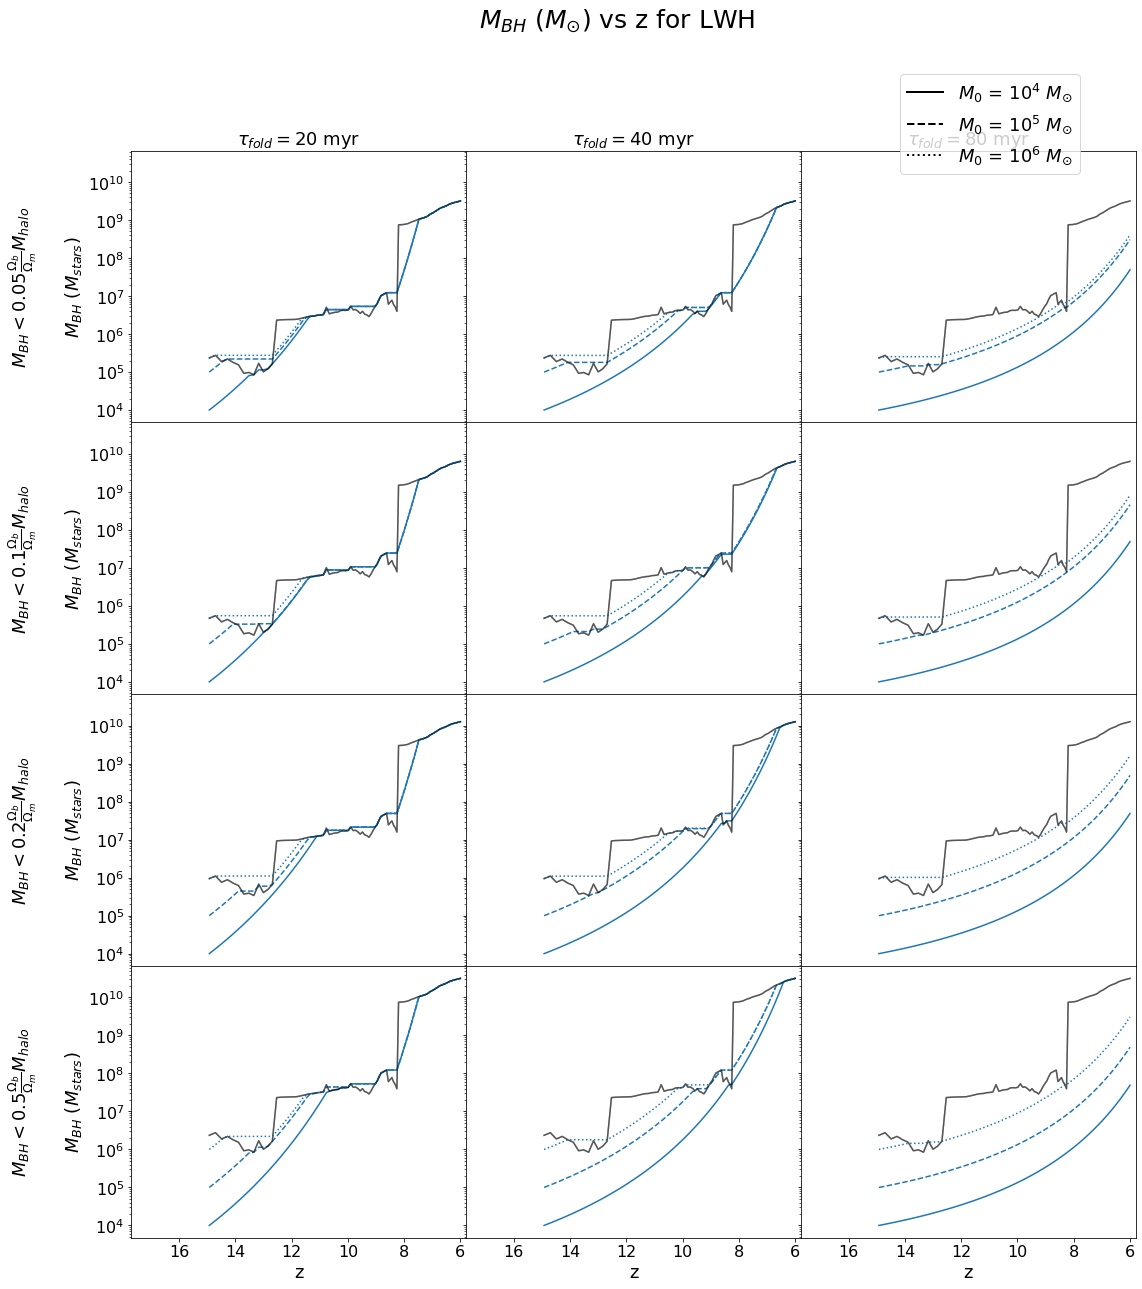

In [20]:
fig, axs = plt.subplots(ncols=x_num, nrows=y_num, sharex=True, sharey=True, figsize=(18, 20))
plt.yscale("log")
plt.xlim(17.7,5.8)

for row in range(y_num):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            lw_bh_mass, lw_cap, lw_uncapped = evolve_BH(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            axs[row, col].plot(np.array(lw_z)[lw_bh_indices], lw_bh_mass, c="tab:blue", linestyle=ls)
            axs[row, col].plot(np.array(lw_z)[lw_bh_indices], lw_cap, c="black", alpha=0.3)
            
                        
        if(row == 0): axs[row, col].set_title(r"$\tau_{fold} = $" +str(folding_list[col]) +" myr", fontsize = 18 )
        if(col == 0): axs[row, col].set_ylabel(r"$M_{BH} < $"+str(cap_list[row]) +r"$\frac{\Omega_b}{\Omega_m} M_{halo}$"+ "\n\n"+ "$M_{BH} \ (M_{stars})$", fontsize = 18 )
        if(row == y_num-1): axs[row, col].set_xlabel("Redshift", fontsize = 18 )

            
#lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
#fig.legend((lines1), ('LW (born at z='+str(lw_seed_z)+")", 'MM (born at z='+str(mm_seed_z)+")"), loc='upper left', fontsize = 18, bbox_to_anchor=(0.12, 0.85))
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper right', fontsize = 18 , bbox_to_anchor=(0.84, 0.85))       
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z_LWH.pdf",bbox_inches='tight')

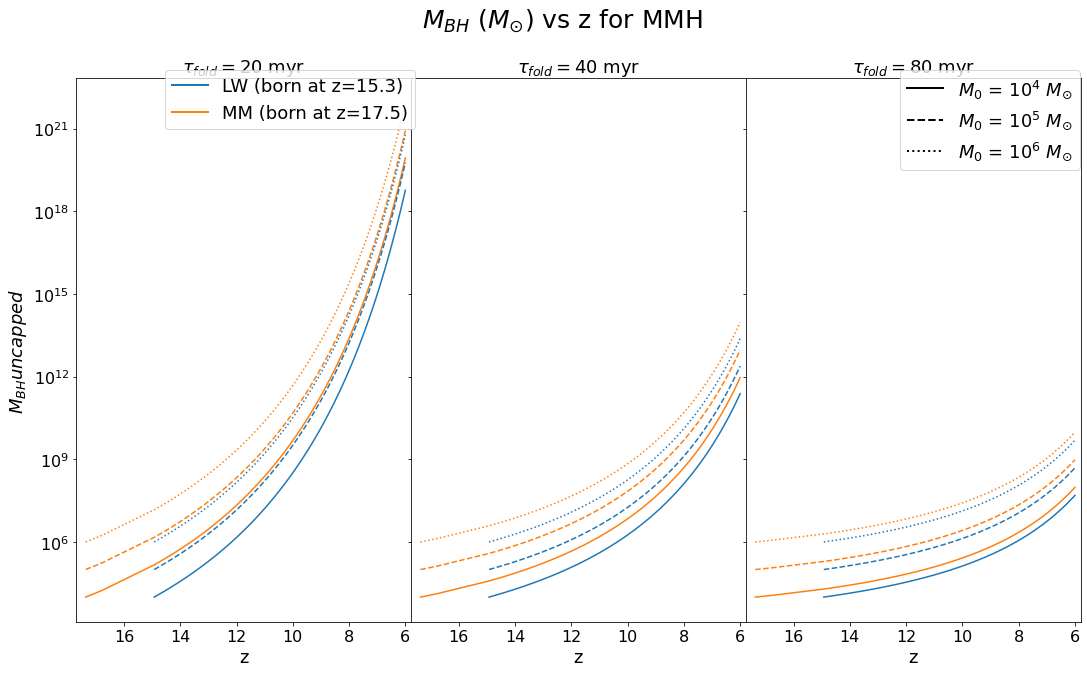

In [26]:
fig, axs = plt.subplots(ncols=x_num, nrows=1, sharex=True, sharey=True, figsize=(18, 10))
plt.yscale("log")
plt.xlim(17.7,5.8)


for row in range(1):
    for col in range(x_num):
        for seed,ls in zip(seed_list,["-", "--", ":"]):
            mm_bh_mass, mm_cap, mm_uncapped = evolve_BH(np.array(mm_mass)[mm_bh_indices],np.array(mm_time)[mm_bh_indices], folding_list[col], cap_list[row], seed)
            lw_bh_mass, lw_cap, lw_uncapped = evolve_BH(np.array(lw_mass)[lw_bh_indices],np.array(lw_time)[lw_bh_indices], folding_list[col], cap_list[row], seed)
            axs[col].plot(np.array(mm_z)[mm_bh_indices], mm_uncapped, c="tab:orange", linestyle = ls)
            axs[col].plot(np.array(lw_z)[lw_bh_indices], lw_uncapped, c="tab:blue", linestyle = ls)
            
        axs[col].set_title(r"$\tau_{fold} = $" +str(folding_list[col]) +" myr", fontsize = 18 )
        if(col == 0): axs[col].set_ylabel(r"$M_{BH} uncapped$", fontsize = 18 )
        axs[col].set_xlabel("Redshift", fontsize = 18 )

            
lines1 = [Line2D([0], [0], color=c, linewidth=2) for c in ["tab:blue", "tab:orange"]]
lines2 = [Line2D([0], [0], color="black", linewidth=2, linestyle=ls) for ls in ["-", "--", ":"]]
fig.legend((lines1), ('LW (born at z='+str(lw_seed_z)+")", 'MM (born at z='+str(mm_seed_z)+")"), loc='upper left', fontsize = 18, bbox_to_anchor=(0.12, 0.85))
fig.legend((lines2), (r'$M_0$ = $10^{4}$ $M_{\odot}$', r'$M_0$ = $10^{5}$ $M_{\odot}$', r'$M_0$ = $10^{6}$ $M_{\odot}$'), loc='upper right', fontsize = 18 , bbox_to_anchor=(0.84, 0.85))       
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figures/bh_vs_z_uncapped.pdf",,bbox_inches='tight')